In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Problem 1

## Preamble

In [25]:
# Replace with file path of Problem1.csv if not in the same folder as this notebook
prob1_fp = 'Problem1.csv'

# Import data
prob1_df = pd.read_csv(prob1_fp, header=None, names=['x1','x2','y'])

# Set up problem parameters and vectors
n, p, x1, x2, y = prob1_df.shape[0], prob1_df.shape[1] - 1, prob1_df['x1'], prob1_df['x2'], prob1_df['y']
X = prob1_df[['x1','x2']]


# Preview the first 5 rows
prob1_df.head(5)

,x1,x2,y
0,0.65865,-0.75245,1
1,0.53805,-0.84291,1
2,-0.34941,-0.93697,-1
3,0.56989,-0.82172,1
4,-0.42218,-0.90651,-1


## Problem 1 Q1 - Plotting

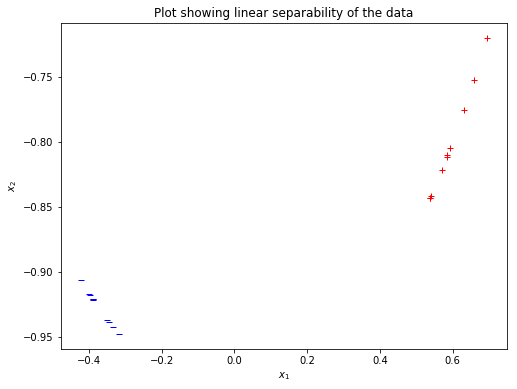

In [26]:
fig_prob1q1, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Plot showing linear separability of the data')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

##############################################################################
# TODO: Plot the labeled data by looking up the y_marker dictionary, refer   # 
# to: https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.plot.html #
##############################################################################

for i in range(n):
    if(y[i]<0):
        ax.plot(x1[i],x2[i],'b_', label="Negative")
    else:
        ax.plot(x1[i],x2[i],'r+', label="Positive")

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

plt.savefig("problem1_q1", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

## Problem 1 Q2 - Finding max-margin solution using SVM

* We recommend using the *quadprog* module in conjuction with the below function (which is just a convenient wrapper) to solve the SVM optimization. Before running the below cell, install Python package *quadprog* by opening anaconda command prompt and running:

   *pip install quadprog*
   
   
* You can use other optimization packages such as CVXOPT or CVXPY if you are able to install them correctly (if you are using later versions of Python > 3.4 you may need to create virtual environment to install such packages)

* The below function solves a quadratic program:
        minimize
            (1/2) * x.T * P * x + q.T * x
        subject to
            G * x <= h
            A * x == b
            
* **Important:** You might encounter an error (even in other convex optimization software) that the objective matrix is not PD. A workaround is to perturb the matrix along the diagonal by a small positive epsilon.  

In [27]:
import quadprog
import matrix
def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None, initvals=None):
    """
    Solve a Quadratic Program defined as:
        minimize
            (1/2) * x.T * P * x + q.T * x
        subject to
            G * x <= h
            A * x == b
    using quadprog <https://pypi.python.org/pypi/quadprog/>.
    Parameters
    ----------
    P : numpy.array
        Symmetric quadratic-cost matrix.
    q : numpy.array
        Quadratic-cost vector.
    G : numpy.array
        Linear inequality constraint matrix.
    h : numpy.array
        Linear inequality constraint vector.
    A : numpy.array, optional
        Linear equality constraint matrix.
    b : numpy.array, optional
        Linear equality constraint vector.
    initvals : numpy.array, optional
        Warm-start guess vector (not used).
    Returns
    -------
    x : numpy.array
        Solution to the QP, if found, otherwise ``None``.
    Note
    ----
    The quadprog solver only considers the lower entries of `P`, therefore it
    will use a wrong cost function if a non-symmetric matrix is provided.
    """
    if initvals is not None:
        print("quadprog: note that warm-start values ignored by wrapper")
    qp_G = P
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

##############################################################################
#Function to get minimum gamma for gamma_star = min_gamma/||theta_star||
##############################################################################
def get_min_gamma(n,y,x1,x2,theta):
    min = 10000
    for i in range(n):
        if(y[i]*(theta[0]*x1[i]+theta[1]*x2[i])<min):
            min = y[i]*(theta[0]*x1[i]+theta[1]*x2[i])
    return min

In [28]:
##############################################################################
# TODO: Fill in the matrices as per the hard SVM formulation                 #
# Refer to the function above                                                #
##############################################################################
P = np.eye(p,p)
q = np.zeros(p)
G = np.zeros((n,p))
h = -1*np.ones(n)
for i in range(n):
    for j in range(p):
        if(j==0):
            G[i,j] = (-1*y[i]*x1[i])
        else:
            G[i,j] = (-1*y[i]*x2[i])
##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 

theta_star = quadprog_solve_qp(P, q, G=G, h=h) 
# Normalize theta
theta_star = (1.0/np.linalg.norm(theta_star)) * theta_star

##############################################################################
# TODO: Retrieve gamma_star from theta_star                                  #
##############################################################################

gamma_min = get_min_gamma(n,y,x1,x2,theta_star) #get the minimum gamma as defined in the previous function

gamma_star = gamma_min/np.linalg.norm(theta_star)

##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 

print('Problem 1 Q2 \n=================================')
print('theta^*: %s' % theta_star)
print('gamma^*: %s' % gamma_star)

Problem 1 Q2 
theta^*: [ 0.99257345  0.12164684]
gamma^*: 0.431484598217


## Problem 1 Q3 - Standard Perceptron Algorithm

### Problem 1 Q3(a)

In [29]:
## Std. Perceptron Implementation
"""
Parameters:
X: (n,p) feature matrix
y: n-vector of labels
theta_zero: initial theta

Returns:
k: # updates
theta_k: Converged (normalized) theta
gamma: margin for this theta_k
"""
def std_perceptron(X, y, theta_zero):   
    k = 0
    theta_k = theta_zero
    gamma = None    
    ##############################################################################
    # TODO: Implement the std. perceptron algorithm, update theta_k and increment#
    # k when necessary, remember to normalize theta and calculate gamma          #
    ##############################################################################
    i = 0
    x1 = X['x1']
    x2 = X['x2']
    max_iterations = 1000
    updates = 0
    while(updates<max_iterations):
        i = 0
        while(i<len(y)):
            if(y[i]*(theta_k[0]*x1[i]+theta_k[1]*x2[i])<=0):
                k+=1
                theta_k[0] = theta_k[0] + y[i]*x1[i]
                theta_k[1] = theta_k[1] + y[i]*x2[i]
            i+=1
        updates+=1
        if(k>max_iterations):
            print("Max iterations exceeded; data is non-separable!")
            break;
        
    theta_k = (1.0/np.linalg.norm(theta_k)) * theta_k       
    gamma = get_min_gamma(len(y),y,x1,x2,theta_k)/np.linalg.norm(theta_k)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################                   
    return k, theta_k, gamma

In [30]:
## Run this to see results
theta_zero = np.zeros(p)
k, theta, gamma = std_perceptron(X, y, theta_zero)
print('Problem 1 Q3(a) \n=================================')
print("Number of updates, k = %s" % k)
print("theta = %s" % theta)
print("gamma = %s" % gamma)

Problem 1 Q3(a) 
Number of updates, k = 2
theta = [ 0.98365688  0.18005314]
gamma = 0.377454883747


### Problem 1 Q3(b)

In [21]:
num_iter = 10
for i in range(1,num_iter + 1):
    ##############################################################################
    # TODO: Generate random theta_zero and run perceptron                        # 
    ##############################################################################
    # Store the results for this iteration in these variables
   
    theta_zero_i = np.zeros(p)+(np.random.rand(),np.random.rand())
    
    print('==================Iter %s==================' % i)
    print('theta_zero = %s' % theta_zero_i)

    k_i,theta_i,gamma_i = std_perceptron(X, y, theta_zero_i)  
    
    print('k = %s, theta = [%.3f,%.3f], gamma=%.3f' % (k_i, theta_i[0], theta_i[1], gamma_i))
    
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################   

==================Iter 1==================
theta_zero = [ 0.74794344  0.79374993]
k = 1, theta = [1.000,0.029], gamma=0.346
==================Iter 2==================
theta_zero = [ 0.12825667  0.29218249]
k = 2, theta = [0.922,0.387], gamma=0.170
==================Iter 3==================
theta_zero = [ 0.77883043  0.0649501 ]
k = 0, theta = [0.997,0.083], gamma=0.396
==================Iter 4==================
theta_zero = [ 0.18658537  0.55412612]
k = 1, theta = [0.974,-0.228], gamma=0.094
==================Iter 5==================
theta_zero = [ 0.65364266  0.00123201]
k = 0, theta = [1.000,0.002], gamma=0.320
==================Iter 6==================
theta_zero = [ 0.07679343  0.86728292]
k = 1, theta = [0.988,0.154], gamma=0.402
==================Iter 7==================
theta_zero = [ 0.73933756  0.65419106]
k = 1, theta = [0.998,-0.070], gamma=0.251
==================Iter 8==================
theta_zero = [ 0.76393958  0.16413424]
k = 0, theta = [0.978,0.210], gamma=0.349
======

### Problem 1 Q3(d)

In [4]:
"""
Parameters:
d: dimension of the sphere

Returns:
random point from boundary of d-sphere
"""
def sample_unit_sphere(d):    
    ##############################################################################
    # TODO: Generate a point from the boundary of a d-sphere                     #
    # Refer to the link provided in the question sheet                           #
    ##############################################################################
    
    point = np.random.randn(d,1)
    point = np.array([point[0][0],point[1][0]])
    point = point/np.linalg.norm(point)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ############################################################################## 
    return point 

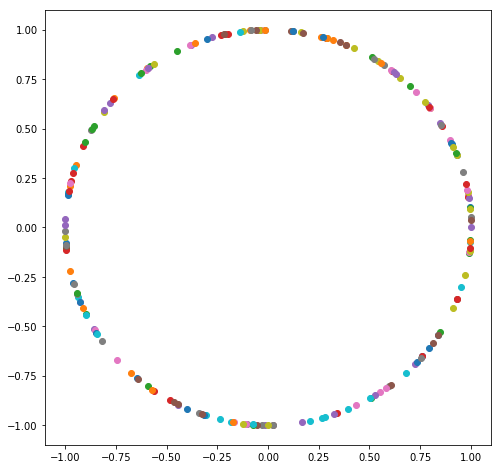

In [5]:
## Run this to check that your function is indeed sampling from the unit 2-sphere
# You should see a circle
fig, ax = plt.subplots(1, figsize=(8,8))
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
for i in range(200):
    point = sample_unit_sphere(2)
    ax.scatter(point[0], point[1])
plt.show()

In [24]:
##############################################################################
# TODO: Complete Problem 1 Q3(d) by sampling theta^{(0)} from the unit-circle#
# at each round and running the std perceptron                               #
# Hint: Save the first 100 results in a vector for plotting later            # 
##############################################################################
k = np.zeros(10000)
theta = np.zeros((100,2))
gamma = np.zeros(10000)
theoretical_upper_bound = np.zeros(100)
for i in range(10000):
    theta_init = sample_unit_sphere(2)
    print('==================Iter %s==================' % (i+1))
    print('Sample point from unit circle = %s' % theta_init)
    if(i<100):
        k[i],theta[i],gamma[i] = std_perceptron(X, y, theta_init)
        theoretical_upper_bound[i] = 1/pow(gamma[i],2)
        print('k = %s, theta = [%.3f,%.3f], gamma=%.3f' % (k[i], theta[i][0], theta[i][1], gamma[i]))
    else:
        k[i],theta,gamma[i] = std_perceptron(X, y, theta_init)
        print('k = %s, theta = [%.3f,%.3f], gamma=%.3f' % (k[i], theta[0], theta[1], gamma[i]))



##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 

==================Iter 1==================
Sample point from unit circle = [-0.82021535  0.57205487]
k = 3.0, theta = [0.996,-0.086], gamma=0.236
==================Iter 2==================
Sample point from unit circle = [ 0.80547874 -0.59262467]
k = 1.0, theta = [0.958,0.286], gamma=0.275
==================Iter 3==================
Sample point from unit circle = [ 0.34508442 -0.93857165]
k = 1.0, theta = [1.000,-0.002], gamma=0.316
==================Iter 4==================
Sample point from unit circle = [ 0.7983284   0.60222236]
k = 1.0, theta = [0.984,-0.177], gamma=0.145
==================Iter 5==================
Sample point from unit circle = [-0.50022848 -0.86589345]
k = 3.0, theta = [0.983,0.182], gamma=0.375
==================Iter 6==================
Sample point from unit circle = [ 0.9963224   0.08568362]
k = 0.0, theta = [0.996,0.086], gamma=0.399
==================Iter 7==================
Sample point from unit circle = [-0.87314514  0.48746031]
k = 3.0, theta = [0.978,-0

k = 1.0, theta = [0.994,0.109], gamma=0.420
==================Iter 58==================
Sample point from unit circle = [ 0.970545   -0.24091989]
k = 0.0, theta = [0.971,-0.241], gamma=0.081
==================Iter 59==================
Sample point from unit circle = [ 0.83672616 -0.54762153]
k = 1.0, theta = [0.950,0.312], gamma=0.248
==================Iter 60==================
Sample point from unit circle = [-0.9591023   0.28305966]
k = 4.0, theta = [0.883,0.469], gamma=0.080
==================Iter 61==================
Sample point from unit circle = [ 0.6570772  -0.75382329]
k = 1.0, theta = [0.984,0.179], gamma=0.378
==================Iter 62==================
Sample point from unit circle = [ 0.96363011 -0.26723962]
k = 0.0, theta = [0.964,-0.267], gamma=0.054
==================Iter 63==================
Sample point from unit circle = [ 0.55956606 -0.82878575]
k = 1.0, theta = [0.993,0.118], gamma=0.428
==================Iter 64==================
Sample point from unit circle = [-

k = 1.0, theta = [1.000,0.009], gamma=0.327
==================Iter 114==================
Sample point from unit circle = [ 0.17424883 -0.98470165]
k = 1.0, theta = [0.996,-0.091], gamma=0.231
==================Iter 115==================
Sample point from unit circle = [-0.34881167  0.93719284]
k = 1.0, theta = [0.859,0.512], gamma=0.030
==================Iter 116==================
Sample point from unit circle = [ 0.83629526 -0.54827934]
k = 1.0, theta = [0.950,0.312], gamma=0.249
==================Iter 117==================
Sample point from unit circle = [-0.62524996 -0.78042456]
k = 3.0, theta = [0.948,0.319], gamma=0.241
==================Iter 118==================
Sample point from unit circle = [-0.66136198 -0.75006689]
k = 3.0, theta = [0.929,0.371], gamma=0.187
==================Iter 119==================
Sample point from unit circle = [ 0.26955042 -0.96298628]
k = 1.0, theta = [0.999,-0.042], gamma=0.278
==================Iter 120==================
Sample point from unit circ

k = 1.0, theta = [1.000,0.029], gamma=0.346
==================Iter 170==================
Sample point from unit circle = [ 0.83070932 -0.55670641]
k = 1.0, theta = [0.952,0.307], gamma=0.254
==================Iter 171==================
Sample point from unit circle = [-0.87971627  0.47549898]
k = 3.0, theta = [0.974,-0.226], gamma=0.096
==================Iter 172==================
Sample point from unit circle = [ 0.9945634   0.10413285]
k = 0.0, theta = [0.995,0.104], gamma=0.416
==================Iter 173==================
Sample point from unit circle = [ 0.21100243 -0.97748554]
k = 1.0, theta = [0.997,-0.072], gamma=0.249
==================Iter 174==================
Sample point from unit circle = [-0.26347752 -0.96466554]
k = 1.0, theta = [0.952,-0.307], gamma=0.012
==================Iter 175==================
Sample point from unit circle = [ 0.73424359  0.67888611]
k = 1.0, theta = [0.999,-0.053], gamma=0.268
==================Iter 176==================
Sample point from unit ci

k = 3.0, theta = [0.911,0.413], gamma=0.142
==================Iter 226==================
Sample point from unit circle = [ 0.74277126  0.66954526]
k = 1.0, theta = [0.998,-0.059], gamma=0.262
==================Iter 227==================
Sample point from unit circle = [ 0.99726042 -0.07397067]
k = 0.0, theta = [0.997,-0.074], gamma=0.248
==================Iter 228==================
Sample point from unit circle = [ 0.62367937  0.78168027]
k = 1.0, theta = [1.000,0.023], gamma=0.340
==================Iter 229==================
Sample point from unit circle = [-0.75980747 -0.65014814]
k = 4.0, theta = [0.949,-0.315], gamma=0.004
==================Iter 230==================
Sample point from unit circle = [ 0.40809646 -0.91293882]
k = 1.0, theta = [0.999,0.032], gamma=0.348
==================Iter 231==================
Sample point from unit circle = [-0.64087211 -0.76764767]
k = 3.0, theta = [0.940,0.341], gamma=0.218
==================Iter 232==================
Sample point from unit cir

k = 1.0, theta = [0.902,0.432], gamma=0.121
==================Iter 282==================
Sample point from unit circle = [ 0.27576668 -0.9612246 ]
k = 1.0, theta = [0.999,-0.039], gamma=0.282
==================Iter 283==================
Sample point from unit circle = [-0.61768691  0.78642411]
k = 3.0, theta = [0.991,0.137], gamma=0.418
==================Iter 284==================
Sample point from unit circle = [-0.03320348 -0.99944861]
k = 1.0, theta = [0.981,-0.194], gamma=0.129
==================Iter 285==================
Sample point from unit circle = [ 0.8220958  -0.56934918]
k = 1.0, theta = [0.954,0.299], gamma=0.261
==================Iter 286==================
Sample point from unit circle = [ 0.1613103  -0.98690374]
k = 1.0, theta = [0.995,-0.097], gamma=0.225
==================Iter 287==================
Sample point from unit circle = [ 0.37050087  0.92883212]
k = 1.0, theta = [0.986,0.169], gamma=0.388
==================Iter 288==================
Sample point from unit cir

k = 5.0, theta = [0.998,-0.067], gamma=0.255
==================Iter 338==================
Sample point from unit circle = [ 0.5004746  -0.86575122]
k = 1.0, theta = [0.997,0.084], gamma=0.397
==================Iter 339==================
Sample point from unit circle = [ 0.78035359  0.62533853]
k = 1.0, theta = [0.987,-0.163], gamma=0.160
==================Iter 340==================
Sample point from unit circle = [ 0.93559707 -0.35306957]
k = 1.0, theta = [0.910,0.414], gamma=0.141
==================Iter 341==================
Sample point from unit circle = [-0.99927377  0.03810423]
k = 4.0, theta = [0.956,0.294], gamma=0.267
==================Iter 342==================
Sample point from unit circle = [-0.92294211  0.38493877]
k = 5.0, theta = [0.995,-0.097], gamma=0.225
==================Iter 343==================
Sample point from unit circle = [-0.78422993 -0.62047032]
k = 4.0, theta = [0.954,-0.299], gamma=0.020
==================Iter 344==================
Sample point from unit ci

k = 3.0, theta = [0.975,-0.220], gamma=0.102
==================Iter 394==================
Sample point from unit circle = [-0.9998587  -0.01681031]
k = 4.0, theta = [0.970,0.245], gamma=0.315
==================Iter 395==================
Sample point from unit circle = [ 0.52282698 -0.85243882]
k = 1.0, theta = [0.995,0.096], gamma=0.408
==================Iter 396==================
Sample point from unit circle = [ 0.99218449 -0.12477956]
k = 0.0, theta = [0.992,-0.125], gamma=0.198
==================Iter 397==================
Sample point from unit circle = [-0.57692025 -0.81680048]
k = 3.0, theta = [0.966,0.259], gamma=0.301
==================Iter 398==================
Sample point from unit circle = [ 0.36904934  0.9294098 ]
k = 1.0, theta = [0.985,0.170], gamma=0.387
==================Iter 399==================
Sample point from unit circle = [ 0.20498929 -0.97876422]
k = 1.0, theta = [0.997,-0.075], gamma=0.246
==================Iter 400==================
Sample point from unit cir

k = 0.0, theta = [0.999,-0.046], gamma=0.274
==================Iter 450==================
Sample point from unit circle = [ 0.49244686 -0.87034251]
k = 1.0, theta = [0.997,0.079], gamma=0.392
==================Iter 451==================
Sample point from unit circle = [ 0.80226844  0.59696345]
k = 1.0, theta = [0.984,-0.180], gamma=0.142
==================Iter 452==================
Sample point from unit circle = [-0.62801886 -0.77819812]
k = 3.0, theta = [0.946,0.323], gamma=0.237
==================Iter 453==================
Sample point from unit circle = [-0.71863802  0.69538435]
k = 3.0, theta = [0.998,0.068], gamma=0.382
==================Iter 454==================
Sample point from unit circle = [-0.84725372  0.53118842]
k = 3.0, theta = [0.990,-0.144], gamma=0.179
==================Iter 455==================
Sample point from unit circle = [ 0.99557708 -0.09394825]
k = 0.0, theta = [0.996,-0.094], gamma=0.228
==================Iter 456==================
Sample point from unit ci

k = 4.0, theta = [0.996,-0.091], gamma=0.231
==================Iter 506==================
Sample point from unit circle = [ 0.81505709 -0.57938065]
k = 1.0, theta = [0.956,0.294], gamma=0.267
==================Iter 507==================
Sample point from unit circle = [-0.97814189 -0.20793855]
k = 4.0, theta = [0.999,0.041], gamma=0.357
==================Iter 508==================
Sample point from unit circle = [-0.99659124 -0.08249785]
k = 4.0, theta = [0.983,0.183], gamma=0.375
==================Iter 509==================
Sample point from unit circle = [-0.72086032  0.69308037]
k = 3.0, theta = [0.998,0.065], gamma=0.380
==================Iter 510==================
Sample point from unit circle = [ 0.64725092 -0.76227702]
k = 1.0, theta = [0.985,0.173], gamma=0.384
==================Iter 511==================
Sample point from unit circle = [-0.27639883  0.96104302]
k = 1.0, theta = [0.878,0.479], gamma=0.069
==================Iter 512==================
Sample point from unit circl

k = 1.0, theta = [0.983,0.182], gamma=0.376
==================Iter 562==================
Sample point from unit circle = [-0.74041127 -0.67215411]
k = 3.0, theta = [0.864,0.503], gamma=0.041
==================Iter 563==================
Sample point from unit circle = [-0.95292358 -0.30321059]
k = 4.0, theta = [0.999,-0.053], gamma=0.268
==================Iter 564==================
Sample point from unit circle = [-0.7881713  -0.61545593]
k = 4.0, theta = [0.955,-0.296], gamma=0.023
==================Iter 565==================
Sample point from unit circle = [ 0.60439841 -0.79668222]
k = 1.0, theta = [0.989,0.146], gamma=0.410
==================Iter 566==================
Sample point from unit circle = [ 0.68812558  0.72559161]
k = 1.0, theta = [1.000,-0.020], gamma=0.300
==================Iter 567==================
Sample point from unit circle = [ 0.77679353  0.62975536]
k = 1.0, theta = [0.987,-0.160], gamma=0.163
==================Iter 568==================
Sample point from unit ci

k = 1.0, theta = [0.956,0.292], gamma=0.268
==================Iter 618==================
Sample point from unit circle = [  5.52689919e-05  -9.99999998e-01]
k = 1.0, theta = [0.984,-0.177], gamma=0.145
==================Iter 619==================
Sample point from unit circle = [ 0.77058236  0.63734043]
k = 1.0, theta = [0.988,-0.155], gamma=0.168
==================Iter 620==================
Sample point from unit circle = [ 0.6843073  -0.72919375]
k = 1.0, theta = [0.980,0.197], gamma=0.361
==================Iter 621==================
Sample point from unit circle = [ 0.66801242 -0.74415012]
k = 1.0, theta = [0.983,0.186], gamma=0.372
==================Iter 622==================
Sample point from unit circle = [ 0.66507999  0.74677213]
k = 1.0, theta = [1.000,-0.004], gamma=0.314
==================Iter 623==================
Sample point from unit circle = [-0.91643689 -0.40017924]
k = 4.0, theta = [0.990,-0.142], gamma=0.181
==================Iter 624==================
Sample point fr

k = 0.0, theta = [0.978,0.210], gamma=0.349
==================Iter 674==================
Sample point from unit circle = [ 0.43319362  0.90130089]
k = 1.0, theta = [0.991,0.135], gamma=0.419
==================Iter 675==================
Sample point from unit circle = [ 0.31183117  0.95013753]
k = 1.0, theta = [0.980,0.200], gamma=0.359
==================Iter 676==================
Sample point from unit circle = [-0.99931217 -0.03708343]
k = 4.0, theta = [0.974,0.226], gamma=0.334
==================Iter 677==================
Sample point from unit circle = [ 0.75956771 -0.65042824]
k = 1.0, theta = [0.968,0.250], gamma=0.310
==================Iter 678==================
Sample point from unit circle = [-0.84643904  0.53248563]
k = 3.0, theta = [0.990,-0.142], gamma=0.181
==================Iter 679==================
Sample point from unit circle = [-0.41436186 -0.91011222]
k = 3.0, theta = [0.993,0.120], gamma=0.430
==================Iter 680==================
Sample point from unit circl

k = 3.0, theta = [0.977,0.215], gamma=0.345
==================Iter 730==================
Sample point from unit circle = [-0.89081172 -0.45437263]
k = 4.0, theta = [0.982,-0.187], gamma=0.136
==================Iter 731==================
Sample point from unit circle = [-0.8043297   0.59418325]
k = 3.0, theta = [0.998,-0.056], gamma=0.265
==================Iter 732==================
Sample point from unit circle = [-0.68719716 -0.72647096]
k = 3.0, theta = [0.911,0.411], gamma=0.144
==================Iter 733==================
Sample point from unit circle = [ 0.46860815  0.88340614]
k = 1.0, theta = [0.993,0.115], gamma=0.426
==================Iter 734==================
Sample point from unit circle = [-0.07657427 -0.99706388]
k = 1.0, theta = [0.977,-0.215], gamma=0.107
==================Iter 735==================
Sample point from unit circle = [ 0.94813528 -0.3178671 ]
k = 0.0, theta = [0.948,-0.318], gamma=0.001
==================Iter 736==================
Sample point from unit ci

k = 1.0, theta = [0.850,0.527], gamma=0.013
==================Iter 786==================
Sample point from unit circle = [ 0.46920025 -0.8830918 ]
k = 1.0, theta = [0.998,0.066], gamma=0.380
==================Iter 787==================
Sample point from unit circle = [ 0.96121322 -0.27580636]
k = 0.0, theta = [0.961,-0.276], gamma=0.045
==================Iter 788==================
Sample point from unit circle = [ 0.93406462 -0.35710403]
k = 1.0, theta = [0.911,0.412], gamma=0.143
==================Iter 789==================
Sample point from unit circle = [-0.94893706  0.31546546]
k = 4.0, theta = [0.874,0.486], gamma=0.060
==================Iter 790==================
Sample point from unit circle = [-0.9565718   0.29149682]
k = 4.0, theta = [0.881,0.473], gamma=0.075
==================Iter 791==================
Sample point from unit circle = [-0.80801601  0.58916053]
k = 3.0, theta = [0.998,-0.062], gamma=0.259
==================Iter 792==================
Sample point from unit circ

k = 1.0, theta = [0.936,0.353], gamma=0.206
==================Iter 842==================
Sample point from unit circle = [ 0.47510425  0.87992951]
k = 1.0, theta = [0.994,0.112], gamma=0.422
==================Iter 843==================
Sample point from unit circle = [-0.21980499  0.97554383]
k = 1.0, theta = [0.891,0.453], gamma=0.098
==================Iter 844==================
Sample point from unit circle = [ 0.72653348 -0.68713106]
k = 1.0, theta = [0.974,0.226], gamma=0.333
==================Iter 845==================
Sample point from unit circle = [ 0.93134855  0.36412892]
k = 0.0, theta = [0.931,0.364], gamma=0.194
==================Iter 846==================
Sample point from unit circle = [-0.80526932 -0.5929092 ]
k = 4.0, theta = [0.959,-0.283], gamma=0.037
==================Iter 847==================
Sample point from unit circle = [ 0.41593093  0.90939621]
k = 1.0, theta = [0.990,0.145], gamma=0.411
==================Iter 848==================
Sample point from unit circl

k = 3.0, theta = [0.998,-0.059], gamma=0.262
==================Iter 898==================
Sample point from unit circle = [ 0.80051658  0.5993106 ]
k = 1.0, theta = [0.984,-0.179], gamma=0.144
==================Iter 899==================
Sample point from unit circle = [-0.69731408  0.7167657 ]
k = 3.0, theta = [0.996,0.090], gamma=0.403
==================Iter 900==================
Sample point from unit circle = [-0.8471091  -0.53141901]
k = 4.0, theta = [0.970,-0.244], gamma=0.078
==================Iter 901==================
Sample point from unit circle = [ 0.64074014  0.76775782]
k = 1.0, theta = [1.000,0.012], gamma=0.330
==================Iter 902==================
Sample point from unit circle = [ 0.26306277 -0.96477872]
k = 1.0, theta = [0.999,-0.045], gamma=0.275
==================Iter 903==================
Sample point from unit circle = [ 0.75482074  0.65593113]
k = 1.0, theta = [0.990,-0.143], gamma=0.180
==================Iter 904==================
Sample point from unit c

k = 3.0, theta = [0.977,0.212], gamma=0.347
==================Iter 954==================
Sample point from unit circle = [-0.98286563  0.18432351]
k = 4.0, theta = [0.913,0.407], gamma=0.148
==================Iter 955==================
Sample point from unit circle = [-0.71279752 -0.70136987]
k = 3.0, theta = [0.891,0.454], gamma=0.097
==================Iter 956==================
Sample point from unit circle = [-0.98079029  0.19506512]
k = 4.0, theta = [0.910,0.415], gamma=0.140
==================Iter 957==================
Sample point from unit circle = [ 0.12499244  0.99215769]
k = 1.0, theta = [0.956,0.293], gamma=0.268
==================Iter 958==================
Sample point from unit circle = [ 0.29855613 -0.95439208]
k = 1.0, theta = [1.000,-0.027], gamma=0.293
==================Iter 959==================
Sample point from unit circle = [ 0.88947616 -0.45698158]
k = 1.0, theta = [0.932,0.361], gamma=0.197
==================Iter 960==================
Sample point from unit circl

k = 1.0, theta = [0.958,0.288], gamma=0.272
==================Iter 1010==================
Sample point from unit circle = [-0.23333326 -0.97239683]
k = 1.0, theta = [0.956,-0.292], gamma=0.028
==================Iter 1011==================
Sample point from unit circle = [-0.96355885  0.26749644]
k = 4.0, theta = [0.888,0.460], gamma=0.090
==================Iter 1012==================
Sample point from unit circle = [-0.16796922  0.98579224]
k = 1.0, theta = [0.903,0.429], gamma=0.124
==================Iter 1013==================
Sample point from unit circle = [-0.99302     0.11794613]
k = 4.0, theta = [0.933,0.359], gamma=0.200
==================Iter 1014==================
Sample point from unit circle = [-0.48165376  0.8763616 ]
k = 3.0, theta = [0.980,0.201], gamma=0.358
==================Iter 1015==================
Sample point from unit circle = [-0.07551207  0.99714489]
k = 1.0, theta = [0.922,0.387], gamma=0.170
==================Iter 1016==================
Sample point from uni

k = 1.0, theta = [0.992,0.127], gamma=0.427
==================Iter 1066==================
Sample point from unit circle = [ 0.47742989 -0.87866985]
k = 1.0, theta = [0.998,0.070], gamma=0.384
==================Iter 1067==================
Sample point from unit circle = [-0.90324387 -0.42912761]
k = 4.0, theta = [0.986,-0.167], gamma=0.156
==================Iter 1068==================
Sample point from unit circle = [ 0.95587607 -0.2937702 ]
k = 0.0, theta = [0.956,-0.294], gamma=0.026
==================Iter 1069==================
Sample point from unit circle = [ 0.97091603  0.23942027]
k = 0.0, theta = [0.971,0.239], gamma=0.321
==================Iter 1070==================
Sample point from unit circle = [ 0.60436709  0.79670598]
k = 1.0, theta = [0.999,0.035], gamma=0.352
==================Iter 1071==================
Sample point from unit circle = [ 0.12584394 -0.99205005]
k = 1.0, theta = [0.993,-0.115], gamma=0.207
==================Iter 1072==================
Sample point from u

k = 1.0, theta = [0.998,0.069], gamma=0.384
==================Iter 1122==================
Sample point from unit circle = [-0.51484403 -0.85728386]
k = 3.0, theta = [0.981,0.195], gamma=0.363
==================Iter 1123==================
Sample point from unit circle = [-0.1377454   0.99046767]
k = 1.0, theta = [0.910,0.416], gamma=0.139
==================Iter 1124==================
Sample point from unit circle = [-0.83514123 -0.55003557]
k = 4.0, theta = [0.967,-0.256], gamma=0.065
==================Iter 1125==================
Sample point from unit circle = [-0.03165974  0.9994987 ]
k = 1.0, theta = [0.930,0.367], gamma=0.192
==================Iter 1126==================
Sample point from unit circle = [-0.96632224  0.25733506]
k = 4.0, theta = [0.891,0.454], gamma=0.097
==================Iter 1127==================
Sample point from unit circle = [-0.99750105 -0.07065161]
k = 4.0, theta = [0.981,0.194], gamma=0.364
==================Iter 1128==================
Sample point from uni

k = 0.0, theta = [0.950,0.313], gamma=0.247
==================Iter 1178==================
Sample point from unit circle = [ 0.03981688 -0.99920699]
k = 1.0, theta = [0.987,-0.158], gamma=0.165
==================Iter 1179==================
Sample point from unit circle = [ 0.12601732  0.99202804]
k = 1.0, theta = [0.956,0.292], gamma=0.268
==================Iter 1180==================
Sample point from unit circle = [ 0.60293763  0.79778833]
k = 1.0, theta = [0.999,0.036], gamma=0.352
==================Iter 1181==================
Sample point from unit circle = [ 0.51616791  0.85648741]
k = 1.0, theta = [0.996,0.088], gamma=0.401
==================Iter 1182==================
Sample point from unit circle = [ 0.62496178 -0.78065535]
k = 1.0, theta = [0.987,0.158], gamma=0.398
==================Iter 1183==================
Sample point from unit circle = [-0.2542563  -0.96713688]
k = 1.0, theta = [0.953,-0.302], gamma=0.017
==================Iter 1184==================
Sample point from un

k = 1.0, theta = [0.971,0.240], gamma=0.320
==================Iter 1234==================
Sample point from unit circle = [ 0.84139912 -0.54041421]
k = 1.0, theta = [0.949,0.316], gamma=0.244
==================Iter 1235==================
Sample point from unit circle = [-0.98834504 -0.15223038]
k = 4.0, theta = [0.993,0.115], gamma=0.425
==================Iter 1236==================
Sample point from unit circle = [ 0.8117438 -0.5840137]
k = 1.0, theta = [0.957,0.291], gamma=0.270
==================Iter 1237==================
Sample point from unit circle = [-0.10368518  0.99461017]
k = 1.0, theta = [0.917,0.400], gamma=0.156
==================Iter 1238==================
Sample point from unit circle = [-0.18279782  0.98315053]
k = 1.0, theta = [0.900,0.436], gamma=0.116
==================Iter 1239==================
Sample point from unit circle = [-0.05160578 -0.99866753]
k = 1.0, theta = [0.979,-0.203], gamma=0.120
==================Iter 1240==================
Sample point from unit 

k = 0.0, theta = [1.000,0.018], gamma=0.336
==================Iter 1290==================
Sample point from unit circle = [ 0.15892346  0.98729091]
k = 1.0, theta = [0.961,0.276], gamma=0.284
==================Iter 1291==================
Sample point from unit circle = [ 0.79573967  0.60563882]
k = 1.0, theta = [0.985,-0.175], gamma=0.148
==================Iter 1292==================
Sample point from unit circle = [-0.94325373  0.33207289]
k = 4.0, theta = [0.869,0.495], gamma=0.051
==================Iter 1293==================
Sample point from unit circle = [ 0.08978518  0.99596116]
k = 1.0, theta = [0.951,0.309], gamma=0.251
==================Iter 1294==================
Sample point from unit circle = [-0.91775948  0.39713668]
k = 5.0, theta = [0.998,-0.066], gamma=0.255
==================Iter 1295==================
Sample point from unit circle = [-0.71603022  0.69806928]
k = 3.0, theta = [0.998,0.070], gamma=0.385
==================Iter 1296==================
Sample point from un

k = 4.0, theta = [0.985,0.173], gamma=0.384
==================Iter 1346==================
Sample point from unit circle = [-0.98384883  0.17900132]
k = 4.0, theta = [0.915,0.404], gamma=0.152
==================Iter 1347==================
Sample point from unit circle = [ 0.29819689  0.95450438]
k = 1.0, theta = [0.978,0.207], gamma=0.352
==================Iter 1348==================
Sample point from unit circle = [-0.44662134  0.89472307]
k = 3.0, theta = [0.978,0.210], gamma=0.349
==================Iter 1349==================
Sample point from unit circle = [-0.4492584  -0.89340186]
k = 3.0, theta = [0.990,0.142], gamma=0.413
==================Iter 1350==================
Sample point from unit circle = [ 0.99973609 -0.02297262]
k = 0.0, theta = [1.000,-0.023], gamma=0.297
==================Iter 1351==================
Sample point from unit circle = [ 0.61589878 -0.78782529]
k = 1.0, theta = [0.988,0.153], gamma=0.403
==================Iter 1352==================
Sample point from uni

k = 1.0, theta = [0.887,0.461], gamma=0.088
==================Iter 1402==================
Sample point from unit circle = [-0.91459732  0.40436585]
k = 5.0, theta = [0.998,-0.061], gamma=0.260
==================Iter 1403==================
Sample point from unit circle = [-0.66051852  0.75080975]
k = 3.0, theta = [0.992,0.123], gamma=0.430
==================Iter 1404==================
Sample point from unit circle = [-0.99621886 -0.08687913]
k = 4.0, theta = [0.984,0.179], gamma=0.379
==================Iter 1405==================
Sample point from unit circle = [ 0.70073378  0.71342286]
k = 1.0, theta = [1.000,-0.029], gamma=0.291
==================Iter 1406==================
Sample point from unit circle = [ 0.71316992 -0.7009912 ]
k = 1.0, theta = [0.976,0.217], gamma=0.342
==================Iter 1407==================
Sample point from unit circle = [-0.85337938 -0.52129036]
k = 4.0, theta = [0.972,-0.237], gamma=0.085
==================Iter 1408==================
Sample point from u

k = 3.0, theta = [1.000,0.029], gamma=0.346
==================Iter 1458==================
Sample point from unit circle = [-0.38317611 -0.92367531]
k = 3.0, theta = [0.995,0.102], gamma=0.413
==================Iter 1459==================
Sample point from unit circle = [-0.94430432 -0.32907348]
k = 4.0, theta = [0.997,-0.078], gamma=0.244
==================Iter 1460==================
Sample point from unit circle = [ 0.45182909  0.89210452]
k = 1.0, theta = [0.992,0.125], gamma=0.429
==================Iter 1461==================
Sample point from unit circle = [ 0.90332166 -0.42896384]
k = 1.0, theta = [0.927,0.376], gamma=0.182
==================Iter 1462==================
Sample point from unit circle = [-0.895159    0.44574696]
k = 3.0, theta = [0.963,-0.270], gamma=0.051
==================Iter 1463==================
Sample point from unit circle = [ 0.88195182 -0.47133958]
k = 1.0, theta = [0.935,0.354], gamma=0.205
==================Iter 1464==================
Sample point from un

k = 0.0, theta = [1.000,-0.003], gamma=0.316
==================Iter 1514==================
Sample point from unit circle = [-0.97305922  0.23055534]
k = 4.0, theta = [0.899,0.438], gamma=0.115
==================Iter 1515==================
Sample point from unit circle = [-0.95741012  0.28873146]
k = 4.0, theta = [0.882,0.472], gamma=0.077
==================Iter 1516==================
Sample point from unit circle = [ 0.09633383 -0.99534908]
k = 1.0, theta = [0.992,-0.130], gamma=0.193
==================Iter 1517==================
Sample point from unit circle = [-0.59259067  0.80550376]
k = 3.0, theta = [0.988,0.152], gamma=0.403
==================Iter 1518==================
Sample point from unit circle = [-0.71507419 -0.69904857]
k = 3.0, theta = [0.889,0.458], gamma=0.092
==================Iter 1519==================
Sample point from unit circle = [ 0.88814008 -0.45957283]
k = 1.0, theta = [0.933,0.360], gamma=0.199
==================Iter 1520==================
Sample point from un

k = 1.0, theta = [0.979,0.205], gamma=0.354
==================Iter 1570==================
Sample point from unit circle = [ 0.99859784  0.05293727]
k = 0.0, theta = [0.999,0.053], gamma=0.368
==================Iter 1571==================
Sample point from unit circle = [ 0.69541229 -0.71861099]
k = 1.0, theta = [0.979,0.205], gamma=0.354
==================Iter 1572==================
Sample point from unit circle = [-0.41722331  0.908804  ]
k = 3.0, theta = [0.976,0.217], gamma=0.343
==================Iter 1573==================
Sample point from unit circle = [ 0.86769659  0.49709419]
k = 0.0, theta = [0.868,0.497], gamma=0.048
==================Iter 1574==================
Sample point from unit circle = [ 0.36938794 -0.92927528]
k = 1.0, theta = [1.000,0.011], gamma=0.329
==================Iter 1575==================
Sample point from unit circle = [ 0.1835111   0.98301764]
k = 1.0, theta = [0.965,0.264], gamma=0.296
==================Iter 1576==================
Sample point from unit

k = 3.0, theta = [0.990,0.139], gamma=0.416
==================Iter 1626==================
Sample point from unit circle = [ 0.99374247 -0.1116956 ]
k = 0.0, theta = [0.994,-0.112], gamma=0.211
==================Iter 1627==================
Sample point from unit circle = [ 0.72560086  0.68811583]
k = 1.0, theta = [0.999,-0.046], gamma=0.274
==================Iter 1628==================
Sample point from unit circle = [ 0.95618228  0.292772  ]
k = 0.0, theta = [0.956,0.293], gamma=0.268
==================Iter 1629==================
Sample point from unit circle = [-0.58090871  0.81396872]
k = 3.0, theta = [0.987,0.159], gamma=0.397
==================Iter 1630==================
Sample point from unit circle = [ 0.82567854 -0.56414089]
k = 1.0, theta = [0.953,0.302], gamma=0.258
==================Iter 1631==================
Sample point from unit circle = [ 0.42575816  0.904837  ]
k = 1.0, theta = [0.990,0.139], gamma=0.415
==================Iter 1632==================
Sample point from un

k = 1.0, theta = [0.973,0.232], gamma=0.328
==================Iter 1682==================
Sample point from unit circle = [ 0.8666031   0.49899806]
k = 0.0, theta = [0.867,0.499], gamma=0.046
==================Iter 1683==================
Sample point from unit circle = [-0.5308572   0.84746129]
k = 3.0, theta = [0.983,0.183], gamma=0.375
==================Iter 1684==================
Sample point from unit circle = [ 0.99698148 -0.07763972]
k = 0.0, theta = [0.997,-0.078], gamma=0.244
==================Iter 1685==================
Sample point from unit circle = [-0.57392289 -0.81890934]
k = 3.0, theta = [0.967,0.256], gamma=0.305
==================Iter 1686==================
Sample point from unit circle = [-0.52803292  0.8492239 ]
k = 3.0, theta = [0.983,0.184], gamma=0.374
==================Iter 1687==================
Sample point from unit circle = [ 0.5680009   0.82302793]
k = 1.0, theta = [0.998,0.057], gamma=0.372
==================Iter 1688==================
Sample point from uni

k = 3.0, theta = [0.996,0.091], gamma=0.403
==================Iter 1738==================
Sample point from unit circle = [ 0.66540053 -0.74648653]
k = 1.0, theta = [0.983,0.184], gamma=0.373
==================Iter 1739==================
Sample point from unit circle = [ 0.55356369  0.83280685]
k = 1.0, theta = [0.998,0.066], gamma=0.381
==================Iter 1740==================
Sample point from unit circle = [ 0.71857211  0.69545246]
k = 1.0, theta = [0.999,-0.041], gamma=0.279
==================Iter 1741==================
Sample point from unit circle = [-0.9863033   0.16494181]
k = 4.0, theta = [0.919,0.394], gamma=0.163
==================Iter 1742==================
Sample point from unit circle = [-0.75894012  0.65116042]
k = 3.0, theta = [1.000,0.017], gamma=0.335
==================Iter 1743==================
Sample point from unit circle = [ 0.78297152  0.62205756]
k = 1.0, theta = [0.986,-0.165], gamma=0.158
==================Iter 1744==================
Sample point from un

k = 3.0, theta = [0.988,0.152], gamma=0.403
==================Iter 1794==================
Sample point from unit circle = [ 0.24623168  0.969211  ]
k = 1.0, theta = [0.972,0.233], gamma=0.327
==================Iter 1795==================
Sample point from unit circle = [-0.46135562  0.8872153 ]
k = 3.0, theta = [0.978,0.206], gamma=0.352
==================Iter 1796==================
Sample point from unit circle = [-0.57460548 -0.81843054]
k = 3.0, theta = [0.967,0.256], gamma=0.304
==================Iter 1797==================
Sample point from unit circle = [ 0.86221282  0.5065462 ]
k = 0.0, theta = [0.862,0.507], gamma=0.037
==================Iter 1798==================
Sample point from unit circle = [ 0.92249676  0.38600482]
k = 0.0, theta = [0.922,0.386], gamma=0.171
==================Iter 1799==================
Sample point from unit circle = [-0.4878324   0.87293731]
k = 3.0, theta = [0.980,0.199], gamma=0.360
==================Iter 1800==================
Sample point from unit

k = 4.0, theta = [0.999,-0.052], gamma=0.269
==================Iter 1850==================
Sample point from unit circle = [ 0.78283964 -0.62222351]
k = 1.0, theta = [0.963,0.268], gamma=0.293
==================Iter 1851==================
Sample point from unit circle = [ 0.73733301 -0.67552945]
k = 1.0, theta = [0.972,0.234], gamma=0.326
==================Iter 1852==================
Sample point from unit circle = [ 0.7626311   0.64683368]
k = 1.0, theta = [0.989,-0.149], gamma=0.174
==================Iter 1853==================
Sample point from unit circle = [ 0.47720075 -0.87879431]
k = 1.0, theta = [0.998,0.070], gamma=0.384
==================Iter 1854==================
Sample point from unit circle = [ 0.87032425  0.49247914]
k = 0.0, theta = [0.870,0.492], gamma=0.053
==================Iter 1855==================
Sample point from unit circle = [-0.9423524   0.33462212]
k = 4.0, theta = [0.868,0.496], gamma=0.049
==================Iter 1856==================
Sample point from un

k = 1.0, theta = [0.952,0.306], gamma=0.255
==================Iter 1906==================
Sample point from unit circle = [-0.32511289  0.94567521]
k = 1.0, theta = [0.865,0.501], gamma=0.043
==================Iter 1907==================
Sample point from unit circle = [ 0.68558803 -0.72798974]
k = 1.0, theta = [0.980,0.198], gamma=0.361
==================Iter 1908==================
Sample point from unit circle = [-0.07969885 -0.99681899]
k = 1.0, theta = [0.976,-0.217], gamma=0.106
==================Iter 1909==================
Sample point from unit circle = [ 0.81887272  0.57397514]
k = 1.0, theta = [0.981,-0.194], gamma=0.128
==================Iter 1910==================
Sample point from unit circle = [-0.2761382   0.96111794]
k = 1.0, theta = [0.878,0.479], gamma=0.069
==================Iter 1911==================
Sample point from unit circle = [ 0.70295899 -0.71123039]
k = 1.0, theta = [0.978,0.210], gamma=0.349
==================Iter 1912==================
Sample point from un

k = 3.0, theta = [0.989,0.145], gamma=0.410
==================Iter 1962==================
Sample point from unit circle = [ 0.64646963  0.76293972]
k = 1.0, theta = [1.000,0.008], gamma=0.326
==================Iter 1963==================
Sample point from unit circle = [-0.98975639  0.14276655]
k = 4.0, theta = [0.926,0.378], gamma=0.180
==================Iter 1964==================
Sample point from unit circle = [-0.80746892 -0.58991012]
k = 4.0, theta = [0.960,-0.282], gamma=0.039
==================Iter 1965==================
Sample point from unit circle = [-0.89268832  0.45067456]
k = 3.0, theta = [0.965,-0.263], gamma=0.058
==================Iter 1966==================
Sample point from unit circle = [-0.58706341  0.80954096]
k = 3.0, theta = [0.988,0.156], gamma=0.400
==================Iter 1967==================
Sample point from unit circle = [-0.99776753  0.06678289]
k = 4.0, theta = [0.948,0.318], gamma=0.242
==================Iter 1968==================
Sample point from un

k = 1.0, theta = [0.999,-0.051], gamma=0.270
==================Iter 2018==================
Sample point from unit circle = [-0.98144214 -0.19175849]
k = 2.0, theta = [0.965,-0.262], gamma=0.059
==================Iter 2019==================
Sample point from unit circle = [-0.82312385 -0.56786189]
k = 4.0, theta = [0.963,-0.268], gamma=0.053
==================Iter 2020==================
Sample point from unit circle = [-0.19040437  0.98170575]
k = 1.0, theta = [0.898,0.440], gamma=0.113
==================Iter 2021==================
Sample point from unit circle = [ 0.84885976  0.52861811]
k = 0.0, theta = [0.849,0.529], gamma=0.011
==================Iter 2022==================
Sample point from unit circle = [ 0.49551382 -0.86860006]
k = 1.0, theta = [0.997,0.081], gamma=0.394
==================Iter 2023==================
Sample point from unit circle = [ 0.54441235 -0.83881774]
k = 1.0, theta = [0.994,0.109], gamma=0.420
==================Iter 2024==================
Sample point from u

k = 4.0, theta = [0.985,-0.173], gamma=0.150
==================Iter 2074==================
Sample point from unit circle = [-0.90741654  0.42023234]
k = 3.0, theta = [0.951,-0.308], gamma=0.011
==================Iter 2075==================
Sample point from unit circle = [-0.94719035 -0.32067185]
k = 4.0, theta = [0.998,-0.070], gamma=0.251
==================Iter 2076==================
Sample point from unit circle = [ 0.5798089  0.8147525]
k = 1.0, theta = [0.999,0.050], gamma=0.366
==================Iter 2077==================
Sample point from unit circle = [-0.92142902 -0.38854673]
k = 4.0, theta = [0.991,-0.132], gamma=0.191
==================Iter 2078==================
Sample point from unit circle = [ 0.94782595 -0.31878828]
k = 1.0, theta = [0.896,0.445], gamma=0.107
==================Iter 2079==================
Sample point from unit circle = [ 0.86880707  0.49515077]
k = 0.0, theta = [0.869,0.495], gamma=0.050
==================Iter 2080==================
Sample point from un

k = 3.0, theta = [0.987,0.158], gamma=0.398
==================Iter 2130==================
Sample point from unit circle = [ 0.99769877  0.06780242]
k = 0.0, theta = [0.998,0.068], gamma=0.382
==================Iter 2131==================
Sample point from unit circle = [-0.76378919  0.64546578]
k = 3.0, theta = [1.000,0.010], gamma=0.328
==================Iter 2132==================
Sample point from unit circle = [-0.95516632  0.29606977]
k = 4.0, theta = [0.880,0.476], gamma=0.072
==================Iter 2133==================
Sample point from unit circle = [-0.7518453   0.65933955]
k = 3.0, theta = [1.000,0.027], gamma=0.344
==================Iter 2134==================
Sample point from unit circle = [-0.97641345  0.21590917]
k = 4.0, theta = [0.904,0.428], gamma=0.125
==================Iter 2135==================
Sample point from unit circle = [ 0.99936352  0.03567291]
k = 0.0, theta = [0.999,0.036], gamma=0.352
==================Iter 2136==================
Sample point from unit

k = 1.0, theta = [0.975,0.223], gamma=0.337
==================Iter 2186==================
Sample point from unit circle = [-0.93597699  0.35206119]
k = 4.0, theta = [0.851,0.526], gamma=0.015
==================Iter 2187==================
Sample point from unit circle = [ 0.84102223 -0.54100056]
k = 1.0, theta = [0.949,0.316], gamma=0.244
==================Iter 2188==================
Sample point from unit circle = [-0.81210667 -0.58350901]
k = 4.0, theta = [0.961,-0.278], gamma=0.043
==================Iter 2189==================
Sample point from unit circle = [-0.15379842  0.98810224]
k = 1.0, theta = [0.906,0.423], gamma=0.131
==================Iter 2190==================
Sample point from unit circle = [-0.99808778  0.06181255]
k = 4.0, theta = [0.950,0.314], gamma=0.246
==================Iter 2191==================
Sample point from unit circle = [ 0.31557277 -0.94890138]
k = 1.0, theta = [1.000,-0.018], gamma=0.301
==================Iter 2192==================
Sample point from un

k = 3.0, theta = [0.987,0.160], gamma=0.396
==================Iter 2242==================
Sample point from unit circle = [ 0.22462686 -0.97444485]
k = 1.0, theta = [0.998,-0.065], gamma=0.256
==================Iter 2243==================
Sample point from unit circle = [ 0.94537353  0.3259891 ]
k = 0.0, theta = [0.945,0.326], gamma=0.234
==================Iter 2244==================
Sample point from unit circle = [-0.17631674 -0.98433348]
k = 1.0, theta = [0.965,-0.264], gamma=0.057
==================Iter 2245==================
Sample point from unit circle = [-0.93488669  0.3549463 ]
k = 4.0, theta = [0.850,0.527], gamma=0.013
==================Iter 2246==================
Sample point from unit circle = [-0.95678167 -0.2908072 ]
k = 4.0, theta = [0.999,-0.041], gamma=0.279
==================Iter 2247==================
Sample point from unit circle = [ 0.21109906  0.97746467]
k = 1.0, theta = [0.968,0.250], gamma=0.310
==================Iter 2248==================
Sample point from u

k = 1.0, theta = [0.999,0.035], gamma=0.352
==================Iter 2298==================
Sample point from unit circle = [ 0.63320281 -0.77398592]
k = 1.0, theta = [0.987,0.164], gamma=0.393
==================Iter 2299==================
Sample point from unit circle = [ 0.8975245   0.44096459]
k = 0.0, theta = [0.898,0.441], gamma=0.111
==================Iter 2300==================
Sample point from unit circle = [-0.27849229 -0.96043846]
k = 1.0, theta = [0.949,-0.314], gamma=0.005
==================Iter 2301==================
Sample point from unit circle = [-0.1544809   0.98799577]
k = 1.0, theta = [0.906,0.423], gamma=0.131
==================Iter 2302==================
Sample point from unit circle = [-0.41829396  0.90831171]
k = 3.0, theta = [0.976,0.216], gamma=0.343
==================Iter 2303==================
Sample point from unit circle = [ 0.31256739  0.94989559]
k = 1.0, theta = [0.980,0.199], gamma=0.359
==================Iter 2304==================
Sample point from uni

k = 0.0, theta = [0.944,0.331], gamma=0.229
==================Iter 2354==================
Sample point from unit circle = [-0.96851976 -0.24893668]
k = 4.0, theta = [1.000,0.000], gamma=0.319
==================Iter 2355==================
Sample point from unit circle = [ 0.96576823 -0.2594065 ]
k = 0.0, theta = [0.966,-0.259], gamma=0.062
==================Iter 2356==================
Sample point from unit circle = [ 0.28945533 -0.95719152]
k = 1.0, theta = [0.999,-0.032], gamma=0.288
==================Iter 2357==================
Sample point from unit circle = [ 0.99978184 -0.0208872 ]
k = 0.0, theta = [1.000,-0.021], gamma=0.299
==================Iter 2358==================
Sample point from unit circle = [ 0.99811893  0.06130736]
k = 0.0, theta = [0.998,0.061], gamma=0.376
==================Iter 2359==================
Sample point from unit circle = [ 0.07682189 -0.99704483]
k = 1.0, theta = [0.990,-0.140], gamma=0.183
==================Iter 2360==================
Sample point from 

k = 0.0, theta = [0.869,0.494], gamma=0.051
==================Iter 2410==================
Sample point from unit circle = [-0.54867119 -0.83603823]
k = 3.0, theta = [0.974,0.228], gamma=0.332
==================Iter 2411==================
Sample point from unit circle = [-0.79511343  0.60646074]
k = 3.0, theta = [0.999,-0.039], gamma=0.281
==================Iter 2412==================
Sample point from unit circle = [-0.41642213 -0.90917139]
k = 3.0, theta = [0.993,0.121], gamma=0.431
==================Iter 2413==================
Sample point from unit circle = [-0.95850014  0.28509207]
k = 4.0, theta = [0.883,0.470], gamma=0.079
==================Iter 2414==================
Sample point from unit circle = [ 0.01491875  0.99988871]
k = 1.0, theta = [0.939,0.345], gamma=0.214
==================Iter 2415==================
Sample point from unit circle = [-0.8026123  -0.59650104]
k = 4.0, theta = [0.958,-0.285], gamma=0.035
==================Iter 2416==================
Sample point from un

k = 3.0, theta = [0.977,0.214], gamma=0.345
==================Iter 2466==================
Sample point from unit circle = [-0.04288358 -0.99908008]
k = 1.0, theta = [0.980,-0.199], gamma=0.124
==================Iter 2467==================
Sample point from unit circle = [-0.72351578  0.69030784]
k = 3.0, theta = [0.998,0.062], gamma=0.377
==================Iter 2468==================
Sample point from unit circle = [ 0.99801779 -0.06293248]
k = 0.0, theta = [0.998,-0.063], gamma=0.258
==================Iter 2469==================
Sample point from unit circle = [-0.99988113 -0.01541808]
k = 4.0, theta = [0.969,0.246], gamma=0.314
==================Iter 2470==================
Sample point from unit circle = [-0.99901897  0.04428425]
k = 4.0, theta = [0.954,0.299], gamma=0.261
==================Iter 2471==================
Sample point from unit circle = [ 0.12419056  0.99225839]
k = 1.0, theta = [0.956,0.293], gamma=0.268
==================Iter 2472==================
Sample point from un

k = 1.0, theta = [0.956,0.292], gamma=0.268
==================Iter 2522==================
Sample point from unit circle = [ 0.08925305  0.99600898]
k = 1.0, theta = [0.951,0.310], gamma=0.251
==================Iter 2523==================
Sample point from unit circle = [ 0.93742684 -0.3481823 ]
k = 1.0, theta = [0.902,0.431], gamma=0.122
==================Iter 2524==================
Sample point from unit circle = [-0.99849186 -0.05489991]
k = 4.0, theta = [0.978,0.209], gamma=0.350
==================Iter 2525==================
Sample point from unit circle = [ 0.88439673 -0.46673592]
k = 1.0, theta = [0.934,0.356], gamma=0.203
==================Iter 2526==================
Sample point from unit circle = [-0.13919298  0.99026527]
k = 1.0, theta = [0.909,0.416], gamma=0.138
==================Iter 2527==================
Sample point from unit circle = [-0.90602111  0.42323249]
k = 3.0, theta = [0.953,-0.303], gamma=0.016
==================Iter 2528==================
Sample point from uni

k = 4.0, theta = [0.985,0.174], gamma=0.383
==================Iter 2578==================
Sample point from unit circle = [-0.81765974  0.57570179]
k = 3.0, theta = [0.997,-0.081], gamma=0.241
==================Iter 2579==================
Sample point from unit circle = [-0.13931365  0.99024831]
k = 1.0, theta = [0.909,0.416], gamma=0.138
==================Iter 2580==================
Sample point from unit circle = [-0.92298644 -0.38483247]
k = 4.0, theta = [0.992,-0.129], gamma=0.194
==================Iter 2581==================
Sample point from unit circle = [-0.08407928 -0.99645907]
k = 1.0, theta = [0.976,-0.219], gamma=0.103
==================Iter 2582==================
Sample point from unit circle = [ 0.98993406 -0.14152934]
k = 0.0, theta = [0.990,-0.142], gamma=0.181
==================Iter 2583==================
Sample point from unit circle = [-0.99817987 -0.06030714]
k = 4.0, theta = [0.979,0.204], gamma=0.355
==================Iter 2584==================
Sample point from 

k = 4.0, theta = [0.963,0.269], gamma=0.291
==================Iter 2634==================
Sample point from unit circle = [ 0.80966319  0.58689481]
k = 1.0, theta = [0.982,-0.187], gamma=0.136
==================Iter 2635==================
Sample point from unit circle = [-0.83469976  0.55070528]
k = 3.0, theta = [0.993,-0.116], gamma=0.207
==================Iter 2636==================
Sample point from unit circle = [ 0.00286574  0.99999589]
k = 1.0, theta = [0.937,0.350], gamma=0.208
==================Iter 2637==================
Sample point from unit circle = [-0.89956397 -0.43678905]
k = 4.0, theta = [0.985,-0.173], gamma=0.150
==================Iter 2638==================
Sample point from unit circle = [-0.99957412  0.02918171]
k = 4.0, theta = [0.958,0.286], gamma=0.275
==================Iter 2639==================
Sample point from unit circle = [ 0.9723485  -0.23353457]
k = 0.0, theta = [0.972,-0.234], gamma=0.088
==================Iter 2640==================
Sample point from 

k = 1.0, theta = [0.951,-0.311], gamma=0.008
==================Iter 2690==================
Sample point from unit circle = [-0.98770972  0.1562994 ]
k = 4.0, theta = [0.922,0.388], gamma=0.169
==================Iter 2691==================
Sample point from unit circle = [ 0.62495249 -0.78066279]
k = 1.0, theta = [0.987,0.158], gamma=0.398
==================Iter 2692==================
Sample point from unit circle = [-0.59159642 -0.80623425]
k = 3.0, theta = [0.961,0.276], gamma=0.284
==================Iter 2693==================
Sample point from unit circle = [-0.99783292 -0.06579869]
k = 4.0, theta = [0.980,0.199], gamma=0.360
==================Iter 2694==================
Sample point from unit circle = [ 0.16497046  0.98629851]
k = 1.0, theta = [0.962,0.273], gamma=0.287
==================Iter 2695==================
Sample point from unit circle = [-0.57754927 -0.81635583]
k = 3.0, theta = [0.966,0.260], gamma=0.301
==================Iter 2696==================
Sample point from uni

k = 5.0, theta = [0.998,-0.062], gamma=0.259
==================Iter 2746==================
Sample point from unit circle = [-0.19859619 -0.9800814 ]
k = 1.0, theta = [0.961,-0.275], gamma=0.046
==================Iter 2747==================
Sample point from unit circle = [ 0.99794034 -0.06414883]
k = 0.0, theta = [0.998,-0.064], gamma=0.257
==================Iter 2748==================
Sample point from unit circle = [-0.42008183 -0.90748623]
k = 3.0, theta = [0.992,0.123], gamma=0.430
==================Iter 2749==================
Sample point from unit circle = [-0.54695829  0.83715986]
k = 3.0, theta = [0.984,0.176], gamma=0.381
==================Iter 2750==================
Sample point from unit circle = [ 0.87622566 -0.48190102]
k = 1.0, theta = [0.937,0.348], gamma=0.211
==================Iter 2751==================
Sample point from unit circle = [-0.02279754  0.9997401 ]
k = 1.0, theta = [0.932,0.362], gamma=0.196
==================Iter 2752==================
Sample point from u

k = 4.0, theta = [0.952,-0.306], gamma=0.013
==================Iter 2802==================
Sample point from unit circle = [ 0.36093534  0.93259084]
k = 1.0, theta = [0.985,0.174], gamma=0.383
==================Iter 2803==================
Sample point from unit circle = [-0.82411999  0.56641526]
k = 3.0, theta = [0.996,-0.093], gamma=0.229
==================Iter 2804==================
Sample point from unit circle = [ 0.59132104 -0.80643625]
k = 1.0, theta = [0.991,0.137], gamma=0.417
==================Iter 2805==================
Sample point from unit circle = [-0.77224533 -0.63532444]
k = 4.0, theta = [0.952,-0.307], gamma=0.012
==================Iter 2806==================
Sample point from unit circle = [ 0.86549623 -0.50091543]
k = 1.0, theta = [0.941,0.338], gamma=0.222
==================Iter 2807==================
Sample point from unit circle = [-0.93323448  0.35926789]
k = 4.0, theta = [0.849,0.529], gamma=0.011
==================Iter 2808==================
Sample point from u

k = 0.0, theta = [0.946,0.324], gamma=0.236
==================Iter 2858==================
Sample point from unit circle = [-0.8862895   0.46313165]
k = 3.0, theta = [0.970,-0.244], gamma=0.078
==================Iter 2859==================
Sample point from unit circle = [ 0.76034126 -0.6495238 ]
k = 1.0, theta = [0.968,0.251], gamma=0.309
==================Iter 2860==================
Sample point from unit circle = [-0.87067654 -0.49185604]
k = 4.0, theta = [0.976,-0.216], gamma=0.106
==================Iter 2861==================
Sample point from unit circle = [ 0.62204473 -0.7829817 ]
k = 1.0, theta = [0.988,0.157], gamma=0.399
==================Iter 2862==================
Sample point from unit circle = [-0.51331077  0.85820281]
k = 3.0, theta = [0.982,0.190], gamma=0.368
==================Iter 2863==================
Sample point from unit circle = [ 0.98718911 -0.1595546 ]
k = 0.0, theta = [0.987,-0.160], gamma=0.163
==================Iter 2864==================
Sample point from u

k = 0.0, theta = [0.996,-0.086], gamma=0.236
==================Iter 2914==================
Sample point from unit circle = [ 0.72865665  0.68487918]
k = 1.0, theta = [0.999,-0.049], gamma=0.272
==================Iter 2915==================
Sample point from unit circle = [ 0.76229609  0.64722846]
k = 1.0, theta = [0.989,-0.149], gamma=0.174
==================Iter 2916==================
Sample point from unit circle = [-0.98208669  0.18842964]
k = 4.0, theta = [0.912,0.410], gamma=0.145
==================Iter 2917==================
Sample point from unit circle = [-0.63717455 -0.77071953]
k = 3.0, theta = [0.942,0.336], gamma=0.224
==================Iter 2918==================
Sample point from unit circle = [ 0.0817492  -0.99665293]
k = 1.0, theta = [0.991,-0.137], gamma=0.186
==================Iter 2919==================
Sample point from unit circle = [ 0.72317985 -0.69065976]
k = 1.0, theta = [0.975,0.224], gamma=0.336
==================Iter 2920==================
Sample point from 

k = 1.0, theta = [0.998,0.065], gamma=0.380
==================Iter 2970==================
Sample point from unit circle = [-0.71842227  0.69560724]
k = 3.0, theta = [0.998,0.068], gamma=0.382
==================Iter 2971==================
Sample point from unit circle = [-0.92932577  0.3692609 ]
k = 5.0, theta = [0.994,-0.108], gamma=0.215
==================Iter 2972==================
Sample point from unit circle = [ 0.87391246  0.48608335]
k = 0.0, theta = [0.874,0.486], gamma=0.060
==================Iter 2973==================
Sample point from unit circle = [-0.98165674  0.19065686]
k = 4.0, theta = [0.911,0.412], gamma=0.143
==================Iter 2974==================
Sample point from unit circle = [ 0.5345017  0.8451674]
k = 1.0, theta = [0.997,0.077], gamma=0.391
==================Iter 2975==================
Sample point from unit circle = [ 0.81410611  0.58071615]
k = 1.0, theta = [0.982,-0.190], gamma=0.132
==================Iter 2976==================
Sample point from unit

k = 1.0, theta = [0.938,0.345], gamma=0.214
==================Iter 3026==================
Sample point from unit circle = [-0.84591855 -0.53331212]
k = 4.0, theta = [0.969,-0.245], gamma=0.076
==================Iter 3027==================
Sample point from unit circle = [ 0.09752544 -0.99523303]
k = 1.0, theta = [0.992,-0.129], gamma=0.193
==================Iter 3028==================
Sample point from unit circle = [ 0.9113845  -0.41155593]
k = 1.0, theta = [0.923,0.385], gamma=0.172
==================Iter 3029==================
Sample point from unit circle = [ 0.99790846  0.06464298]
k = 0.0, theta = [0.998,0.065], gamma=0.379
==================Iter 3030==================
Sample point from unit circle = [ 0.46252834  0.8866045 ]
k = 1.0, theta = [0.993,0.119], gamma=0.429
==================Iter 3031==================
Sample point from unit circle = [ 0.88470857  0.46614455]
k = 0.0, theta = [0.885,0.466], gamma=0.083
==================Iter 3032==================
Sample point from un

k = 1.0, theta = [0.962,-0.273], gamma=0.048
==================Iter 3082==================
Sample point from unit circle = [-0.22163536 -0.97512962]
k = 1.0, theta = [0.958,-0.286], gamma=0.034
==================Iter 3083==================
Sample point from unit circle = [-0.98694329 -0.16106814]
k = 4.0, theta = [0.994,0.106], gamma=0.417
==================Iter 3084==================
Sample point from unit circle = [ 0.00266283 -0.99999645]
k = 1.0, theta = [0.984,-0.176], gamma=0.147
==================Iter 3085==================
Sample point from unit circle = [ 0.99898161 -0.04511928]
k = 0.0, theta = [0.999,-0.045], gamma=0.275
==================Iter 3086==================
Sample point from unit circle = [ 0.79693327  0.60406734]
k = 1.0, theta = [0.984,-0.176], gamma=0.147
==================Iter 3087==================
Sample point from unit circle = [-0.63529912 -0.77226617]
k = 3.0, theta = [0.943,0.333], gamma=0.226
==================Iter 3088==================
Sample point from

k = 4.0, theta = [0.948,-0.317], gamma=0.002
==================Iter 3138==================
Sample point from unit circle = [ 0.50779375  0.86147867]
k = 1.0, theta = [0.996,0.093], gamma=0.405
==================Iter 3139==================
Sample point from unit circle = [ 0.82026238  0.57198743]
k = 1.0, theta = [0.981,-0.196], gamma=0.127
==================Iter 3140==================
Sample point from unit circle = [-0.97952861  0.20130502]
k = 4.0, theta = [0.908,0.419], gamma=0.136
==================Iter 3141==================
Sample point from unit circle = [ 0.4033814   0.91503194]
k = 1.0, theta = [0.988,0.151], gamma=0.404
==================Iter 3142==================
Sample point from unit circle = [ 0.85193549  0.52364675]
k = 0.0, theta = [0.852,0.524], gamma=0.017
==================Iter 3143==================
Sample point from unit circle = [-0.25934424 -0.96578495]
k = 1.0, theta = [0.952,-0.305], gamma=0.015
==================Iter 3144==================
Sample point from u

k = 1.0, theta = [0.987,-0.161], gamma=0.162
==================Iter 3194==================
Sample point from unit circle = [-0.6638878   0.74783219]
k = 3.0, theta = [0.993,0.120], gamma=0.430
==================Iter 3195==================
Sample point from unit circle = [ 0.86836521  0.49592526]
k = 0.0, theta = [0.868,0.496], gamma=0.049
==================Iter 3196==================
Sample point from unit circle = [ 0.68757085 -0.72611729]
k = 1.0, theta = [0.980,0.199], gamma=0.359
==================Iter 3197==================
Sample point from unit circle = [-0.51254073 -0.85866291]
k = 3.0, theta = [0.981,0.193], gamma=0.365
==================Iter 3198==================
Sample point from unit circle = [ 0.8187899   0.57409328]
k = 1.0, theta = [0.981,-0.194], gamma=0.128
==================Iter 3199==================
Sample point from unit circle = [ 0.05029612 -0.99873435]
k = 1.0, theta = [0.988,-0.153], gamma=0.170
==================Iter 3200==================
Sample point from u

k = 1.0, theta = [1.000,-0.024], gamma=0.296
==================Iter 3250==================
Sample point from unit circle = [ 0.16164878  0.98684835]
k = 1.0, theta = [0.962,0.275], gamma=0.286
==================Iter 3251==================
Sample point from unit circle = [-0.98140802 -0.19193304]
k = 2.0, theta = [0.963,-0.268], gamma=0.053
==================Iter 3252==================
Sample point from unit circle = [-0.04485868 -0.99899334]
k = 1.0, theta = [0.980,-0.200], gamma=0.123
==================Iter 3253==================
Sample point from unit circle = [-0.71376628 -0.70038397]
k = 3.0, theta = [0.890,0.456], gamma=0.095
==================Iter 3254==================
Sample point from unit circle = [-0.97635356  0.21617984]
k = 4.0, theta = [0.904,0.428], gamma=0.125
==================Iter 3255==================
Sample point from unit circle = [ 0.94825897 -0.31749793]
k = 0.0, theta = [0.948,-0.317], gamma=0.001
==================Iter 3256==================
Sample point from 

k = 1.0, theta = [0.977,0.213], gamma=0.346
==================Iter 3306==================
Sample point from unit circle = [-0.15281747  0.98825443]
k = 1.0, theta = [0.906,0.423], gamma=0.131
==================Iter 3307==================
Sample point from unit circle = [-0.28499889 -0.95852785]
k = 1.0, theta = [0.948,-0.317], gamma=0.001
==================Iter 3308==================
Sample point from unit circle = [-0.3855841  -0.92267269]
k = 3.0, theta = [0.995,0.103], gamma=0.415
==================Iter 3309==================
Sample point from unit circle = [ 0.9825538   0.18597859]
k = 0.0, theta = [0.983,0.186], gamma=0.372
==================Iter 3310==================
Sample point from unit circle = [ 0.29461453 -0.95561618]
k = 1.0, theta = [1.000,-0.029], gamma=0.291
==================Iter 3311==================
Sample point from unit circle = [ 0.7489879   0.66258367]
k = 1.0, theta = [0.998,-0.064], gamma=0.257
==================Iter 3312==================
Sample point from u

k = 1.0, theta = [0.998,-0.061], gamma=0.260
==================Iter 3362==================
Sample point from unit circle = [-0.99834905  0.05743847]
k = 4.0, theta = [0.951,0.310], gamma=0.250
==================Iter 3363==================
Sample point from unit circle = [ 0.89414353 -0.44778046]
k = 1.0, theta = [0.931,0.366], gamma=0.192
==================Iter 3364==================
Sample point from unit circle = [ 0.5807084  -0.81411163]
k = 1.0, theta = [0.991,0.131], gamma=0.423
==================Iter 3365==================
Sample point from unit circle = [-0.90139103 -0.43300601]
k = 4.0, theta = [0.985,-0.170], gamma=0.153
==================Iter 3366==================
Sample point from unit circle = [-0.88335543  0.46870373]
k = 3.0, theta = [0.972,-0.236], gamma=0.086
==================Iter 3367==================
Sample point from unit circle = [-0.33376146 -0.94265757]
k = 3.0, theta = [0.989,0.146], gamma=0.409
==================Iter 3368==================
Sample point from u

k = 1.0, theta = [0.915,0.403], gamma=0.152
==================Iter 3418==================
Sample point from unit circle = [ 0.65216889  0.75807371]
k = 1.0, theta = [1.000,0.004], gamma=0.323
==================Iter 3419==================
Sample point from unit circle = [-0.94070812  0.33921709]
k = 4.0, theta = [0.867,0.498], gamma=0.047
==================Iter 3420==================
Sample point from unit circle = [-0.21016474  0.97766599]
k = 1.0, theta = [0.894,0.449], gamma=0.103
==================Iter 3421==================
Sample point from unit circle = [-0.43030303 -0.9026845 ]
k = 3.0, theta = [0.992,0.130], gamma=0.424
==================Iter 3422==================
Sample point from unit circle = [-0.9319365   0.36262152]
k = 4.0, theta = [0.848,0.530], gamma=0.009
==================Iter 3423==================
Sample point from unit circle = [-0.90055553 -0.434741  ]
k = 4.0, theta = [0.985,-0.171], gamma=0.152
==================Iter 3424==================
Sample point from uni

k = 1.0, theta = [0.977,0.211], gamma=0.348
==================Iter 3474==================
Sample point from unit circle = [ 0.38363464 -0.92348495]
k = 1.0, theta = [1.000,0.018], gamma=0.336
==================Iter 3475==================
Sample point from unit circle = [-0.26606639 -0.96395471]
k = 1.0, theta = [0.951,-0.308], gamma=0.011
==================Iter 3476==================
Sample point from unit circle = [ 0.69299657 -0.72094089]
k = 1.0, theta = [0.979,0.203], gamma=0.356
==================Iter 3477==================
Sample point from unit circle = [-0.25386099 -0.96724071]
k = 1.0, theta = [0.953,-0.302], gamma=0.017
==================Iter 3478==================
Sample point from unit circle = [-0.92932394 -0.3692655 ]
k = 4.0, theta = [0.993,-0.115], gamma=0.208
==================Iter 3479==================
Sample point from unit circle = [-0.99998014 -0.00630199]
k = 4.0, theta = [0.967,0.254], gamma=0.306
==================Iter 3480==================
Sample point from u

k = 1.0, theta = [0.999,-0.047], gamma=0.273
==================Iter 3530==================
Sample point from unit circle = [ 0.97815332 -0.20788479]
k = 0.0, theta = [0.978,-0.208], gamma=0.115
==================Iter 3531==================
Sample point from unit circle = [-0.02585695 -0.99966565]
k = 1.0, theta = [0.982,-0.190], gamma=0.132
==================Iter 3532==================
Sample point from unit circle = [-0.42174936  0.90671246]
k = 3.0, theta = [0.976,0.216], gamma=0.344
==================Iter 3533==================
Sample point from unit circle = [ 0.72551947  0.68820164]
k = 1.0, theta = [0.999,-0.046], gamma=0.274
==================Iter 3534==================
Sample point from unit circle = [ 0.93374415 -0.35794114]
k = 1.0, theta = [0.911,0.411], gamma=0.144
==================Iter 3535==================
Sample point from unit circle = [ 0.98601142 -0.16667779]
k = 0.0, theta = [0.986,-0.167], gamma=0.156
==================Iter 3536==================
Sample point from

k = 1.0, theta = [0.999,0.049], gamma=0.365
==================Iter 3586==================
Sample point from unit circle = [ 0.88943184  0.45706782]
k = 0.0, theta = [0.889,0.457], gamma=0.093
==================Iter 3587==================
Sample point from unit circle = [-0.93767761  0.3475064 ]
k = 4.0, theta = [0.852,0.524], gamma=0.017
==================Iter 3588==================
Sample point from unit circle = [-0.81275399  0.58260703]
k = 3.0, theta = [0.997,-0.071], gamma=0.250
==================Iter 3589==================
Sample point from unit circle = [ 0.36613707 -0.93056093]
k = 1.0, theta = [1.000,0.009], gamma=0.327
==================Iter 3590==================
Sample point from unit circle = [-0.973262    0.22969779]
k = 4.0, theta = [0.899,0.437], gamma=0.115
==================Iter 3591==================
Sample point from unit circle = [ 0.85864831 -0.5125652 ]
k = 1.0, theta = [0.943,0.331], gamma=0.228
==================Iter 3592==================
Sample point from uni

k = 1.0, theta = [0.870,0.494], gamma=0.052
==================Iter 3642==================
Sample point from unit circle = [-0.97313726 -0.23022569]
k = 4.0, theta = [1.000,0.019], gamma=0.336
==================Iter 3643==================
Sample point from unit circle = [ 0.3698982   0.92907229]
k = 1.0, theta = [0.986,0.169], gamma=0.388
==================Iter 3644==================
Sample point from unit circle = [ 0.05674221 -0.99838886]
k = 1.0, theta = [0.989,-0.150], gamma=0.173
==================Iter 3645==================
Sample point from unit circle = [ 0.15926862  0.98723528]
k = 1.0, theta = [0.961,0.276], gamma=0.285
==================Iter 3646==================
Sample point from unit circle = [ 0.82425641  0.56621672]
k = 1.0, theta = [0.980,-0.199], gamma=0.123
==================Iter 3647==================
Sample point from unit circle = [-0.55080783 -0.83463209]
k = 3.0, theta = [0.973,0.230], gamma=0.329
==================Iter 3648==================
Sample point from un

k = 0.0, theta = [0.887,0.461], gamma=0.088
==================Iter 3698==================
Sample point from unit circle = [-0.89709535 -0.44183699]
k = 4.0, theta = [0.984,-0.177], gamma=0.146
==================Iter 3699==================
Sample point from unit circle = [-0.29283441 -0.95616317]
k = 3.0, theta = [0.992,0.127], gamma=0.427
==================Iter 3700==================
Sample point from unit circle = [ 0.77867082 -0.62743267]
k = 1.0, theta = [0.964,0.265], gamma=0.296
==================Iter 3701==================
Sample point from unit circle = [-0.92531808 -0.37919185]
k = 4.0, theta = [0.992,-0.124], gamma=0.199
==================Iter 3702==================
Sample point from unit circle = [-0.73646653  0.67647398]
k = 3.0, theta = [0.999,0.047], gamma=0.362
==================Iter 3703==================
Sample point from unit circle = [ 0.66470884 -0.74710251]
k = 1.0, theta = [0.983,0.184], gamma=0.374
==================Iter 3704==================
Sample point from un

k = 4.0, theta = [0.992,-0.126], gamma=0.196
==================Iter 3754==================
Sample point from unit circle = [ 0.89627143 -0.44350594]
k = 1.0, theta = [0.930,0.368], gamma=0.190
==================Iter 3755==================
Sample point from unit circle = [-0.30051559 -0.9537769 ]
k = 3.0, theta = [0.991,0.130], gamma=0.424
==================Iter 3756==================
Sample point from unit circle = [-0.38411154  0.9232867 ]
k = 1.0, theta = [0.849,0.528], gamma=0.011
==================Iter 3757==================
Sample point from unit circle = [ 0.96289346  0.26988181]
k = 0.0, theta = [0.963,0.270], gamma=0.291
==================Iter 3758==================
Sample point from unit circle = [-0.97386698 -0.22711914]
k = 4.0, theta = [1.000,0.022], gamma=0.339
==================Iter 3759==================
Sample point from unit circle = [ 0.67090872 -0.74153994]
k = 1.0, theta = [0.982,0.188], gamma=0.370
==================Iter 3760==================
Sample point from uni

k = 1.0, theta = [0.966,-0.258], gamma=0.064
==================Iter 3810==================
Sample point from unit circle = [-0.66812455 -0.74404945]
k = 3.0, theta = [0.924,0.381], gamma=0.176
==================Iter 3811==================
Sample point from unit circle = [ 0.01340141 -0.9999102 ]
k = 1.0, theta = [0.985,-0.171], gamma=0.152
==================Iter 3812==================
Sample point from unit circle = [ 0.89244042  0.45116526]
k = 0.0, theta = [0.892,0.451], gamma=0.100
==================Iter 3813==================
Sample point from unit circle = [ 0.95604054 -0.29323451]
k = 0.0, theta = [0.956,-0.293], gamma=0.027
==================Iter 3814==================
Sample point from unit circle = [-0.98656967 -0.16334101]
k = 4.0, theta = [0.995,0.104], gamma=0.415
==================Iter 3815==================
Sample point from unit circle = [ 0.98810651  0.15377104]
k = 0.0, theta = [0.988,0.154], gamma=0.402
==================Iter 3816==================
Sample point from u

k = 3.0, theta = [0.985,0.175], gamma=0.382
==================Iter 3866==================
Sample point from unit circle = [-0.97744283  0.21120015]
k = 4.0, theta = [0.905,0.425], gamma=0.128
==================Iter 3867==================
Sample point from unit circle = [ 0.51520395  0.85706761]
k = 1.0, theta = [0.996,0.089], gamma=0.401
==================Iter 3868==================
Sample point from unit circle = [-0.33358378 -0.94272046]
k = 3.0, theta = [0.989,0.146], gamma=0.409
==================Iter 3869==================
Sample point from unit circle = [-0.01359785  0.99990755]
k = 1.0, theta = [0.934,0.358], gamma=0.200
==================Iter 3870==================
Sample point from unit circle = [ 0.33111182  0.94359152]
k = 1.0, theta = [0.982,0.190], gamma=0.368
==================Iter 3871==================
Sample point from unit circle = [-0.23490958  0.97201723]
k = 1.0, theta = [0.888,0.460], gamma=0.090
==================Iter 3872==================
Sample point from unit

k = 3.0, theta = [0.962,-0.273], gamma=0.047
==================Iter 3922==================
Sample point from unit circle = [ 0.95470925  0.29754033]
k = 0.0, theta = [0.955,0.298], gamma=0.263
==================Iter 3923==================
Sample point from unit circle = [-0.12215123  0.9925115 ]
k = 1.0, theta = [0.913,0.408], gamma=0.147
==================Iter 3924==================
Sample point from unit circle = [-0.79703584 -0.60393201]
k = 4.0, theta = [0.957,-0.290], gamma=0.030
==================Iter 3925==================
Sample point from unit circle = [ 0.45803479  0.88893427]
k = 1.0, theta = [0.993,0.121], gamma=0.431
==================Iter 3926==================
Sample point from unit circle = [-0.94934357  0.31424003]
k = 4.0, theta = [0.874,0.486], gamma=0.061
==================Iter 3927==================
Sample point from unit circle = [-0.99985125 -0.01724747]
k = 4.0, theta = [0.970,0.244], gamma=0.316
==================Iter 3928==================
Sample point from un

k = 3.0, theta = [0.956,0.295], gamma=0.266
==================Iter 3978==================
Sample point from unit circle = [-0.99955308 -0.02989396]
k = 4.0, theta = [0.973,0.233], gamma=0.327
==================Iter 3979==================
Sample point from unit circle = [ 0.99418032  0.10772882]
k = 0.0, theta = [0.994,0.108], gamma=0.419
==================Iter 3980==================
Sample point from unit circle = [-0.42639959  0.9045349 ]
k = 3.0, theta = [0.977,0.215], gamma=0.344
==================Iter 3981==================
Sample point from unit circle = [ 0.98189856  0.18940754]
k = 0.0, theta = [0.982,0.189], gamma=0.369
==================Iter 3982==================
Sample point from unit circle = [-0.9242597  -0.38176433]
k = 4.0, theta = [0.992,-0.126], gamma=0.197
==================Iter 3983==================
Sample point from unit circle = [ 0.95181863 -0.30666153]
k = 0.0, theta = [0.952,-0.307], gamma=0.013
==================Iter 3984==================
Sample point from un

k = 1.0, theta = [0.979,-0.205], gamma=0.117
==================Iter 4034==================
Sample point from unit circle = [-0.8481539 -0.5297499]
k = 4.0, theta = [0.970,-0.243], gamma=0.079
==================Iter 4035==================
Sample point from unit circle = [-0.92959182 -0.36859062]
k = 4.0, theta = [0.993,-0.114], gamma=0.208
==================Iter 4036==================
Sample point from unit circle = [-0.51062487 -0.85980361]
k = 3.0, theta = [0.982,0.191], gamma=0.367
==================Iter 4037==================
Sample point from unit circle = [-0.88090695 -0.4732895 ]
k = 4.0, theta = [0.979,-0.202], gamma=0.121
==================Iter 4038==================
Sample point from unit circle = [-0.25516848 -0.96689661]
k = 1.0, theta = [0.953,-0.303], gamma=0.017
==================Iter 4039==================
Sample point from unit circle = [ 0.98257646 -0.18585882]
k = 0.0, theta = [0.983,-0.186], gamma=0.137
==================Iter 4040==================
Sample point from 

k = 0.0, theta = [0.999,-0.052], gamma=0.268
==================Iter 4090==================
Sample point from unit circle = [-0.99469802 -0.10283891]
k = 4.0, theta = [0.987,0.163], gamma=0.393
==================Iter 4091==================
Sample point from unit circle = [-0.9697309   0.24417615]
k = 4.0, theta = [0.895,0.446], gamma=0.106
==================Iter 4092==================
Sample point from unit circle = [-0.83898369  0.54415657]
k = 3.0, theta = [0.992,-0.125], gamma=0.198
==================Iter 4093==================
Sample point from unit circle = [-0.94487902  0.32741966]
k = 4.0, theta = [0.870,0.492], gamma=0.053
==================Iter 4094==================
Sample point from unit circle = [-0.15683346  0.98762506]
k = 1.0, theta = [0.905,0.424], gamma=0.129
==================Iter 4095==================
Sample point from unit circle = [-0.73926833  0.67341098]
k = 3.0, theta = [0.999,0.043], gamma=0.359
==================Iter 4096==================
Sample point from un

k = 1.0, theta = [0.998,-0.061], gamma=0.260
==================Iter 4146==================
Sample point from unit circle = [ 0.39628082 -0.91812935]
k = 1.0, theta = [1.000,0.025], gamma=0.342
==================Iter 4147==================
Sample point from unit circle = [-0.02530275  0.99967983]
k = 1.0, theta = [0.932,0.364], gamma=0.195
==================Iter 4148==================
Sample point from unit circle = [-0.18502973 -0.98273292]
k = 1.0, theta = [0.963,-0.268], gamma=0.053
==================Iter 4149==================
Sample point from unit circle = [ 0.57289986 -0.81962537]
k = 1.0, theta = [0.992,0.126], gamma=0.427
==================Iter 4150==================
Sample point from unit circle = [ 0.99949565  0.03175616]
k = 0.0, theta = [0.999,0.032], gamma=0.348
==================Iter 4151==================
Sample point from unit circle = [-0.99955526 -0.029821  ]
k = 4.0, theta = [0.973,0.233], gamma=0.327
==================Iter 4152==================
Sample point from un

k = 0.0, theta = [0.846,0.533], gamma=0.006
==================Iter 4202==================
Sample point from unit circle = [ 0.25310213  0.96743957]
k = 1.0, theta = [0.973,0.230], gamma=0.330
==================Iter 4203==================
Sample point from unit circle = [-0.99975262  0.02224182]
k = 4.0, theta = [0.960,0.280], gamma=0.281
==================Iter 4204==================
Sample point from unit circle = [-0.86943499  0.49404736]
k = 3.0, theta = [0.980,-0.198], gamma=0.125
==================Iter 4205==================
Sample point from unit circle = [-0.76542596 -0.64352397]
k = 4.0, theta = [0.950,-0.311], gamma=0.008
==================Iter 4206==================
Sample point from unit circle = [-0.32451872  0.94587927]
k = 1.0, theta = [0.865,0.501], gamma=0.043
==================Iter 4207==================
Sample point from unit circle = [ 0.50244307  0.8646103 ]
k = 1.0, theta = [0.995,0.096], gamma=0.408
==================Iter 4208==================
Sample point from un

k = 3.0, theta = [0.985,0.170], gamma=0.387
==================Iter 4258==================
Sample point from unit circle = [-0.95376646 -0.30054872]
k = 4.0, theta = [0.999,-0.051], gamma=0.270
==================Iter 4259==================
Sample point from unit circle = [-0.88198881 -0.47127034]
k = 4.0, theta = [0.980,-0.200], gamma=0.122
==================Iter 4260==================
Sample point from unit circle = [ 0.2656753  -0.96406257]
k = 1.0, theta = [0.999,-0.044], gamma=0.277
==================Iter 4261==================
Sample point from unit circle = [-0.39381733  0.91918872]
k = 1.0, theta = [0.846,0.533], gamma=0.006
==================Iter 4262==================
Sample point from unit circle = [ 0.25934164  0.96578565]
k = 1.0, theta = [0.974,0.226], gamma=0.333
==================Iter 4263==================
Sample point from unit circle = [ 0.54380462  0.83921185]
k = 1.0, theta = [0.997,0.072], gamma=0.386
==================Iter 4264==================
Sample point from u

k = 3.0, theta = [0.978,0.208], gamma=0.351
==================Iter 4314==================
Sample point from unit circle = [-0.18368633 -0.98298491]
k = 1.0, theta = [0.964,-0.268], gamma=0.053
==================Iter 4315==================
Sample point from unit circle = [ 0.26914665 -0.96309921]
k = 1.0, theta = [0.999,-0.042], gamma=0.278
==================Iter 4316==================
Sample point from unit circle = [-0.24042018 -0.97066891]
k = 1.0, theta = [0.955,-0.295], gamma=0.024
==================Iter 4317==================
Sample point from unit circle = [-0.99670368  0.08112818]
k = 4.0, theta = [0.944,0.330], gamma=0.230
==================Iter 4318==================
Sample point from unit circle = [ 0.982225   -0.18770736]
k = 0.0, theta = [0.982,-0.188], gamma=0.135
==================Iter 4319==================
Sample point from unit circle = [-0.4085861   0.91271978]
k = 3.0, theta = [0.976,0.218], gamma=0.341
==================Iter 4320==================
Sample point from 

k = 1.0, theta = [0.900,0.436], gamma=0.117
==================Iter 4370==================
Sample point from unit circle = [-0.819948   -0.57243801]
k = 4.0, theta = [0.963,-0.271], gamma=0.050
==================Iter 4371==================
Sample point from unit circle = [ 0.99005034 -0.14071361]
k = 0.0, theta = [0.990,-0.141], gamma=0.182
==================Iter 4372==================
Sample point from unit circle = [ 0.49747392 -0.86747893]
k = 1.0, theta = [0.997,0.082], gamma=0.395
==================Iter 4373==================
Sample point from unit circle = [-0.76798582  0.64046685]
k = 3.0, theta = [1.000,0.004], gamma=0.322
==================Iter 4374==================
Sample point from unit circle = [-0.39129164 -0.92026673]
k = 3.0, theta = [0.994,0.106], gamma=0.417
==================Iter 4375==================
Sample point from unit circle = [ 0.64420236 -0.7648551 ]
k = 1.0, theta = [0.985,0.171], gamma=0.386
==================Iter 4376==================
Sample point from un

k = 3.0, theta = [0.977,0.214], gamma=0.346
==================Iter 4426==================
Sample point from unit circle = [-0.99920396 -0.03989295]
k = 4.0, theta = [0.975,0.223], gamma=0.336
==================Iter 4427==================
Sample point from unit circle = [ 0.43547073 -0.90020289]
k = 1.0, theta = [0.999,0.047], gamma=0.363
==================Iter 4428==================
Sample point from unit circle = [-0.32983906  0.94403718]
k = 1.0, theta = [0.864,0.503], gamma=0.040
==================Iter 4429==================
Sample point from unit circle = [ 0.98631672  0.16486154]
k = 0.0, theta = [0.986,0.165], gamma=0.392
==================Iter 4430==================
Sample point from unit circle = [-0.84641591  0.53252239]
k = 3.0, theta = [0.990,-0.142], gamma=0.181
==================Iter 4431==================
Sample point from unit circle = [ 0.32693236  0.94504774]
k = 1.0, theta = [0.981,0.192], gamma=0.366
==================Iter 4432==================
Sample point from uni

k = 4.0, theta = [0.919,0.394], gamma=0.163
==================Iter 4482==================
Sample point from unit circle = [-0.9940598  -0.10883526]
k = 4.0, theta = [0.988,0.158], gamma=0.399
==================Iter 4483==================
Sample point from unit circle = [ 0.18842362  0.98208785]
k = 1.0, theta = [0.965,0.262], gamma=0.299
==================Iter 4484==================
Sample point from unit circle = [-0.94759438  0.31947597]
k = 4.0, theta = [0.873,0.488], gamma=0.058
==================Iter 4485==================
Sample point from unit circle = [ 0.33949694  0.94060716]
k = 1.0, theta = [0.983,0.185], gamma=0.373
==================Iter 4486==================
Sample point from unit circle = [-0.81747662 -0.57596178]
k = 4.0, theta = [0.962,-0.273], gamma=0.048
==================Iter 4487==================
Sample point from unit circle = [-0.39038511 -0.92065165]
k = 3.0, theta = [0.994,0.106], gamma=0.417
==================Iter 4488==================
Sample point from uni

k = 1.0, theta = [1.000,0.010], gamma=0.328
==================Iter 4538==================
Sample point from unit circle = [-0.48822206 -0.87271944]
k = 3.0, theta = [0.985,0.172], gamma=0.385
==================Iter 4539==================
Sample point from unit circle = [ 0.97177699  0.23590142]
k = 0.0, theta = [0.972,0.236], gamma=0.324
==================Iter 4540==================
Sample point from unit circle = [-0.57570175  0.81765976]
k = 3.0, theta = [0.987,0.162], gamma=0.394
==================Iter 4541==================
Sample point from unit circle = [-0.9813858   0.19204665]
k = 4.0, theta = [0.911,0.413], gamma=0.142
==================Iter 4542==================
Sample point from unit circle = [ 0.89321706  0.44962572]
k = 0.0, theta = [0.893,0.450], gamma=0.102
==================Iter 4543==================
Sample point from unit circle = [ 0.97505799  0.22195024]
k = 0.0, theta = [0.975,0.222], gamma=0.338
==================Iter 4544==================
Sample point from unit

k = 3.0, theta = [0.978,0.210], gamma=0.349
==================Iter 4594==================
Sample point from unit circle = [ 0.79500076  0.60660843]
k = 1.0, theta = [0.985,-0.175], gamma=0.148
==================Iter 4595==================
Sample point from unit circle = [-0.0820857   0.99662527]
k = 1.0, theta = [0.921,0.390], gamma=0.167
==================Iter 4596==================
Sample point from unit circle = [-0.76710614  0.6415202 ]
k = 3.0, theta = [1.000,0.005], gamma=0.324
==================Iter 4597==================
Sample point from unit circle = [ 0.0633848   0.99798916]
k = 1.0, theta = [0.947,0.322], gamma=0.238
==================Iter 4598==================
Sample point from unit circle = [ 0.41318813  0.91064569]
k = 1.0, theta = [0.989,0.146], gamma=0.409
==================Iter 4599==================
Sample point from unit circle = [ 0.77933007 -0.62661363]
k = 1.0, theta = [0.964,0.265], gamma=0.295
==================Iter 4600==================
Sample point from uni

k = 3.0, theta = [0.990,0.138], gamma=0.416
==================Iter 4650==================
Sample point from unit circle = [ 0.58970882  0.80761594]
k = 1.0, theta = [0.999,0.044], gamma=0.360
==================Iter 4651==================
Sample point from unit circle = [ 0.94504125 -0.32695112]
k = 1.0, theta = [0.897,0.441], gamma=0.111
==================Iter 4652==================
Sample point from unit circle = [ 0.94976842  0.31295359]
k = 0.0, theta = [0.950,0.313], gamma=0.247
==================Iter 4653==================
Sample point from unit circle = [ 0.57375597  0.81902631]
k = 1.0, theta = [0.999,0.054], gamma=0.369
==================Iter 4654==================
Sample point from unit circle = [ 0.0323002  -0.99947821]
k = 1.0, theta = [0.987,-0.162], gamma=0.161
==================Iter 4655==================
Sample point from unit circle = [ 0.99910045 -0.04240617]
k = 0.0, theta = [0.999,-0.042], gamma=0.278
==================Iter 4656==================
Sample point from un

k = 1.0, theta = [0.859,0.512], gamma=0.031
==================Iter 4706==================
Sample point from unit circle = [ 0.71216657  0.70201053]
k = 1.0, theta = [0.999,-0.037], gamma=0.283
==================Iter 4707==================
Sample point from unit circle = [ 0.99393297  0.10998749]
k = 0.0, theta = [0.994,0.110], gamma=0.421
==================Iter 4708==================
Sample point from unit circle = [ 0.04313543  0.99906923]
k = 1.0, theta = [0.943,0.332], gamma=0.228
==================Iter 4709==================
Sample point from unit circle = [ 0.27139068  0.96246927]
k = 1.0, theta = [0.975,0.220], gamma=0.339
==================Iter 4710==================
Sample point from unit circle = [-0.6363755  -0.77137943]
k = 3.0, theta = [0.942,0.335], gamma=0.225
==================Iter 4711==================
Sample point from unit circle = [ 0.24805487 -0.96874598]
k = 1.0, theta = [0.999,-0.053], gamma=0.268
==================Iter 4712==================
Sample point from un

k = 4.0, theta = [0.985,-0.171], gamma=0.152
==================Iter 4762==================
Sample point from unit circle = [-0.47501509 -0.87997765]
k = 3.0, theta = [0.987,0.161], gamma=0.395
==================Iter 4763==================
Sample point from unit circle = [-0.05459968  0.99850833]
k = 1.0, theta = [0.926,0.377], gamma=0.180
==================Iter 4764==================
Sample point from unit circle = [ 0.2227817  -0.97486836]
k = 1.0, theta = [0.998,-0.066], gamma=0.255
==================Iter 4765==================
Sample point from unit circle = [ 0.42914008 -0.90323795]
k = 1.0, theta = [0.999,0.043], gamma=0.359
==================Iter 4766==================
Sample point from unit circle = [ 0.80781711  0.58943321]
k = 1.0, theta = [0.983,-0.185], gamma=0.138
==================Iter 4767==================
Sample point from unit circle = [-0.69848849  0.71562129]
k = 3.0, theta = [0.996,0.089], gamma=0.401
==================Iter 4768==================
Sample point from u

k = 1.0, theta = [0.997,0.081], gamma=0.394
==================Iter 4818==================
Sample point from unit circle = [ 0.16342255 -0.98655617]
k = 1.0, theta = [0.995,-0.096], gamma=0.226
==================Iter 4819==================
Sample point from unit circle = [ 0.59922847  0.80057807]
k = 1.0, theta = [0.999,0.038], gamma=0.355
==================Iter 4820==================
Sample point from unit circle = [-0.84755956 -0.53070029]
k = 4.0, theta = [0.970,-0.244], gamma=0.078
==================Iter 4821==================
Sample point from unit circle = [-0.5803526  -0.81436531]
k = 3.0, theta = [0.965,0.263], gamma=0.297
==================Iter 4822==================
Sample point from unit circle = [-0.8461483  -0.53294752]
k = 4.0, theta = [0.970,-0.245], gamma=0.077
==================Iter 4823==================
Sample point from unit circle = [-0.9999813  -0.00611541]
k = 4.0, theta = [0.967,0.254], gamma=0.306
==================Iter 4824==================
Sample point from u

k = 4.0, theta = [0.907,0.422], gamma=0.132
==================Iter 4874==================
Sample point from unit circle = [ 0.54600277 -0.83778337]
k = 1.0, theta = [0.994,0.110], gamma=0.421
==================Iter 4875==================
Sample point from unit circle = [-0.98826674 -0.15273787]
k = 4.0, theta = [0.993,0.114], gamma=0.425
==================Iter 4876==================
Sample point from unit circle = [-0.93117836  0.36456393]
k = 4.0, theta = [0.847,0.531], gamma=0.008
==================Iter 4877==================
Sample point from unit circle = [-0.95257323 -0.30430944]
k = 4.0, theta = [0.999,-0.054], gamma=0.267
==================Iter 4878==================
Sample point from unit circle = [-0.99625403 -0.08647484]
k = 4.0, theta = [0.984,0.179], gamma=0.378
==================Iter 4879==================
Sample point from unit circle = [ 0.58489212  0.8111111 ]
k = 1.0, theta = [0.999,0.047], gamma=0.363
==================Iter 4880==================
Sample point from uni

k = 1.0, theta = [0.958,0.285], gamma=0.275
==================Iter 4930==================
Sample point from unit circle = [ 0.69465379 -0.71934422]
k = 1.0, theta = [0.979,0.204], gamma=0.355
==================Iter 4931==================
Sample point from unit circle = [-0.70417453 -0.71002693]
k = 3.0, theta = [0.898,0.439], gamma=0.113
==================Iter 4932==================
Sample point from unit circle = [-0.60594631  0.79550554]
k = 3.0, theta = [0.990,0.144], gamma=0.411
==================Iter 4933==================
Sample point from unit circle = [-0.03049879 -0.9995348 ]
k = 1.0, theta = [0.981,-0.193], gamma=0.130
==================Iter 4934==================
Sample point from unit circle = [-0.03148707  0.99950416]
k = 1.0, theta = [0.930,0.367], gamma=0.192
==================Iter 4935==================
Sample point from unit circle = [ 0.97481206  0.22302792]
k = 0.0, theta = [0.975,0.223], gamma=0.336
==================Iter 4936==================
Sample point from uni

k = 3.0, theta = [0.953,0.304], gamma=0.256
==================Iter 4986==================
Sample point from unit circle = [-0.91407398 -0.40554748]
k = 4.0, theta = [0.989,-0.147], gamma=0.176
==================Iter 4987==================
Sample point from unit circle = [ 0.06530395  0.99786542]
k = 1.0, theta = [0.947,0.321], gamma=0.239
==================Iter 4988==================
Sample point from unit circle = [-0.03559603  0.99936626]
k = 1.0, theta = [0.930,0.368], gamma=0.190
==================Iter 4989==================
Sample point from unit circle = [-0.4894439   0.87203478]
k = 3.0, theta = [0.980,0.198], gamma=0.360
==================Iter 4990==================
Sample point from unit circle = [-0.84258613 -0.53856162]
k = 4.0, theta = [0.969,-0.249], gamma=0.073
==================Iter 4991==================
Sample point from unit circle = [-0.88355319  0.46833082]
k = 3.0, theta = [0.972,-0.236], gamma=0.086
==================Iter 4992==================
Sample point from u

k = 3.0, theta = [0.977,0.214], gamma=0.345
==================Iter 5042==================
Sample point from unit circle = [ 0.50837181  0.86113768]
k = 1.0, theta = [0.996,0.093], gamma=0.405
==================Iter 5043==================
Sample point from unit circle = [ 0.97951802  0.20135654]
k = 0.0, theta = [0.980,0.201], gamma=0.357
==================Iter 5044==================
Sample point from unit circle = [-0.99608392  0.08841281]
k = 4.0, theta = [0.942,0.336], gamma=0.224
==================Iter 5045==================
Sample point from unit circle = [-0.07416579  0.99724592]
k = 1.0, theta = [0.922,0.386], gamma=0.171
==================Iter 5046==================
Sample point from unit circle = [ 0.19572918  0.98065799]
k = 1.0, theta = [0.966,0.258], gamma=0.302
==================Iter 5047==================
Sample point from unit circle = [ 0.78351335 -0.62137496]
k = 1.0, theta = [0.963,0.268], gamma=0.292
==================Iter 5048==================
Sample point from unit

k = 0.0, theta = [0.968,-0.252], gamma=0.070
==================Iter 5098==================
Sample point from unit circle = [-0.84739955 -0.53095575]
k = 4.0, theta = [0.970,-0.244], gamma=0.078
==================Iter 5099==================
Sample point from unit circle = [ 0.24926923  0.96843423]
k = 1.0, theta = [0.973,0.231], gamma=0.328
==================Iter 5100==================
Sample point from unit circle = [ 0.12594127 -0.9920377 ]
k = 1.0, theta = [0.993,-0.115], gamma=0.207
==================Iter 5101==================
Sample point from unit circle = [ 0.29390087  0.95583591]
k = 1.0, theta = [0.978,0.209], gamma=0.350
==================Iter 5102==================
Sample point from unit circle = [ 0.72310826  0.69073472]
k = 1.0, theta = [0.999,-0.045], gamma=0.276
==================Iter 5103==================
Sample point from unit circle = [ 0.9681993   0.25018017]
k = 0.0, theta = [0.968,0.250], gamma=0.310
==================Iter 5104==================
Sample point from 

k = 0.0, theta = [0.911,0.412], gamma=0.143
==================Iter 5154==================
Sample point from unit circle = [-0.71170842  0.702475  ]
k = 3.0, theta = [0.997,0.075], gamma=0.389
==================Iter 5155==================
Sample point from unit circle = [ 0.08871223  0.9960573 ]
k = 1.0, theta = [0.951,0.310], gamma=0.250
==================Iter 5156==================
Sample point from unit circle = [-0.98647359 -0.16392029]
k = 4.0, theta = [0.995,0.103], gamma=0.415
==================Iter 5157==================
Sample point from unit circle = [-0.82896452  0.55930119]
k = 3.0, theta = [0.995,-0.103], gamma=0.219
==================Iter 5158==================
Sample point from unit circle = [ 0.5519974  -0.83384583]
k = 1.0, theta = [0.994,0.114], gamma=0.424
==================Iter 5159==================
Sample point from unit circle = [ 0.99913996  0.04146486]
k = 0.0, theta = [0.999,0.041], gamma=0.358
==================Iter 5160==================
Sample point from uni

k = 3.0, theta = [0.984,0.179], gamma=0.378
==================Iter 5210==================
Sample point from unit circle = [-0.39376143 -0.91921267]
k = 3.0, theta = [0.994,0.108], gamma=0.419
==================Iter 5211==================
Sample point from unit circle = [-0.04109591  0.99915521]
k = 1.0, theta = [0.929,0.371], gamma=0.187
==================Iter 5212==================
Sample point from unit circle = [-0.9550768  -0.29635842]
k = 4.0, theta = [0.999,-0.047], gamma=0.274
==================Iter 5213==================
Sample point from unit circle = [-0.60972234  0.79261508]
k = 3.0, theta = [0.990,0.142], gamma=0.413
==================Iter 5214==================
Sample point from unit circle = [-0.91147594 -0.41135339]
k = 4.0, theta = [0.988,-0.152], gamma=0.171
==================Iter 5215==================
Sample point from unit circle = [ 0.18260597 -0.98318618]
k = 1.0, theta = [0.996,-0.087], gamma=0.235
==================Iter 5216==================
Sample point from u

k = 1.0, theta = [0.937,0.351], gamma=0.208
==================Iter 5266==================
Sample point from unit circle = [-0.97139996  0.2374492 ]
k = 4.0, theta = [0.897,0.442], gamma=0.110
==================Iter 5267==================
Sample point from unit circle = [-0.85475432 -0.51903281]
k = 4.0, theta = [0.972,-0.235], gamma=0.086
==================Iter 5268==================
Sample point from unit circle = [-0.72384595 -0.68996162]
k = 3.0, theta = [0.881,0.473], gamma=0.075
==================Iter 5269==================
Sample point from unit circle = [-0.12184118  0.99254961]
k = 1.0, theta = [0.913,0.408], gamma=0.147
==================Iter 5270==================
Sample point from unit circle = [-0.73325236 -0.6799566 ]
k = 3.0, theta = [0.872,0.490], gamma=0.056
==================Iter 5271==================
Sample point from unit circle = [-0.82528579 -0.5647153 ]
k = 4.0, theta = [0.964,-0.266], gamma=0.055
==================Iter 5272==================
Sample point from un

k = 0.0, theta = [0.994,0.106], gamma=0.417
==================Iter 5322==================
Sample point from unit circle = [-0.66275806 -0.7488336 ]
k = 3.0, theta = [0.928,0.373], gamma=0.185
==================Iter 5323==================
Sample point from unit circle = [-0.77090242  0.63695327]
k = 3.0, theta = [1.000,-0.000], gamma=0.318
==================Iter 5324==================
Sample point from unit circle = [ 0.02164423  0.99976574]
k = 1.0, theta = [0.940,0.342], gamma=0.218
==================Iter 5325==================
Sample point from unit circle = [-0.89083126  0.45433431]
k = 3.0, theta = [0.966,-0.257], gamma=0.064
==================Iter 5326==================
Sample point from unit circle = [-0.97047502  0.24120166]
k = 4.0, theta = [0.896,0.444], gamma=0.108
==================Iter 5327==================
Sample point from unit circle = [-0.81152362  0.58431961]
k = 3.0, theta = [0.998,-0.069], gamma=0.253
==================Iter 5328==================
Sample point from u

k = 3.0, theta = [0.911,0.413], gamma=0.142
==================Iter 5378==================
Sample point from unit circle = [-0.88150298 -0.47217846]
k = 4.0, theta = [0.980,-0.201], gamma=0.122
==================Iter 5379==================
Sample point from unit circle = [ 0.73381056 -0.67935415]
k = 1.0, theta = [0.973,0.231], gamma=0.328
==================Iter 5380==================
Sample point from unit circle = [-0.99952175 -0.03092352]
k = 4.0, theta = [0.973,0.232], gamma=0.328
==================Iter 5381==================
Sample point from unit circle = [-0.98167808 -0.19054699]
k = 2.0, theta = [0.975,-0.223], gamma=0.099
==================Iter 5382==================
Sample point from unit circle = [-0.9604547 -0.2784363]
k = 4.0, theta = [1.000,-0.029], gamma=0.291
==================Iter 5383==================
Sample point from unit circle = [-0.10361462 -0.99461752]
k = 1.0, theta = [0.974,-0.228], gamma=0.094
==================Iter 5384==================
Sample point from un

k = 1.0, theta = [0.961,-0.278], gamma=0.042
==================Iter 5434==================
Sample point from unit circle = [ 0.71308491  0.70107768]
k = 1.0, theta = [0.999,-0.037], gamma=0.283
==================Iter 5435==================
Sample point from unit circle = [-0.78379238 -0.62102295]
k = 4.0, theta = [0.954,-0.299], gamma=0.020
==================Iter 5436==================
Sample point from unit circle = [ 0.96174135 -0.27395906]
k = 0.0, theta = [0.962,-0.274], gamma=0.047
==================Iter 5437==================
Sample point from unit circle = [ 0.8148891  0.5796169]
k = 1.0, theta = [0.982,-0.191], gamma=0.132
==================Iter 5438==================
Sample point from unit circle = [-0.99954605  0.03012803]
k = 4.0, theta = [0.958,0.287], gamma=0.274
==================Iter 5439==================
Sample point from unit circle = [ 0.4203229  0.9073746]
k = 1.0, theta = [0.990,0.142], gamma=0.413
==================Iter 5440==================
Sample point from uni

k = 4.0, theta = [0.869,0.495], gamma=0.051
==================Iter 5490==================
Sample point from unit circle = [-0.62870269 -0.77764576]
k = 3.0, theta = [0.946,0.324], gamma=0.236
==================Iter 5491==================
Sample point from unit circle = [ 0.43436811  0.90073545]
k = 1.0, theta = [0.991,0.134], gamma=0.420
==================Iter 5492==================
Sample point from unit circle = [-0.56071823 -0.82800668]
k = 3.0, theta = [0.971,0.241], gamma=0.319
==================Iter 5493==================
Sample point from unit circle = [ 0.99939525  0.03477263]
k = 0.0, theta = [0.999,0.035], gamma=0.351
==================Iter 5494==================
Sample point from unit circle = [-0.73090802  0.68247599]
k = 3.0, theta = [0.999,0.053], gamma=0.369
==================Iter 5495==================
Sample point from unit circle = [ 0.88950422 -0.45692696]
k = 1.0, theta = [0.932,0.361], gamma=0.197
==================Iter 5496==================
Sample point from unit

k = 1.0, theta = [0.999,-0.036], gamma=0.284
==================Iter 5546==================
Sample point from unit circle = [ 0.57314961 -0.81945074]
k = 1.0, theta = [0.992,0.126], gamma=0.427
==================Iter 5547==================
Sample point from unit circle = [-0.8325676   0.55392346]
k = 3.0, theta = [0.994,-0.111], gamma=0.211
==================Iter 5548==================
Sample point from unit circle = [-0.93048098  0.36634022]
k = 5.0, theta = [0.994,-0.110], gamma=0.213
==================Iter 5549==================
Sample point from unit circle = [-0.00763622 -0.99997084]
k = 1.0, theta = [0.983,-0.181], gamma=0.141
==================Iter 5550==================
Sample point from unit circle = [-0.96867801 -0.24832019]
k = 4.0, theta = [1.000,0.001], gamma=0.319
==================Iter 5551==================
Sample point from unit circle = [-0.97885439  0.20455824]
k = 4.0, theta = [0.907,0.421], gamma=0.133
==================Iter 5552==================
Sample point from 

k = 1.0, theta = [0.845,0.535], gamma=0.004
==================Iter 5602==================
Sample point from unit circle = [-0.98492267  0.17299517]
k = 4.0, theta = [0.917,0.399], gamma=0.157
==================Iter 5603==================
Sample point from unit circle = [-0.74528674  0.66674409]
k = 3.0, theta = [0.999,0.035], gamma=0.352
==================Iter 5604==================
Sample point from unit circle = [ 0.99205692  0.12578978]
k = 0.0, theta = [0.992,0.126], gamma=0.428
==================Iter 5605==================
Sample point from unit circle = [-0.18483278  0.98276999]
k = 1.0, theta = [0.899,0.437], gamma=0.115
==================Iter 5606==================
Sample point from unit circle = [ 0.89346731 -0.44912824]
k = 1.0, theta = [0.931,0.365], gamma=0.193
==================Iter 5607==================
Sample point from unit circle = [-0.10896291 -0.99404582]
k = 1.0, theta = [0.973,-0.231], gamma=0.091
==================Iter 5608==================
Sample point from uni

k = 3.0, theta = [0.995,0.102], gamma=0.414
==================Iter 5658==================
Sample point from unit circle = [-0.95397545 -0.29988472]
k = 4.0, theta = [0.999,-0.050], gamma=0.271
==================Iter 5659==================
Sample point from unit circle = [ 0.23935025 -0.97093329]
k = 1.0, theta = [0.998,-0.058], gamma=0.263
==================Iter 5660==================
Sample point from unit circle = [ 0.52597068 -0.8505027 ]
k = 1.0, theta = [0.995,0.098], gamma=0.410
==================Iter 5661==================
Sample point from unit circle = [ 0.99077631  0.13550754]
k = 0.0, theta = [0.991,0.136], gamma=0.419
==================Iter 5662==================
Sample point from unit circle = [-0.91285533 -0.40828316]
k = 4.0, theta = [0.989,-0.149], gamma=0.174
==================Iter 5663==================
Sample point from unit circle = [ 0.45554105 -0.89021478]
k = 1.0, theta = [0.998,0.058], gamma=0.373
==================Iter 5664==================
Sample point from u

k = 3.0, theta = [0.984,0.179], gamma=0.378
==================Iter 5714==================
Sample point from unit circle = [ 0.73568332 -0.67732566]
k = 1.0, theta = [0.973,0.233], gamma=0.327
==================Iter 5715==================
Sample point from unit circle = [ 0.96588803  0.25896005]
k = 0.0, theta = [0.966,0.259], gamma=0.301
==================Iter 5716==================
Sample point from unit circle = [ 0.69728899 -0.71679011]
k = 1.0, theta = [0.979,0.206], gamma=0.353
==================Iter 5717==================
Sample point from unit circle = [-0.9784898   0.20629521]
k = 4.0, theta = [0.907,0.422], gamma=0.132
==================Iter 5718==================
Sample point from unit circle = [ 0.8314424  -0.55561095]
k = 1.0, theta = [0.952,0.307], gamma=0.253
==================Iter 5719==================
Sample point from unit circle = [ 0.86678993  0.49867345]
k = 0.0, theta = [0.867,0.499], gamma=0.046
==================Iter 5720==================
Sample point from unit

k = 3.0, theta = [0.993,0.122], gamma=0.431
==================Iter 5770==================
Sample point from unit circle = [ 0.70228409 -0.7118968 ]
k = 1.0, theta = [0.978,0.209], gamma=0.350
==================Iter 5771==================
Sample point from unit circle = [ 0.12496852 -0.99216071]
k = 1.0, theta = [0.993,-0.116], gamma=0.207
==================Iter 5772==================
Sample point from unit circle = [-0.60740794 -0.79439008]
k = 3.0, theta = [0.955,0.296], gamma=0.265
==================Iter 5773==================
Sample point from unit circle = [-0.53755546 -0.8432284 ]
k = 3.0, theta = [0.976,0.217], gamma=0.342
==================Iter 5774==================
Sample point from unit circle = [-0.95349693  0.30140272]
k = 4.0, theta = [0.878,0.479], gamma=0.069
==================Iter 5775==================
Sample point from unit circle = [-0.84251542  0.53867223]
k = 3.0, theta = [0.991,-0.133], gamma=0.190
==================Iter 5776==================
Sample point from un

k = 1.0, theta = [0.904,0.427], gamma=0.127
==================Iter 5826==================
Sample point from unit circle = [ 0.93066519 -0.36587198]
k = 1.0, theta = [0.913,0.407], gamma=0.148
==================Iter 5827==================
Sample point from unit circle = [-0.33795065 -0.94116383]
k = 3.0, theta = [0.989,0.149], gamma=0.407
==================Iter 5828==================
Sample point from unit circle = [-0.17245415 -0.98501755]
k = 1.0, theta = [0.965,-0.262], gamma=0.059
==================Iter 5829==================
Sample point from unit circle = [-0.89104642 -0.45391219]
k = 4.0, theta = [0.982,-0.187], gamma=0.136
==================Iter 5830==================
Sample point from unit circle = [ 0.22671814  0.97396041]
k = 1.0, theta = [0.970,0.243], gamma=0.317
==================Iter 5831==================
Sample point from unit circle = [-0.82588169  0.56384345]
k = 3.0, theta = [0.995,-0.097], gamma=0.225
==================Iter 5832==================
Sample point from u

k = 1.0, theta = [0.996,0.092], gamma=0.404
==================Iter 5882==================
Sample point from unit circle = [-0.04958769 -0.99876977]
k = 1.0, theta = [0.979,-0.202], gamma=0.121
==================Iter 5883==================
Sample point from unit circle = [-0.73198441  0.68132138]
k = 3.0, theta = [0.999,0.052], gamma=0.367
==================Iter 5884==================
Sample point from unit circle = [ 0.85149409 -0.52436419]
k = 1.0, theta = [0.946,0.325], gamma=0.235
==================Iter 5885==================
Sample point from unit circle = [-0.85887569  0.51218409]
k = 3.0, theta = [0.985,-0.171], gamma=0.151
==================Iter 5886==================
Sample point from unit circle = [ 0.3256483  -0.94549098]
k = 1.0, theta = [1.000,-0.013], gamma=0.307
==================Iter 5887==================
Sample point from unit circle = [-0.99459817 -0.1038002 ]
k = 4.0, theta = [0.987,0.162], gamma=0.394
==================Iter 5888==================
Sample point from u

k = 1.0, theta = [0.976,0.217], gamma=0.343
==================Iter 5938==================
Sample point from unit circle = [-0.31585833  0.94880636]
k = 1.0, theta = [0.868,0.497], gamma=0.048
==================Iter 5939==================
Sample point from unit circle = [-0.957158    0.28956615]
k = 4.0, theta = [0.881,0.472], gamma=0.076
==================Iter 5940==================
Sample point from unit circle = [-0.79831176 -0.60224441]
k = 4.0, theta = [0.957,-0.289], gamma=0.031
==================Iter 5941==================
Sample point from unit circle = [ 0.99657159  0.08273497]
k = 0.0, theta = [0.997,0.083], gamma=0.396
==================Iter 5942==================
Sample point from unit circle = [ 0.37107196  0.92860412]
k = 1.0, theta = [0.986,0.169], gamma=0.388
==================Iter 5943==================
Sample point from unit circle = [ 0.63248366  0.7745737 ]
k = 1.0, theta = [1.000,0.017], gamma=0.335
==================Iter 5944==================
Sample point from uni

k = 3.0, theta = [0.969,-0.248], gamma=0.073
==================Iter 5994==================
Sample point from unit circle = [ 0.54476879  0.83858629]
k = 1.0, theta = [0.997,0.071], gamma=0.385
==================Iter 5995==================
Sample point from unit circle = [-0.27374354  0.96180272]
k = 1.0, theta = [0.878,0.478], gamma=0.070
==================Iter 5996==================
Sample point from unit circle = [ 0.08046698  0.99675727]
k = 1.0, theta = [0.949,0.314], gamma=0.246
==================Iter 5997==================
Sample point from unit circle = [-0.27657937  0.96099108]
k = 1.0, theta = [0.878,0.479], gamma=0.068
==================Iter 5998==================
Sample point from unit circle = [ 0.8145985   0.58002524]
k = 1.0, theta = [0.982,-0.191], gamma=0.132
==================Iter 5999==================
Sample point from unit circle = [-0.25856154  0.96599479]
k = 1.0, theta = [0.882,0.471], gamma=0.078
==================Iter 6000==================
Sample point from un

k = 1.0, theta = [0.914,0.405], gamma=0.150
==================Iter 6050==================
Sample point from unit circle = [ 0.13174557  0.99128356]
k = 1.0, theta = [0.957,0.289], gamma=0.271
==================Iter 6051==================
Sample point from unit circle = [-0.79610034  0.60516464]
k = 3.0, theta = [0.999,-0.041], gamma=0.279
==================Iter 6052==================
Sample point from unit circle = [ 0.79689466 -0.60411829]
k = 1.0, theta = [0.960,0.279], gamma=0.282
==================Iter 6053==================
Sample point from unit circle = [ 0.03871879  0.99925015]
k = 1.0, theta = [0.943,0.334], gamma=0.226
==================Iter 6054==================
Sample point from unit circle = [-0.3582092  -0.93364135]
k = 3.0, theta = [0.996,0.089], gamma=0.402
==================Iter 6055==================
Sample point from unit circle = [ 0.84586366  0.53339916]
k = 0.0, theta = [0.846,0.533], gamma=0.005
==================Iter 6056==================
Sample point from uni

k = 3.0, theta = [0.979,0.202], gamma=0.356
==================Iter 6106==================
Sample point from unit circle = [ 0.45519391  0.89039233]
k = 1.0, theta = [0.992,0.123], gamma=0.430
==================Iter 6107==================
Sample point from unit circle = [-0.93175027  0.36309975]
k = 4.0, theta = [0.848,0.531], gamma=0.009
==================Iter 6108==================
Sample point from unit circle = [ 0.44812955  0.89396863]
k = 1.0, theta = [0.992,0.127], gamma=0.427
==================Iter 6109==================
Sample point from unit circle = [-0.70892432 -0.70528456]
k = 3.0, theta = [0.894,0.447], gamma=0.104
==================Iter 6110==================
Sample point from unit circle = [-0.7480691   0.66362085]
k = 3.0, theta = [0.999,0.032], gamma=0.349
==================Iter 6111==================
Sample point from unit circle = [-0.23524265  0.97193667]
k = 1.0, theta = [0.888,0.460], gamma=0.090
==================Iter 6112==================
Sample point from unit

k = 1.0, theta = [0.959,0.282], gamma=0.279
==================Iter 6162==================
Sample point from unit circle = [ 0.08762966  0.99615312]
k = 1.0, theta = [0.951,0.310], gamma=0.250
==================Iter 6163==================
Sample point from unit circle = [-0.02820619 -0.99960213]
k = 1.0, theta = [0.982,-0.191], gamma=0.131
==================Iter 6164==================
Sample point from unit circle = [ 0.84401971 -0.53631216]
k = 1.0, theta = [0.948,0.318], gamma=0.242
==================Iter 6165==================
Sample point from unit circle = [ 0.46312929 -0.88629073]
k = 1.0, theta = [0.998,0.062], gamma=0.377
==================Iter 6166==================
Sample point from unit circle = [ 0.94582236 -0.32468456]
k = 1.0, theta = [0.897,0.442], gamma=0.110
==================Iter 6167==================
Sample point from unit circle = [-0.30909322  0.95103175]
k = 1.0, theta = [0.869,0.494], gamma=0.051
==================Iter 6168==================
Sample point from uni

k = 1.0, theta = [0.961,-0.276], gamma=0.044
==================Iter 6218==================
Sample point from unit circle = [ 0.0115189  -0.99993366]
k = 1.0, theta = [0.985,-0.172], gamma=0.151
==================Iter 6219==================
Sample point from unit circle = [ 0.83288819  0.55344129]
k = 1.0, theta = [0.978,-0.207], gamma=0.116
==================Iter 6220==================
Sample point from unit circle = [-0.99965028 -0.02644456]
k = 4.0, theta = [0.972,0.236], gamma=0.324
==================Iter 6221==================
Sample point from unit circle = [ 0.35843152  0.93355602]
k = 1.0, theta = [0.985,0.175], gamma=0.382
==================Iter 6222==================
Sample point from unit circle = [-0.62379507 -0.78158794]
k = 3.0, theta = [0.948,0.317], gamma=0.243
==================Iter 6223==================
Sample point from unit circle = [ 0.592082    0.80587772]
k = 1.0, theta = [0.999,0.043], gamma=0.359
==================Iter 6224==================
Sample point from u

k = 1.0, theta = [0.939,0.343], gamma=0.216
==================Iter 6274==================
Sample point from unit circle = [ 0.19699288  0.98040492]
k = 1.0, theta = [0.966,0.257], gamma=0.303
==================Iter 6275==================
Sample point from unit circle = [-0.9988176  -0.04861476]
k = 4.0, theta = [0.977,0.215], gamma=0.344
==================Iter 6276==================
Sample point from unit circle = [-0.95702549  0.29000383]
k = 4.0, theta = [0.881,0.473], gamma=0.076
==================Iter 6277==================
Sample point from unit circle = [ 0.29241732  0.95629081]
k = 1.0, theta = [0.978,0.210], gamma=0.349
==================Iter 6278==================
Sample point from unit circle = [-0.69553541  0.71849182]
k = 3.0, theta = [0.996,0.092], gamma=0.404
==================Iter 6279==================
Sample point from unit circle = [-0.08100019 -0.99671409]
k = 1.0, theta = [0.976,-0.217], gamma=0.105
==================Iter 6280==================
Sample point from uni

k = 1.0, theta = [0.966,0.257], gamma=0.303
==================Iter 6330==================
Sample point from unit circle = [ 0.98373134  0.17964591]
k = 0.0, theta = [0.984,0.180], gamma=0.378
==================Iter 6331==================
Sample point from unit circle = [-0.99994563  0.0104279 ]
k = 4.0, theta = [0.963,0.269], gamma=0.291
==================Iter 6332==================
Sample point from unit circle = [-0.35833664 -0.93359244]
k = 3.0, theta = [0.996,0.089], gamma=0.402
==================Iter 6333==================
Sample point from unit circle = [ 0.90605063  0.42316931]
k = 0.0, theta = [0.906,0.423], gamma=0.131
==================Iter 6334==================
Sample point from unit circle = [-0.46157117 -0.88710318]
k = 3.0, theta = [0.988,0.151], gamma=0.404
==================Iter 6335==================
Sample point from unit circle = [ 0.49169498  0.8707675 ]
k = 1.0, theta = [0.995,0.102], gamma=0.414
==================Iter 6336==================
Sample point from unit

k = 4.0, theta = [0.956,-0.294], gamma=0.025
==================Iter 6386==================
Sample point from unit circle = [ 0.87620504 -0.48193852]
k = 1.0, theta = [0.937,0.348], gamma=0.211
==================Iter 6387==================
Sample point from unit circle = [-0.41734051 -0.90875018]
k = 3.0, theta = [0.993,0.121], gamma=0.431
==================Iter 6388==================
Sample point from unit circle = [ 0.54542311 -0.83816086]
k = 1.0, theta = [0.994,0.110], gamma=0.421
==================Iter 6389==================
Sample point from unit circle = [-0.93812378  0.34630012]
k = 4.0, theta = [0.852,0.523], gamma=0.018
==================Iter 6390==================
Sample point from unit circle = [-0.01184744  0.99992982]
k = 1.0, theta = [0.934,0.357], gamma=0.201
==================Iter 6391==================
Sample point from unit circle = [-0.6373957  -0.77053665]
k = 3.0, theta = [0.942,0.336], gamma=0.223
==================Iter 6392==================
Sample point from uni

k = 3.0, theta = [0.993,0.116], gamma=0.426
==================Iter 6442==================
Sample point from unit circle = [-0.99697427 -0.07773227]
k = 4.0, theta = [0.982,0.188], gamma=0.370
==================Iter 6443==================
Sample point from unit circle = [-0.87641367 -0.481559  ]
k = 4.0, theta = [0.978,-0.208], gamma=0.114
==================Iter 6444==================
Sample point from unit circle = [-0.85709098 -0.51516507]
k = 4.0, theta = [0.973,-0.233], gamma=0.089
==================Iter 6445==================
Sample point from unit circle = [ 0.88044722  0.47414416]
k = 0.0, theta = [0.880,0.474], gamma=0.074
==================Iter 6446==================
Sample point from unit circle = [ 0.26251129  0.96492892]
k = 1.0, theta = [0.974,0.225], gamma=0.335
==================Iter 6447==================
Sample point from unit circle = [ 0.84615651  0.53293447]
k = 0.0, theta = [0.846,0.533], gamma=0.006
==================Iter 6448==================
Sample point from un

k = 0.0, theta = [0.873,0.487], gamma=0.059
==================Iter 6498==================
Sample point from unit circle = [ 0.90582489  0.42365231]
k = 0.0, theta = [0.906,0.424], gamma=0.130
==================Iter 6499==================
Sample point from unit circle = [ 0.19047403 -0.98169224]
k = 1.0, theta = [0.997,-0.083], gamma=0.239
==================Iter 6500==================
Sample point from unit circle = [-0.48969557 -0.87189348]
k = 3.0, theta = [0.985,0.173], gamma=0.384
==================Iter 6501==================
Sample point from unit circle = [ 0.87068238 -0.4918457 ]
k = 1.0, theta = [0.939,0.343], gamma=0.217
==================Iter 6502==================
Sample point from unit circle = [-0.93286309  0.36023111]
k = 4.0, theta = [0.848,0.529], gamma=0.010
==================Iter 6503==================
Sample point from unit circle = [-0.6854895   0.72808252]
k = 3.0, theta = [0.995,0.101], gamma=0.413
==================Iter 6504==================
Sample point from uni

k = 0.0, theta = [0.853,0.522], gamma=0.019
==================Iter 6554==================
Sample point from unit circle = [ 0.91767354 -0.39733522]
k = 1.0, theta = [0.920,0.392], gamma=0.165
==================Iter 6555==================
Sample point from unit circle = [ 0.48511281 -0.87445158]
k = 1.0, theta = [0.997,0.075], gamma=0.388
==================Iter 6556==================
Sample point from unit circle = [ 0.54091304  0.84107852]
k = 1.0, theta = [0.997,0.074], gamma=0.388
==================Iter 6557==================
Sample point from unit circle = [ 0.98286849 -0.18430826]
k = 0.0, theta = [0.983,-0.184], gamma=0.138
==================Iter 6558==================
Sample point from unit circle = [ 0.98705062 -0.16040907]
k = 0.0, theta = [0.987,-0.160], gamma=0.162
==================Iter 6559==================
Sample point from unit circle = [-0.96110754  0.27617441]
k = 4.0, theta = [0.885,0.465], gamma=0.085
==================Iter 6560==================
Sample point from un

k = 1.0, theta = [0.928,0.372], gamma=0.186
==================Iter 6610==================
Sample point from unit circle = [ 0.71566224  0.69844653]
k = 1.0, theta = [0.999,-0.039], gamma=0.281
==================Iter 6611==================
Sample point from unit circle = [ 0.98336479  0.18164164]
k = 0.0, theta = [0.983,0.182], gamma=0.376
==================Iter 6612==================
Sample point from unit circle = [-0.92835395  0.37169737]
k = 5.0, theta = [0.994,-0.106], gamma=0.216
==================Iter 6613==================
Sample point from unit circle = [-0.62912932  0.77730065]
k = 3.0, theta = [0.992,0.129], gamma=0.425
==================Iter 6614==================
Sample point from unit circle = [ 0.99557108 -0.09401179]
k = 0.0, theta = [0.996,-0.094], gamma=0.228
==================Iter 6615==================
Sample point from unit circle = [ 0.17971557 -0.98371861]
k = 1.0, theta = [0.996,-0.088], gamma=0.234
==================Iter 6616==================
Sample point from 

k = 1.0, theta = [0.969,0.246], gamma=0.314
==================Iter 6666==================
Sample point from unit circle = [-0.49923958 -0.86646399]
k = 3.0, theta = [0.983,0.181], gamma=0.376
==================Iter 6667==================
Sample point from unit circle = [ 0.06589169 -0.99782678]
k = 1.0, theta = [0.989,-0.145], gamma=0.178
==================Iter 6668==================
Sample point from unit circle = [ 0.44055609 -0.89772509]
k = 1.0, theta = [0.999,0.050], gamma=0.365
==================Iter 6669==================
Sample point from unit circle = [ 0.96933737 -0.24573372]
k = 0.0, theta = [0.969,-0.246], gamma=0.076
==================Iter 6670==================
Sample point from unit circle = [ 0.99893314 -0.04617989]
k = 0.0, theta = [0.999,-0.046], gamma=0.274
==================Iter 6671==================
Sample point from unit circle = [-0.54994003 -0.83520415]
k = 3.0, theta = [0.973,0.229], gamma=0.330
==================Iter 6672==================
Sample point from u

k = 1.0, theta = [0.994,-0.108], gamma=0.214
==================Iter 6722==================
Sample point from unit circle = [-0.7423597  -0.67000155]
k = 3.0, theta = [0.862,0.506], gamma=0.037
==================Iter 6723==================
Sample point from unit circle = [ 0.63612126  0.7715891 ]
k = 1.0, theta = [1.000,0.015], gamma=0.333
==================Iter 6724==================
Sample point from unit circle = [ 0.97957092  0.201099  ]
k = 0.0, theta = [0.980,0.201], gamma=0.358
==================Iter 6725==================
Sample point from unit circle = [ 0.67236929  0.74021588]
k = 1.0, theta = [1.000,-0.009], gamma=0.310
==================Iter 6726==================
Sample point from unit circle = [-0.85742259 -0.51461296]
k = 4.0, theta = [0.973,-0.232], gamma=0.090
==================Iter 6727==================
Sample point from unit circle = [-0.91908161 -0.39406724]
k = 4.0, theta = [0.991,-0.137], gamma=0.186
==================Iter 6728==================
Sample point from 

k = 1.0, theta = [0.974,-0.228], gamma=0.094
==================Iter 6778==================
Sample point from unit circle = [ 0.5294676  -0.84833016]
k = 1.0, theta = [0.995,0.100], gamma=0.412
==================Iter 6779==================
Sample point from unit circle = [-0.97268328 -0.23213625]
k = 4.0, theta = [1.000,0.017], gamma=0.334
==================Iter 6780==================
Sample point from unit circle = [ 0.99964133  0.02678084]
k = 0.0, theta = [1.000,0.027], gamma=0.344
==================Iter 6781==================
Sample point from unit circle = [ 0.65020569  0.75975822]
k = 1.0, theta = [1.000,0.006], gamma=0.324
==================Iter 6782==================
Sample point from unit circle = [-0.41755183  0.90865311]
k = 3.0, theta = [0.976,0.216], gamma=0.343
==================Iter 6783==================
Sample point from unit circle = [ 0.59105367 -0.80663223]
k = 1.0, theta = [0.991,0.137], gamma=0.417
==================Iter 6784==================
Sample point from uni

k = 0.0, theta = [0.999,-0.049], gamma=0.271
==================Iter 6834==================
Sample point from unit circle = [ 0.74967046  0.6618113 ]
k = 1.0, theta = [0.998,-0.064], gamma=0.257
==================Iter 6835==================
Sample point from unit circle = [ 0.15365275  0.98812491]
k = 1.0, theta = [0.960,0.279], gamma=0.282
==================Iter 6836==================
Sample point from unit circle = [ 0.56759213  0.82330989]
k = 1.0, theta = [0.998,0.058], gamma=0.373
==================Iter 6837==================
Sample point from unit circle = [-0.99143727  0.13058387]
k = 4.0, theta = [0.930,0.369], gamma=0.189
==================Iter 6838==================
Sample point from unit circle = [ 0.31511482  0.94905356]
k = 1.0, theta = [0.980,0.198], gamma=0.361
==================Iter 6839==================
Sample point from unit circle = [ 0.96727106 -0.25374535]
k = 0.0, theta = [0.967,-0.254], gamma=0.068
==================Iter 6840==================
Sample point from u

k = 0.0, theta = [0.983,-0.183], gamma=0.140
==================Iter 6890==================
Sample point from unit circle = [ 0.13590819  0.99072144]
k = 1.0, theta = [0.958,0.287], gamma=0.273
==================Iter 6891==================
Sample point from unit circle = [ 0.92928628  0.36936028]
k = 0.0, theta = [0.929,0.369], gamma=0.189
==================Iter 6892==================
Sample point from unit circle = [-0.38185238  0.92422333]
k = 1.0, theta = [0.850,0.527], gamma=0.013
==================Iter 6893==================
Sample point from unit circle = [-0.08620896 -0.99627708]
k = 1.0, theta = [0.976,-0.220], gamma=0.102
==================Iter 6894==================
Sample point from unit circle = [-0.81036513  0.58592521]
k = 3.0, theta = [0.998,-0.067], gamma=0.255
==================Iter 6895==================
Sample point from unit circle = [-0.96348318 -0.26776887]
k = 4.0, theta = [1.000,-0.019], gamma=0.301
==================Iter 6896==================
Sample point from 

k = 1.0, theta = [0.885,0.466], gamma=0.084
==================Iter 6946==================
Sample point from unit circle = [ 0.8852766   0.46506488]
k = 0.0, theta = [0.885,0.465], gamma=0.084
==================Iter 6947==================
Sample point from unit circle = [ 0.28579418  0.95829102]
k = 1.0, theta = [0.977,0.213], gamma=0.346
==================Iter 6948==================
Sample point from unit circle = [ 0.89277949 -0.45049393]
k = 1.0, theta = [0.931,0.365], gamma=0.194
==================Iter 6949==================
Sample point from unit circle = [ 0.87758678 -0.47941782]
k = 1.0, theta = [0.937,0.349], gamma=0.210
==================Iter 6950==================
Sample point from unit circle = [ 0.9421139  -0.33529299]
k = 1.0, theta = [0.899,0.437], gamma=0.115
==================Iter 6951==================
Sample point from unit circle = [-0.74607111  0.66586628]
k = 3.0, theta = [0.999,0.034], gamma=0.351
==================Iter 6952==================
Sample point from unit

k = 3.0, theta = [0.995,0.097], gamma=0.409
==================Iter 7002==================
Sample point from unit circle = [ 0.98821791  0.15305348]
k = 0.0, theta = [0.988,0.153], gamma=0.403
==================Iter 7003==================
Sample point from unit circle = [-0.78638752 -0.61773349]
k = 4.0, theta = [0.955,-0.298], gamma=0.022
==================Iter 7004==================
Sample point from unit circle = [ 0.71267867  0.70149063]
k = 1.0, theta = [0.999,-0.037], gamma=0.283
==================Iter 7005==================
Sample point from unit circle = [ 0.04843265  0.99882645]
k = 1.0, theta = [0.944,0.329], gamma=0.231
==================Iter 7006==================
Sample point from unit circle = [-0.97207195  0.23468302]
k = 4.0, theta = [0.898,0.440], gamma=0.112
==================Iter 7007==================
Sample point from unit circle = [-0.92014733  0.39157234]
k = 5.0, theta = [0.996,-0.092], gamma=0.230
==================Iter 7008==================
Sample point from u

k = 3.0, theta = [0.988,-0.157], gamma=0.166
==================Iter 7058==================
Sample point from unit circle = [ 0.60357828 -0.79730374]
k = 1.0, theta = [0.989,0.145], gamma=0.410
==================Iter 7059==================
Sample point from unit circle = [ 0.98659106  0.16321175]
k = 0.0, theta = [0.987,0.163], gamma=0.393
==================Iter 7060==================
Sample point from unit circle = [-0.45615677  0.88989943]
k = 3.0, theta = [0.978,0.208], gamma=0.351
==================Iter 7061==================
Sample point from unit circle = [ 0.40957364 -0.91227706]
k = 1.0, theta = [0.999,0.033], gamma=0.349
==================Iter 7062==================
Sample point from unit circle = [-0.57173788 -0.82043635]
k = 3.0, theta = [0.967,0.253], gamma=0.307
==================Iter 7063==================
Sample point from unit circle = [-0.25299909 -0.96746652]
k = 1.0, theta = [0.953,-0.302], gamma=0.018
==================Iter 7064==================
Sample point from un

k = 1.0, theta = [0.999,-0.049], gamma=0.272
==================Iter 7114==================
Sample point from unit circle = [ 0.22928541  0.97335924]
k = 1.0, theta = [0.970,0.241], gamma=0.319
==================Iter 7115==================
Sample point from unit circle = [ 0.04758557 -0.99886717]
k = 1.0, theta = [0.988,-0.154], gamma=0.169
==================Iter 7116==================
Sample point from unit circle = [ 0.9547145  -0.29752348]
k = 0.0, theta = [0.955,-0.298], gamma=0.022
==================Iter 7117==================
Sample point from unit circle = [ 0.75353829  0.65740401]
k = 1.0, theta = [0.990,-0.142], gamma=0.181
==================Iter 7118==================
Sample point from unit circle = [ 0.03709442 -0.99931177]
k = 1.0, theta = [0.987,-0.159], gamma=0.164
==================Iter 7119==================
Sample point from unit circle = [ 0.90175879 -0.43223962]
k = 1.0, theta = [0.927,0.374], gamma=0.184
==================Iter 7120==================
Sample point from

k = 0.0, theta = [0.976,-0.218], gamma=0.104
==================Iter 7170==================
Sample point from unit circle = [-0.77845842 -0.62769617]
k = 4.0, theta = [0.953,-0.303], gamma=0.016
==================Iter 7171==================
Sample point from unit circle = [-0.45831633 -0.88878914]
k = 3.0, theta = [0.989,0.149], gamma=0.407
==================Iter 7172==================
Sample point from unit circle = [-0.51744754  0.85571493]
k = 3.0, theta = [0.982,0.188], gamma=0.370
==================Iter 7173==================
Sample point from unit circle = [-0.98442274  0.17581774]
k = 4.0, theta = [0.916,0.401], gamma=0.154
==================Iter 7174==================
Sample point from unit circle = [ 0.35249954 -0.93581198]
k = 1.0, theta = [1.000,0.002], gamma=0.320
==================Iter 7175==================
Sample point from unit circle = [ 0.99426082  0.10698323]
k = 0.0, theta = [0.994,0.107], gamma=0.418
==================Iter 7176==================
Sample point from un

k = 1.0, theta = [0.993,-0.114], gamma=0.208
==================Iter 7226==================
Sample point from unit circle = [-0.39300185  0.91953768]
k = 1.0, theta = [0.846,0.532], gamma=0.007
==================Iter 7227==================
Sample point from unit circle = [-0.97377835  0.22749886]
k = 4.0, theta = [0.900,0.436], gamma=0.117
==================Iter 7228==================
Sample point from unit circle = [-0.99999867  0.00163085]
k = 4.0, theta = [0.965,0.261], gamma=0.299
==================Iter 7229==================
Sample point from unit circle = [ 0.83151839 -0.55549722]
k = 1.0, theta = [0.952,0.307], gamma=0.253
==================Iter 7230==================
Sample point from unit circle = [-0.36977195  0.92912255]
k = 1.0, theta = [0.853,0.522], gamma=0.019
==================Iter 7231==================
Sample point from unit circle = [ 0.8572843   0.51484331]
k = 0.0, theta = [0.857,0.515], gamma=0.027
==================Iter 7232==================
Sample point from uni

k = 4.0, theta = [0.950,0.312], gamma=0.249
==================Iter 7282==================
Sample point from unit circle = [ 0.56982592 -0.82176543]
k = 1.0, theta = [0.992,0.124], gamma=0.429
==================Iter 7283==================
Sample point from unit circle = [ 0.98525735  0.1710788 ]
k = 0.0, theta = [0.985,0.171], gamma=0.386
==================Iter 7284==================
Sample point from unit circle = [-0.95507001  0.2963803 ]
k = 4.0, theta = [0.879,0.476], gamma=0.072
==================Iter 7285==================
Sample point from unit circle = [ 0.87608152 -0.48216302]
k = 1.0, theta = [0.938,0.348], gamma=0.211
==================Iter 7286==================
Sample point from unit circle = [-0.01141232  0.99993488]
k = 1.0, theta = [0.934,0.357], gamma=0.201
==================Iter 7287==================
Sample point from unit circle = [-0.87398749 -0.48594842]
k = 4.0, theta = [0.977,-0.211], gamma=0.111
==================Iter 7288==================
Sample point from uni

k = 3.0, theta = [0.912,0.411], gamma=0.144
==================Iter 7338==================
Sample point from unit circle = [ 0.92943412 -0.36898809]
k = 1.0, theta = [0.914,0.406], gamma=0.150
==================Iter 7339==================
Sample point from unit circle = [-0.61922595 -0.78521285]
k = 3.0, theta = [0.950,0.311], gamma=0.249
==================Iter 7340==================
Sample point from unit circle = [ 0.89489477  0.44627721]
k = 0.0, theta = [0.895,0.446], gamma=0.105
==================Iter 7341==================
Sample point from unit circle = [-0.59544076 -0.80339922]
k = 3.0, theta = [0.960,0.281], gamma=0.280
==================Iter 7342==================
Sample point from unit circle = [ 0.99988203 -0.01535977]
k = 0.0, theta = [1.000,-0.015], gamma=0.304
==================Iter 7343==================
Sample point from unit circle = [-0.91190479  0.41040182]
k = 5.0, theta = [0.998,-0.057], gamma=0.264
==================Iter 7344==================
Sample point from un

k = 4.0, theta = [0.916,0.400], gamma=0.155
==================Iter 7394==================
Sample point from unit circle = [-0.92497596 -0.38002562]
k = 4.0, theta = [0.992,-0.124], gamma=0.198
==================Iter 7395==================
Sample point from unit circle = [ 0.99936897 -0.03551975]
k = 0.0, theta = [0.999,-0.036], gamma=0.285
==================Iter 7396==================
Sample point from unit circle = [-0.50895701 -0.86079194]
k = 3.0, theta = [0.982,0.190], gamma=0.368
==================Iter 7397==================
Sample point from unit circle = [ 0.40609519 -0.91383078]
k = 1.0, theta = [1.000,0.031], gamma=0.347
==================Iter 7398==================
Sample point from unit circle = [-0.99043425 -0.13798549]
k = 4.0, theta = [0.992,0.129], gamma=0.425
==================Iter 7399==================
Sample point from unit circle = [-0.23573577 -0.97181719]
k = 1.0, theta = [0.956,-0.293], gamma=0.027
==================Iter 7400==================
Sample point from u

k = 4.0, theta = [0.950,-0.314], gamma=0.005
==================Iter 7450==================
Sample point from unit circle = [-0.2846134   0.95864238]
k = 1.0, theta = [0.876,0.483], gamma=0.064
==================Iter 7451==================
Sample point from unit circle = [-0.13933138 -0.99024581]
k = 1.0, theta = [0.969,-0.246], gamma=0.076
==================Iter 7452==================
Sample point from unit circle = [ 0.26332513  0.96470715]
k = 1.0, theta = [0.975,0.224], gamma=0.335
==================Iter 7453==================
Sample point from unit circle = [-0.95486436 -0.29704218]
k = 4.0, theta = [0.999,-0.047], gamma=0.273
==================Iter 7454==================
Sample point from unit circle = [ 0.21786423 -0.97597909]
k = 1.0, theta = [0.998,-0.069], gamma=0.253
==================Iter 7455==================
Sample point from unit circle = [-0.38965774 -0.92095974]
k = 3.0, theta = [0.994,0.105], gamma=0.417
==================Iter 7456==================
Sample point from 

k = 1.0, theta = [0.909,0.416], gamma=0.138
==================Iter 7506==================
Sample point from unit circle = [-0.84415291 -0.53610247]
k = 4.0, theta = [0.969,-0.247], gamma=0.074
==================Iter 7507==================
Sample point from unit circle = [ 0.13822811 -0.99040042]
k = 1.0, theta = [0.994,-0.109], gamma=0.213
==================Iter 7508==================
Sample point from unit circle = [-0.98844739  0.15156439]
k = 4.0, theta = [0.923,0.384], gamma=0.173
==================Iter 7509==================
Sample point from unit circle = [-0.99819533 -0.06005067]
k = 4.0, theta = [0.979,0.204], gamma=0.354
==================Iter 7510==================
Sample point from unit circle = [-0.0080569  -0.99996754]
k = 1.0, theta = [0.983,-0.181], gamma=0.141
==================Iter 7511==================
Sample point from unit circle = [ 0.99212881  0.12522154]
k = 0.0, theta = [0.992,0.125], gamma=0.428
==================Iter 7512==================
Sample point from u

k = 1.0, theta = [0.972,-0.235], gamma=0.087
==================Iter 7562==================
Sample point from unit circle = [ 0.36846859 -0.9296402 ]
k = 1.0, theta = [1.000,0.010], gamma=0.328
==================Iter 7563==================
Sample point from unit circle = [-0.97847868 -0.20634792]
k = 4.0, theta = [0.999,0.043], gamma=0.359
==================Iter 7564==================
Sample point from unit circle = [-0.89008915 -0.45578646]
k = 4.0, theta = [0.982,-0.188], gamma=0.134
==================Iter 7565==================
Sample point from unit circle = [ 0.23665105 -0.97159471]
k = 1.0, theta = [0.998,-0.059], gamma=0.262
==================Iter 7566==================
Sample point from unit circle = [-0.97688242  0.21377729]
k = 4.0, theta = [0.904,0.427], gamma=0.127
==================Iter 7567==================
Sample point from unit circle = [-0.53548053 -0.84454757]
k = 3.0, theta = [0.977,0.215], gamma=0.344
==================Iter 7568==================
Sample point from u

k = 3.0, theta = [0.967,-0.257], gamma=0.065
==================Iter 7618==================
Sample point from unit circle = [-0.30929267 -0.9509669 ]
k = 3.0, theta = [0.991,0.134], gamma=0.420
==================Iter 7619==================
Sample point from unit circle = [-0.88459334  0.46636318]
k = 3.0, theta = [0.971,-0.239], gamma=0.083
==================Iter 7620==================
Sample point from unit circle = [-0.53018314 -0.84788315]
k = 3.0, theta = [0.978,0.210], gamma=0.349
==================Iter 7621==================
Sample point from unit circle = [ 0.39529297  0.9185551 ]
k = 1.0, theta = [0.988,0.156], gamma=0.400
==================Iter 7622==================
Sample point from unit circle = [ 0.85986738 -0.51051748]
k = 1.0, theta = [0.943,0.333], gamma=0.227
==================Iter 7623==================
Sample point from unit circle = [ 0.2907301   0.95680511]
k = 1.0, theta = [0.978,0.210], gamma=0.349
==================Iter 7624==================
Sample point from un

k = 1.0, theta = [0.949,-0.316], gamma=0.002
==================Iter 7674==================
Sample point from unit circle = [-0.97917625 -0.20301201]
k = 4.0, theta = [0.999,0.046], gamma=0.362
==================Iter 7675==================
Sample point from unit circle = [ 0.884313   -0.46689455]
k = 1.0, theta = [0.934,0.356], gamma=0.203
==================Iter 7676==================
Sample point from unit circle = [-0.93519423  0.35413522]
k = 4.0, theta = [0.850,0.527], gamma=0.013
==================Iter 7677==================
Sample point from unit circle = [ 0.9297671  -0.36814825]
k = 1.0, theta = [0.914,0.406], gamma=0.149
==================Iter 7678==================
Sample point from unit circle = [-0.83068251 -0.55674642]
k = 4.0, theta = [0.965,-0.261], gamma=0.060
==================Iter 7679==================
Sample point from unit circle = [ 0.56823004  0.82286975]
k = 1.0, theta = [0.998,0.057], gamma=0.372
==================Iter 7680==================
Sample point from un

k = 0.0, theta = [0.914,0.405], gamma=0.151
==================Iter 7730==================
Sample point from unit circle = [ 0.03592808  0.99935438]
k = 1.0, theta = [0.942,0.335], gamma=0.225
==================Iter 7731==================
Sample point from unit circle = [ 0.79505496  0.60653739]
k = 1.0, theta = [0.985,-0.175], gamma=0.148
==================Iter 7732==================
Sample point from unit circle = [ 0.58044045  0.8143027 ]
k = 1.0, theta = [0.999,0.050], gamma=0.365
==================Iter 7733==================
Sample point from unit circle = [ 0.91093137 -0.41255793]
k = 1.0, theta = [0.923,0.384], gamma=0.173
==================Iter 7734==================
Sample point from unit circle = [ 0.96530815 -0.26111334]
k = 0.0, theta = [0.965,-0.261], gamma=0.060
==================Iter 7735==================
Sample point from unit circle = [ 0.96301111  0.26946169]
k = 0.0, theta = [0.963,0.269], gamma=0.291
==================Iter 7736==================
Sample point from un

k = 4.0, theta = [0.972,-0.233], gamma=0.088
==================Iter 7786==================
Sample point from unit circle = [-0.67923753 -0.73391851]
k = 3.0, theta = [0.917,0.399], gamma=0.157
==================Iter 7787==================
Sample point from unit circle = [ 0.93833298 -0.34573287]
k = 1.0, theta = [0.902,0.432], gamma=0.121
==================Iter 7788==================
Sample point from unit circle = [ 0.77662042 -0.62996883]
k = 1.0, theta = [0.965,0.263], gamma=0.297
==================Iter 7789==================
Sample point from unit circle = [ 0.92555759 -0.37860685]
k = 1.0, theta = [0.916,0.401], gamma=0.155
==================Iter 7790==================
Sample point from unit circle = [ 0.16768908  0.98583993]
k = 1.0, theta = [0.962,0.272], gamma=0.289
==================Iter 7791==================
Sample point from unit circle = [-0.57722879 -0.81658247]
k = 3.0, theta = [0.966,0.259], gamma=0.301
==================Iter 7792==================
Sample point from uni

k = 1.0, theta = [0.936,0.351], gamma=0.208
==================Iter 7842==================
Sample point from unit circle = [ 0.98446254 -0.17559474]
k = 0.0, theta = [0.984,-0.176], gamma=0.147
==================Iter 7843==================
Sample point from unit circle = [-0.57927302 -0.81513359]
k = 3.0, theta = [0.965,0.262], gamma=0.299
==================Iter 7844==================
Sample point from unit circle = [ 0.83992861 -0.54269691]
k = 1.0, theta = [0.949,0.315], gamma=0.245
==================Iter 7845==================
Sample point from unit circle = [ 0.14123571  0.989976  ]
k = 1.0, theta = [0.959,0.285], gamma=0.276
==================Iter 7846==================
Sample point from unit circle = [-0.72330211  0.69053172]
k = 3.0, theta = [0.998,0.062], gamma=0.377
==================Iter 7847==================
Sample point from unit circle = [ 0.85001044 -0.52676584]
k = 1.0, theta = [0.946,0.324], gamma=0.236
==================Iter 7848==================
Sample point from uni

k = 3.0, theta = [0.985,0.173], gamma=0.384
==================Iter 7898==================
Sample point from unit circle = [-0.68019235 -0.73303367]
k = 3.0, theta = [0.916,0.400], gamma=0.156
==================Iter 7899==================
Sample point from unit circle = [-0.76097868 -0.64877688]
k = 4.0, theta = [0.949,-0.314], gamma=0.005
==================Iter 7900==================
Sample point from unit circle = [ 0.6008158 -0.7993875]
k = 1.0, theta = [0.990,0.143], gamma=0.412
==================Iter 7901==================
Sample point from unit circle = [ 0.4520765   0.89197917]
k = 1.0, theta = [0.992,0.125], gamma=0.429
==================Iter 7902==================
Sample point from unit circle = [-0.55223064 -0.83369138]
k = 3.0, theta = [0.973,0.232], gamma=0.328
==================Iter 7903==================
Sample point from unit circle = [-0.99952753 -0.03073613]
k = 4.0, theta = [0.973,0.232], gamma=0.328
==================Iter 7904==================
Sample point from unit 

k = 4.0, theta = [0.906,0.424], gamma=0.129
==================Iter 7954==================
Sample point from unit circle = [-0.99488614 -0.10100286]
k = 4.0, theta = [0.986,0.165], gamma=0.391
==================Iter 7955==================
Sample point from unit circle = [-0.93956692  0.3423653 ]
k = 4.0, theta = [0.853,0.521], gamma=0.020
==================Iter 7956==================
Sample point from unit circle = [-0.99760229 -0.06920747]
k = 4.0, theta = [0.981,0.196], gamma=0.363
==================Iter 7957==================
Sample point from unit circle = [-0.81591229 -0.57817569]
k = 4.0, theta = [0.962,-0.274], gamma=0.046
==================Iter 7958==================
Sample point from unit circle = [ 0.83196742 -0.55482448]
k = 1.0, theta = [0.951,0.308], gamma=0.252
==================Iter 7959==================
Sample point from unit circle = [ 0.03973472  0.99921026]
k = 1.0, theta = [0.943,0.333], gamma=0.226
==================Iter 7960==================
Sample point from uni

k = 3.0, theta = [0.877,0.481], gamma=0.066
==================Iter 8010==================
Sample point from unit circle = [-0.24592016 -0.96929009]
k = 1.0, theta = [0.955,-0.298], gamma=0.021
==================Iter 8011==================
Sample point from unit circle = [ 0.15708695 -0.98758478]
k = 1.0, theta = [0.995,-0.099], gamma=0.223
==================Iter 8012==================
Sample point from unit circle = [-0.45098963 -0.89252919]
k = 3.0, theta = [0.990,0.144], gamma=0.411
==================Iter 8013==================
Sample point from unit circle = [-0.35703825  0.93408977]
k = 1.0, theta = [0.857,0.516], gamma=0.026
==================Iter 8014==================
Sample point from unit circle = [-0.71749384  0.69656485]
k = 3.0, theta = [0.998,0.069], gamma=0.383
==================Iter 8015==================
Sample point from unit circle = [-0.69830212  0.71580315]
k = 3.0, theta = [0.996,0.089], gamma=0.402
==================Iter 8016==================
Sample point from un

k = 3.0, theta = [0.999,0.054], gamma=0.369
==================Iter 8066==================
Sample point from unit circle = [ 0.06808724 -0.99767937]
k = 1.0, theta = [0.990,-0.144], gamma=0.179
==================Iter 8067==================
Sample point from unit circle = [-0.99427757  0.10682746]
k = 4.0, theta = [0.937,0.350], gamma=0.209
==================Iter 8068==================
Sample point from unit circle = [ 0.85553295 -0.51774837]
k = 1.0, theta = [0.944,0.329], gamma=0.231
==================Iter 8069==================
Sample point from unit circle = [-0.99362775  0.1127116 ]
k = 4.0, theta = [0.935,0.355], gamma=0.204
==================Iter 8070==================
Sample point from unit circle = [-0.90096206 -0.43389788]
k = 4.0, theta = [0.985,-0.171], gamma=0.152
==================Iter 8071==================
Sample point from unit circle = [-0.5063848   0.86230762]
k = 3.0, theta = [0.981,0.192], gamma=0.366
==================Iter 8072==================
Sample point from un

k = 1.0, theta = [0.980,0.198], gamma=0.360
==================Iter 8122==================
Sample point from unit circle = [ 0.18173418  0.98334769]
k = 1.0, theta = [0.964,0.265], gamma=0.295
==================Iter 8123==================
Sample point from unit circle = [-0.14089584 -0.99002443]
k = 1.0, theta = [0.969,-0.247], gamma=0.075
==================Iter 8124==================
Sample point from unit circle = [ 0.85385448  0.52051179]
k = 0.0, theta = [0.854,0.521], gamma=0.021
==================Iter 8125==================
Sample point from unit circle = [-0.79502528  0.6065763 ]
k = 3.0, theta = [0.999,-0.039], gamma=0.281
==================Iter 8126==================
Sample point from unit circle = [ 0.27943272 -0.96016528]
k = 1.0, theta = [0.999,-0.037], gamma=0.283
==================Iter 8127==================
Sample point from unit circle = [ 0.44245447  0.89679097]
k = 1.0, theta = [0.992,0.130], gamma=0.424
==================Iter 8128==================
Sample point from u

k = 4.0, theta = [0.993,-0.119], gamma=0.203
==================Iter 8178==================
Sample point from unit circle = [ 0.87652646  0.48135368]
k = 0.0, theta = [0.877,0.481], gamma=0.066
==================Iter 8179==================
Sample point from unit circle = [ 0.05751312 -0.99834475]
k = 1.0, theta = [0.989,-0.149], gamma=0.174
==================Iter 8180==================
Sample point from unit circle = [-0.99999736 -0.00229936]
k = 4.0, theta = [0.966,0.258], gamma=0.302
==================Iter 8181==================
Sample point from unit circle = [ 0.23381522  0.97228105]
k = 1.0, theta = [0.971,0.239], gamma=0.321
==================Iter 8182==================
Sample point from unit circle = [ 0.37846639  0.92561503]
k = 1.0, theta = [0.986,0.165], gamma=0.392
==================Iter 8183==================
Sample point from unit circle = [-0.97563742  0.21938922]
k = 4.0, theta = [0.903,0.431], gamma=0.123
==================Iter 8184==================
Sample point from un

k = 4.0, theta = [1.000,-0.029], gamma=0.291
==================Iter 8234==================
Sample point from unit circle = [-0.48530533  0.87434475]
k = 3.0, theta = [0.980,0.199], gamma=0.359
==================Iter 8235==================
Sample point from unit circle = [ 0.96809591  0.25057994]
k = 0.0, theta = [0.968,0.251], gamma=0.310
==================Iter 8236==================
Sample point from unit circle = [ 0.44595738 -0.8950542 ]
k = 1.0, theta = [0.999,0.053], gamma=0.368
==================Iter 8237==================
Sample point from unit circle = [-0.65098798  0.75908804]
k = 3.0, theta = [0.994,0.112], gamma=0.423
==================Iter 8238==================
Sample point from unit circle = [ 0.57868061  0.81555426]
k = 1.0, theta = [0.999,0.051], gamma=0.366
==================Iter 8239==================
Sample point from unit circle = [-0.23690174 -0.97153362]
k = 1.0, theta = [0.956,-0.294], gamma=0.026
==================Iter 8240==================
Sample point from un

k = 1.0, theta = [0.850,0.526], gamma=0.014
==================Iter 8290==================
Sample point from unit circle = [-0.99190242  0.12700229]
k = 4.0, theta = [0.931,0.366], gamma=0.192
==================Iter 8291==================
Sample point from unit circle = [ 0.93035996  0.36664743]
k = 0.0, theta = [0.930,0.367], gamma=0.191
==================Iter 8292==================
Sample point from unit circle = [-0.00274225  0.99999624]
k = 1.0, theta = [0.936,0.353], gamma=0.206
==================Iter 8293==================
Sample point from unit circle = [-0.88872841 -0.45843409]
k = 4.0, theta = [0.982,-0.190], gamma=0.132
==================Iter 8294==================
Sample point from unit circle = [ 0.92923614  0.3694864 ]
k = 0.0, theta = [0.929,0.369], gamma=0.188
==================Iter 8295==================
Sample point from unit circle = [ 0.65847148  0.75260568]
k = 1.0, theta = [1.000,0.000], gamma=0.319
==================Iter 8296==================
Sample point from uni

k = 4.0, theta = [0.995,-0.097], gamma=0.225
==================Iter 8346==================
Sample point from unit circle = [ 0.35255014  0.93579293]
k = 1.0, theta = [0.984,0.178], gamma=0.379
==================Iter 8347==================
Sample point from unit circle = [-0.99939056 -0.03490718]
k = 4.0, theta = [0.974,0.228], gamma=0.332
==================Iter 8348==================
Sample point from unit circle = [-0.5596221  -0.82874791]
k = 3.0, theta = [0.971,0.240], gamma=0.320
==================Iter 8349==================
Sample point from unit circle = [-0.45937804  0.88824085]
k = 3.0, theta = [0.978,0.207], gamma=0.352
==================Iter 8350==================
Sample point from unit circle = [ 0.31214422  0.95003473]
k = 1.0, theta = [0.980,0.199], gamma=0.359
==================Iter 8351==================
Sample point from unit circle = [-0.43987644  0.89805831]
k = 3.0, theta = [0.977,0.212], gamma=0.347
==================Iter 8352==================
Sample point from uni

k = 1.0, theta = [0.958,0.286], gamma=0.274
==================Iter 8402==================
Sample point from unit circle = [ 0.89924835  0.43743846]
k = 0.0, theta = [0.899,0.437], gamma=0.115
==================Iter 8403==================
Sample point from unit circle = [-0.82109048 -0.57079806]
k = 4.0, theta = [0.963,-0.270], gamma=0.051
==================Iter 8404==================
Sample point from unit circle = [ 0.33756669 -0.94130161]
k = 1.0, theta = [1.000,-0.006], gamma=0.313
==================Iter 8405==================
Sample point from unit circle = [-0.74988371  0.66156967]
k = 3.0, theta = [1.000,0.029], gamma=0.346
==================Iter 8406==================
Sample point from unit circle = [ 0.77012911  0.63788804]
k = 1.0, theta = [0.988,-0.155], gamma=0.168
==================Iter 8407==================
Sample point from unit circle = [ 0.75381707  0.65708434]
k = 1.0, theta = [0.990,-0.142], gamma=0.180
==================Iter 8408==================
Sample point from 

k = 4.0, theta = [0.922,0.386], gamma=0.171
==================Iter 8458==================
Sample point from unit circle = [-0.3138641  -0.94946792]
k = 3.0, theta = [0.991,0.136], gamma=0.418
==================Iter 8459==================
Sample point from unit circle = [ 0.02507731 -0.99968551]
k = 1.0, theta = [0.986,-0.165], gamma=0.158
==================Iter 8460==================
Sample point from unit circle = [ 0.46491484  0.8853554 ]
k = 1.0, theta = [0.993,0.117], gamma=0.428
==================Iter 8461==================
Sample point from unit circle = [ 0.98543917  0.17002834]
k = 0.0, theta = [0.985,0.170], gamma=0.387
==================Iter 8462==================
Sample point from unit circle = [-0.96987587 -0.24359966]
k = 4.0, theta = [1.000,0.005], gamma=0.324
==================Iter 8463==================
Sample point from unit circle = [ 0.61318884 -0.78993635]
k = 1.0, theta = [0.989,0.151], gamma=0.405
==================Iter 8464==================
Sample point from uni

k = 1.0, theta = [0.964,0.266], gamma=0.294
==================Iter 8514==================
Sample point from unit circle = [ 0.78497298  0.61953   ]
k = 1.0, theta = [0.986,-0.166], gamma=0.156
==================Iter 8515==================
Sample point from unit circle = [-0.87551287 -0.48319481]
k = 4.0, theta = [0.978,-0.209], gamma=0.113
==================Iter 8516==================
Sample point from unit circle = [ 0.61099678 -0.79163308]
k = 1.0, theta = [0.989,0.150], gamma=0.406
==================Iter 8517==================
Sample point from unit circle = [ 0.92081576 -0.38999786]
k = 1.0, theta = [0.918,0.396], gamma=0.161
==================Iter 8518==================
Sample point from unit circle = [ 0.66988816 -0.74246202]
k = 1.0, theta = [0.982,0.187], gamma=0.370
==================Iter 8519==================
Sample point from unit circle = [ 0.61773978 -0.78638258]
k = 1.0, theta = [0.988,0.154], gamma=0.402
==================Iter 8520==================
Sample point from un

k = 4.0, theta = [0.976,-0.216], gamma=0.106
==================Iter 8570==================
Sample point from unit circle = [ 0.02163881  0.99976585]
k = 1.0, theta = [0.940,0.342], gamma=0.218
==================Iter 8571==================
Sample point from unit circle = [ 0.20402223  0.97896626]
k = 1.0, theta = [0.967,0.254], gamma=0.306
==================Iter 8572==================
Sample point from unit circle = [-0.3814735   0.92437978]
k = 1.0, theta = [0.850,0.527], gamma=0.013
==================Iter 8573==================
Sample point from unit circle = [ 0.96282609 -0.27012205]
k = 0.0, theta = [0.963,-0.270], gamma=0.051
==================Iter 8574==================
Sample point from unit circle = [-0.95126195 -0.30838401]
k = 4.0, theta = [0.998,-0.058], gamma=0.263
==================Iter 8575==================
Sample point from unit circle = [-0.26709201  0.96367103]
k = 1.0, theta = [0.880,0.475], gamma=0.073
==================Iter 8576==================
Sample point from u

k = 3.0, theta = [0.922,0.387], gamma=0.170
==================Iter 8626==================
Sample point from unit circle = [ 0.27005656 -0.96284446]
k = 1.0, theta = [0.999,-0.042], gamma=0.279
==================Iter 8627==================
Sample point from unit circle = [ 0.72934896  0.68414187]
k = 1.0, theta = [0.999,-0.049], gamma=0.272
==================Iter 8628==================
Sample point from unit circle = [ 0.26929948  0.96305648]
k = 1.0, theta = [0.975,0.221], gamma=0.338
==================Iter 8629==================
Sample point from unit circle = [-0.34510742 -0.93856319]
k = 3.0, theta = [0.988,0.152], gamma=0.403
==================Iter 8630==================
Sample point from unit circle = [ 0.42979357  0.90292718]
k = 1.0, theta = [0.991,0.137], gamma=0.418
==================Iter 8631==================
Sample point from unit circle = [ 0.99956534  0.02948098]
k = 0.0, theta = [1.000,0.029], gamma=0.346
==================Iter 8632==================
Sample point from un

k = 1.0, theta = [0.983,0.182], gamma=0.375
==================Iter 8682==================
Sample point from unit circle = [-0.6221465  -0.78290085]
k = 3.0, theta = [0.949,0.315], gamma=0.245
==================Iter 8683==================
Sample point from unit circle = [-0.24560808 -0.96936921]
k = 1.0, theta = [0.955,-0.298], gamma=0.022
==================Iter 8684==================
Sample point from unit circle = [-0.48340331 -0.87539776]
k = 3.0, theta = [0.986,0.168], gamma=0.389
==================Iter 8685==================
Sample point from unit circle = [ 0.85909627 -0.51181403]
k = 1.0, theta = [0.943,0.332], gamma=0.228
==================Iter 8686==================
Sample point from unit circle = [-0.5339589  -0.84551043]
k = 3.0, theta = [0.977,0.213], gamma=0.346
==================Iter 8687==================
Sample point from unit circle = [ 0.95000357 -0.31223903]
k = 0.0, theta = [0.950,-0.312], gamma=0.007
==================Iter 8688==================
Sample point from un

k = 1.0, theta = [0.957,-0.290], gamma=0.029
==================Iter 8738==================
Sample point from unit circle = [-0.97844149  0.20652419]
k = 4.0, theta = [0.907,0.422], gamma=0.132
==================Iter 8739==================
Sample point from unit circle = [-0.09663228 -0.99532015]
k = 1.0, theta = [0.974,-0.225], gamma=0.097
==================Iter 8740==================
Sample point from unit circle = [-0.54509849 -0.83837201]
k = 3.0, theta = [0.974,0.224], gamma=0.335
==================Iter 8741==================
Sample point from unit circle = [ 0.33738174 -0.94136792]
k = 1.0, theta = [1.000,-0.006], gamma=0.312
==================Iter 8742==================
Sample point from unit circle = [-0.9913806   0.13101335]
k = 4.0, theta = [0.929,0.369], gamma=0.189
==================Iter 8743==================
Sample point from unit circle = [-0.99919672 -0.04007385]
k = 4.0, theta = [0.975,0.223], gamma=0.336
==================Iter 8744==================
Sample point from u

k = 3.0, theta = [0.999,-0.046], gamma=0.275
==================Iter 8794==================
Sample point from unit circle = [ 0.93153258  0.36365789]
k = 0.0, theta = [0.932,0.364], gamma=0.195
==================Iter 8795==================
Sample point from unit circle = [ 0.5447297   0.83861168]
k = 1.0, theta = [0.997,0.071], gamma=0.385
==================Iter 8796==================
Sample point from unit circle = [-0.90220996  0.43129711]
k = 3.0, theta = [0.957,-0.291], gamma=0.028
==================Iter 8797==================
Sample point from unit circle = [ 0.05550946  0.99845816]
k = 1.0, theta = [0.945,0.326], gamma=0.234
==================Iter 8798==================
Sample point from unit circle = [-0.49128631 -0.87099814]
k = 3.0, theta = [0.985,0.175], gamma=0.383
==================Iter 8799==================
Sample point from unit circle = [-0.94562697  0.32525318]
k = 4.0, theta = [0.871,0.491], gamma=0.055
==================Iter 8800==================
Sample point from un

k = 1.0, theta = [0.985,0.173], gamma=0.384
==================Iter 8850==================
Sample point from unit circle = [-0.29008407  0.95700117]
k = 1.0, theta = [0.874,0.485], gamma=0.061
==================Iter 8851==================
Sample point from unit circle = [-0.29741965 -0.95474685]
k = 3.0, theta = [0.992,0.129], gamma=0.425
==================Iter 8852==================
Sample point from unit circle = [ 0.17088767 -0.98529052]
k = 1.0, theta = [0.996,-0.092], gamma=0.230
==================Iter 8853==================
Sample point from unit circle = [-0.46857602  0.88342318]
k = 3.0, theta = [0.979,0.204], gamma=0.354
==================Iter 8854==================
Sample point from unit circle = [-0.9513247  -0.30819038]
k = 4.0, theta = [0.998,-0.058], gamma=0.263
==================Iter 8855==================
Sample point from unit circle = [ 0.62311115 -0.7821333 ]
k = 1.0, theta = [0.988,0.157], gamma=0.399
==================Iter 8856==================
Sample point from un

k = 0.0, theta = [0.999,-0.039], gamma=0.281
==================Iter 8906==================
Sample point from unit circle = [-0.90629176  0.42265263]
k = 3.0, theta = [0.953,-0.304], gamma=0.015
==================Iter 8907==================
Sample point from unit circle = [-0.65169429  0.75848174]
k = 3.0, theta = [0.994,0.111], gamma=0.422
==================Iter 8908==================
Sample point from unit circle = [-0.3791842  -0.92532121]
k = 3.0, theta = [0.995,0.100], gamma=0.411
==================Iter 8909==================
Sample point from unit circle = [-0.47452919 -0.88023977]
k = 3.0, theta = [0.987,0.161], gamma=0.395
==================Iter 8910==================
Sample point from unit circle = [-0.68172872  0.73160506]
k = 3.0, theta = [0.994,0.105], gamma=0.416
==================Iter 8911==================
Sample point from unit circle = [-0.86357645 -0.50421793]
k = 4.0, theta = [0.974,-0.225], gamma=0.097
==================Iter 8912==================
Sample point from u

k = 4.0, theta = [0.973,-0.230], gamma=0.092
==================Iter 8962==================
Sample point from unit circle = [ 0.48004191  0.87724555]
k = 1.0, theta = [0.994,0.109], gamma=0.420
==================Iter 8963==================
Sample point from unit circle = [-0.28430722 -0.95873323]
k = 1.0, theta = [0.948,-0.317], gamma=0.002
==================Iter 8964==================
Sample point from unit circle = [ 0.95269568 -0.3039259 ]
k = 0.0, theta = [0.953,-0.304], gamma=0.015
==================Iter 8965==================
Sample point from unit circle = [ 0.58431066 -0.81153007]
k = 1.0, theta = [0.991,0.133], gamma=0.421
==================Iter 8966==================
Sample point from unit circle = [-0.27859033  0.96041003]
k = 1.0, theta = [0.877,0.480], gamma=0.067
==================Iter 8967==================
Sample point from unit circle = [-0.82346174 -0.5673718 ]
k = 4.0, theta = [0.964,-0.268], gamma=0.053
==================Iter 8968==================
Sample point from 

k = 1.0, theta = [0.999,0.041], gamma=0.357
==================Iter 9018==================
Sample point from unit circle = [-0.0593886  -0.99823494]
k = 1.0, theta = [0.978,-0.207], gamma=0.116
==================Iter 9019==================
Sample point from unit circle = [ 0.9963054  -0.08588106]
k = 0.0, theta = [0.996,-0.086], gamma=0.236
==================Iter 9020==================
Sample point from unit circle = [-0.98226238  0.18751165]
k = 4.0, theta = [0.912,0.409], gamma=0.146
==================Iter 9021==================
Sample point from unit circle = [-0.75154563  0.65968111]
k = 3.0, theta = [1.000,0.027], gamma=0.344
==================Iter 9022==================
Sample point from unit circle = [ 0.26609188  0.96394767]
k = 1.0, theta = [0.975,0.223], gamma=0.337
==================Iter 9023==================
Sample point from unit circle = [-0.2888937  -0.95736118]
k = 3.0, theta = [0.992,0.125], gamma=0.428
==================Iter 9024==================
Sample point from un

k = 1.0, theta = [0.999,-0.047], gamma=0.273
==================Iter 9074==================
Sample point from unit circle = [-0.67150651 -0.74099865]
k = 3.0, theta = [0.922,0.386], gamma=0.170
==================Iter 9075==================
Sample point from unit circle = [-0.30932828  0.95095532]
k = 1.0, theta = [0.869,0.494], gamma=0.051
==================Iter 9076==================
Sample point from unit circle = [-0.32837568  0.9445472 ]
k = 1.0, theta = [0.864,0.503], gamma=0.041
==================Iter 9077==================
Sample point from unit circle = [ 0.98544382  0.17000142]
k = 0.0, theta = [0.985,0.170], gamma=0.387
==================Iter 9078==================
Sample point from unit circle = [-0.99549903  0.09477176]
k = 4.0, theta = [0.940,0.341], gamma=0.219
==================Iter 9079==================
Sample point from unit circle = [-0.99565093  0.09316241]
k = 4.0, theta = [0.941,0.339], gamma=0.220
==================Iter 9080==================
Sample point from uni

k = 5.0, theta = [0.998,-0.067], gamma=0.255
==================Iter 9130==================
Sample point from unit circle = [ 0.02408821  0.99970984]
k = 1.0, theta = [0.940,0.341], gamma=0.219
==================Iter 9131==================
Sample point from unit circle = [-0.99202565  0.12603615]
k = 4.0, theta = [0.931,0.365], gamma=0.193
==================Iter 9132==================
Sample point from unit circle = [-0.72550776 -0.68821399]
k = 3.0, theta = [0.879,0.476], gamma=0.072
==================Iter 9133==================
Sample point from unit circle = [-0.33504197  0.94220321]
k = 1.0, theta = [0.863,0.506], gamma=0.038
==================Iter 9134==================
Sample point from unit circle = [-0.14896766 -0.98884207]
k = 1.0, theta = [0.968,-0.251], gamma=0.071
==================Iter 9135==================
Sample point from unit circle = [-0.69676339 -0.71730104]
k = 3.0, theta = [0.904,0.427], gamma=0.127
==================Iter 9136==================
Sample point from un

k = 0.0, theta = [0.880,0.474], gamma=0.074
==================Iter 9186==================
Sample point from unit circle = [ 0.99457694  0.1040034 ]
k = 0.0, theta = [0.995,0.104], gamma=0.415
==================Iter 9187==================
Sample point from unit circle = [ 0.74988414  0.66156918]
k = 1.0, theta = [0.998,-0.064], gamma=0.257
==================Iter 9188==================
Sample point from unit circle = [ 0.88296831  0.4694326 ]
k = 0.0, theta = [0.883,0.469], gamma=0.079
==================Iter 9189==================
Sample point from unit circle = [-0.99048375  0.13762971]
k = 4.0, theta = [0.927,0.374], gamma=0.184
==================Iter 9190==================
Sample point from unit circle = [ 0.95124564  0.30843433]
k = 0.0, theta = [0.951,0.308], gamma=0.252
==================Iter 9191==================
Sample point from unit circle = [ 0.00621847  0.99998067]
k = 1.0, theta = [0.937,0.349], gamma=0.210
==================Iter 9192==================
Sample point from uni

k = 1.0, theta = [0.999,0.033], gamma=0.350
==================Iter 9242==================
Sample point from unit circle = [ 0.5607372  -0.82799384]
k = 1.0, theta = [0.993,0.119], gamma=0.429
==================Iter 9243==================
Sample point from unit circle = [ 0.33594347 -0.94188215]
k = 1.0, theta = [1.000,-0.007], gamma=0.312
==================Iter 9244==================
Sample point from unit circle = [-0.97922113  0.20279542]
k = 4.0, theta = [0.908,0.420], gamma=0.135
==================Iter 9245==================
Sample point from unit circle = [ 0.59728633  0.80202808]
k = 1.0, theta = [0.999,0.039], gamma=0.356
==================Iter 9246==================
Sample point from unit circle = [-0.60419994  0.79683275]
k = 3.0, theta = [0.989,0.145], gamma=0.410
==================Iter 9247==================
Sample point from unit circle = [ 0.58416568 -0.81163444]
k = 1.0, theta = [0.991,0.133], gamma=0.421
==================Iter 9248==================
Sample point from uni

k = 0.0, theta = [0.987,-0.163], gamma=0.160
==================Iter 9298==================
Sample point from unit circle = [ 0.87422186 -0.48552666]
k = 1.0, theta = [0.938,0.346], gamma=0.213
==================Iter 9299==================
Sample point from unit circle = [ 0.18612445  0.98252618]
k = 1.0, theta = [0.965,0.263], gamma=0.298
==================Iter 9300==================
Sample point from unit circle = [ 0.79284418 -0.6094244 ]
k = 1.0, theta = [0.961,0.276], gamma=0.285
==================Iter 9301==================
Sample point from unit circle = [-0.69708509  0.71698841]
k = 3.0, theta = [0.996,0.090], gamma=0.403
==================Iter 9302==================
Sample point from unit circle = [-0.47565877 -0.87962988]
k = 3.0, theta = [0.987,0.162], gamma=0.394
==================Iter 9303==================
Sample point from unit circle = [ 0.04357337  0.99905023]
k = 1.0, theta = [0.944,0.331], gamma=0.228
==================Iter 9304==================
Sample point from uni

k = 1.0, theta = [1.000,0.024], gamma=0.341
==================Iter 9354==================
Sample point from unit circle = [-0.99999716  0.00238305]
k = 4.0, theta = [0.965,0.262], gamma=0.298
==================Iter 9355==================
Sample point from unit circle = [-0.55527957  0.83166375]
k = 3.0, theta = [0.985,0.172], gamma=0.385
==================Iter 9356==================
Sample point from unit circle = [ 0.59910038  0.80067392]
k = 1.0, theta = [0.999,0.038], gamma=0.355
==================Iter 9357==================
Sample point from unit circle = [-0.71425417  0.69988641]
k = 3.0, theta = [0.997,0.072], gamma=0.386
==================Iter 9358==================
Sample point from unit circle = [-0.06659468 -0.99778011]
k = 1.0, theta = [0.978,-0.210], gamma=0.112
==================Iter 9359==================
Sample point from unit circle = [-0.99957738 -0.02907009]
k = 4.0, theta = [0.972,0.233], gamma=0.326
==================Iter 9360==================
Sample point from uni

k = 3.0, theta = [0.944,0.330], gamma=0.230
==================Iter 9410==================
Sample point from unit circle = [-0.32692657  0.94504974]
k = 1.0, theta = [0.865,0.502], gamma=0.042
==================Iter 9411==================
Sample point from unit circle = [-0.33088032 -0.94367273]
k = 3.0, theta = [0.989,0.145], gamma=0.410
==================Iter 9412==================
Sample point from unit circle = [ 0.44462472 -0.89571695]
k = 1.0, theta = [0.999,0.052], gamma=0.367
==================Iter 9413==================
Sample point from unit circle = [ 0.98915911 -0.1468477 ]
k = 0.0, theta = [0.989,-0.147], gamma=0.176
==================Iter 9414==================
Sample point from unit circle = [-0.45684659  0.8895455 ]
k = 3.0, theta = [0.978,0.208], gamma=0.351
==================Iter 9415==================
Sample point from unit circle = [-0.82365131  0.56709657]
k = 3.0, theta = [0.996,-0.093], gamma=0.229
==================Iter 9416==================
Sample point from un

k = 1.0, theta = [0.957,-0.290], gamma=0.029
==================Iter 9466==================
Sample point from unit circle = [ 0.99996684  0.00814324]
k = 0.0, theta = [1.000,0.008], gamma=0.326
==================Iter 9467==================
Sample point from unit circle = [ 0.77143774 -0.63630481]
k = 1.0, theta = [0.966,0.259], gamma=0.301
==================Iter 9468==================
Sample point from unit circle = [-0.82560282  0.5642517 ]
k = 3.0, theta = [0.995,-0.097], gamma=0.226
==================Iter 9469==================
Sample point from unit circle = [ 0.21573651  0.97645162]
k = 1.0, theta = [0.969,0.248], gamma=0.312
==================Iter 9470==================
Sample point from unit circle = [ 0.79584232  0.60550393]
k = 1.0, theta = [0.985,-0.175], gamma=0.148
==================Iter 9471==================
Sample point from unit circle = [-0.44813837  0.8939642 ]
k = 3.0, theta = [0.978,0.210], gamma=0.349
==================Iter 9472==================
Sample point from u

k = 0.0, theta = [0.904,0.428], gamma=0.125
==================Iter 9522==================
Sample point from unit circle = [ 0.70566708 -0.70854356]
k = 1.0, theta = [0.977,0.212], gamma=0.347
==================Iter 9523==================
Sample point from unit circle = [ 0.26787965  0.96345238]
k = 1.0, theta = [0.975,0.222], gamma=0.337
==================Iter 9524==================
Sample point from unit circle = [ 0.08703254  0.99620547]
k = 1.0, theta = [0.951,0.311], gamma=0.249
==================Iter 9525==================
Sample point from unit circle = [-0.87762717 -0.47934387]
k = 4.0, theta = [0.978,-0.206], gamma=0.116
==================Iter 9526==================
Sample point from unit circle = [-0.45616995  0.88989268]
k = 3.0, theta = [0.978,0.208], gamma=0.351
==================Iter 9527==================
Sample point from unit circle = [-0.33253272  0.94309172]
k = 1.0, theta = [0.863,0.505], gamma=0.039
==================Iter 9528==================
Sample point from uni

k = 4.0, theta = [0.958,-0.287], gamma=0.033
==================Iter 9578==================
Sample point from unit circle = [ 0.5257017  -0.85066899]
k = 1.0, theta = [0.995,0.098], gamma=0.410
==================Iter 9579==================
Sample point from unit circle = [ 0.76921719  0.63898741]
k = 1.0, theta = [0.988,-0.154], gamma=0.169
==================Iter 9580==================
Sample point from unit circle = [-0.79104895  0.61175285]
k = 3.0, theta = [0.999,-0.032], gamma=0.288
==================Iter 9581==================
Sample point from unit circle = [ 0.72985879  0.68359794]
k = 1.0, theta = [0.999,-0.050], gamma=0.271
==================Iter 9582==================
Sample point from unit circle = [-0.99666961  0.08154566]
k = 4.0, theta = [0.944,0.330], gamma=0.230
==================Iter 9583==================
Sample point from unit circle = [ 0.97383258 -0.22726661]
k = 0.0, theta = [0.974,-0.227], gamma=0.095
==================Iter 9584==================
Sample point from

k = 1.0, theta = [0.853,0.522], gamma=0.019
==================Iter 9634==================
Sample point from unit circle = [-0.30486807  0.95239459]
k = 1.0, theta = [0.871,0.492], gamma=0.054
==================Iter 9635==================
Sample point from unit circle = [ 0.32057345  0.94722366]
k = 1.0, theta = [0.981,0.195], gamma=0.363
==================Iter 9636==================
Sample point from unit circle = [-0.98260726 -0.18569589]
k = 2.0, theta = [0.999,-0.046], gamma=0.274
==================Iter 9637==================
Sample point from unit circle = [ 0.91979467  0.39240001]
k = 0.0, theta = [0.920,0.392], gamma=0.164
==================Iter 9638==================
Sample point from unit circle = [-0.51404978  0.85776036]
k = 3.0, theta = [0.982,0.190], gamma=0.368
==================Iter 9639==================
Sample point from unit circle = [-0.34489919 -0.93863973]
k = 3.0, theta = [0.988,0.152], gamma=0.403
==================Iter 9640==================
Sample point from uni

k = 3.0, theta = [0.866,0.499], gamma=0.045
==================Iter 9690==================
Sample point from unit circle = [ 0.99184776 -0.12742847]
k = 0.0, theta = [0.992,-0.127], gamma=0.195
==================Iter 9691==================
Sample point from unit circle = [-0.36498123 -0.93101488]
k = 3.0, theta = [0.996,0.093], gamma=0.405
==================Iter 9692==================
Sample point from unit circle = [ 0.30508604  0.95232479]
k = 1.0, theta = [0.979,0.203], gamma=0.356
==================Iter 9693==================
Sample point from unit circle = [ 0.61016776  0.79227224]
k = 1.0, theta = [1.000,0.031], gamma=0.348
==================Iter 9694==================
Sample point from unit circle = [ 0.33779968  0.94121803]
k = 1.0, theta = [0.983,0.186], gamma=0.372
==================Iter 9695==================
Sample point from unit circle = [-0.54870476  0.8360162 ]
k = 3.0, theta = [0.985,0.175], gamma=0.382
==================Iter 9696==================
Sample point from uni

k = 1.0, theta = [0.943,0.332], gamma=0.227
==================Iter 9746==================
Sample point from unit circle = [-0.8815846   0.47202605]
k = 3.0, theta = [0.973,-0.231], gamma=0.091
==================Iter 9747==================
Sample point from unit circle = [-0.86818169  0.49624647]
k = 3.0, theta = [0.981,-0.195], gamma=0.128
==================Iter 9748==================
Sample point from unit circle = [-0.97301361 -0.23074773]
k = 4.0, theta = [1.000,0.018], gamma=0.336
==================Iter 9749==================
Sample point from unit circle = [-0.49448646 -0.86918533]
k = 3.0, theta = [0.984,0.177], gamma=0.380
==================Iter 9750==================
Sample point from unit circle = [ 0.70762017  0.70659302]
k = 1.0, theta = [0.999,-0.034], gamma=0.287
==================Iter 9751==================
Sample point from unit circle = [ 0.70653684 -0.70767626]
k = 1.0, theta = [0.977,0.212], gamma=0.347
==================Iter 9752==================
Sample point from u

k = 4.0, theta = [0.948,0.318], gamma=0.242
==================Iter 9802==================
Sample point from unit circle = [-0.93117375 -0.3645757 ]
k = 4.0, theta = [0.994,-0.111], gamma=0.212
==================Iter 9803==================
Sample point from unit circle = [-0.1290711  -0.99163534]
k = 1.0, theta = [0.971,-0.241], gamma=0.081
==================Iter 9804==================
Sample point from unit circle = [ 0.95605817  0.29317702]
k = 0.0, theta = [0.956,0.293], gamma=0.267
==================Iter 9805==================
Sample point from unit circle = [ 0.27304946 -0.962     ]
k = 1.0, theta = [0.999,-0.040], gamma=0.280
==================Iter 9806==================
Sample point from unit circle = [ 0.81300626  0.58225494]
k = 1.0, theta = [0.982,-0.189], gamma=0.133
==================Iter 9807==================
Sample point from unit circle = [ 0.69247796  0.72143903]
k = 1.0, theta = [1.000,-0.023], gamma=0.297
==================Iter 9808==================
Sample point from

k = 1.0, theta = [1.000,0.002], gamma=0.320
==================Iter 9858==================
Sample point from unit circle = [ 0.9539756  -0.29988424]
k = 0.0, theta = [0.954,-0.300], gamma=0.020
==================Iter 9859==================
Sample point from unit circle = [ 0.92251206  0.38596826]
k = 0.0, theta = [0.923,0.386], gamma=0.171
==================Iter 9860==================
Sample point from unit circle = [-0.99503822 -0.09949343]
k = 4.0, theta = [0.986,0.167], gamma=0.390
==================Iter 9861==================
Sample point from unit circle = [-0.83034863 -0.55724425]
k = 4.0, theta = [0.965,-0.261], gamma=0.060
==================Iter 9862==================
Sample point from unit circle = [ 0.90188732 -0.43197138]
k = 1.0, theta = [0.927,0.374], gamma=0.183
==================Iter 9863==================
Sample point from unit circle = [ 0.92271691 -0.38547828]
k = 1.0, theta = [0.917,0.398], gamma=0.158
==================Iter 9864==================
Sample point from un

k = 5.0, theta = [0.996,-0.091], gamma=0.230
==================Iter 9914==================
Sample point from unit circle = [-0.61394269 -0.7893506 ]
k = 3.0, theta = [0.953,0.304], gamma=0.256
==================Iter 9915==================
Sample point from unit circle = [ 0.99874254  0.05013318]
k = 0.0, theta = [0.999,0.050], gamma=0.366
==================Iter 9916==================
Sample point from unit circle = [-0.96970046  0.24429699]
k = 4.0, theta = [0.895,0.446], gamma=0.105
==================Iter 9917==================
Sample point from unit circle = [-0.42538857 -0.90501081]
k = 3.0, theta = [0.992,0.126], gamma=0.427
==================Iter 9918==================
Sample point from unit circle = [ 0.74646528  0.66542436]
k = 1.0, theta = [0.998,-0.062], gamma=0.259
==================Iter 9919==================
Sample point from unit circle = [-0.35228582  0.93589246]
k = 1.0, theta = [0.858,0.514], gamma=0.029
==================Iter 9920==================
Sample point from un

k = 1.0, theta = [0.964,0.266], gamma=0.295
==================Iter 9970==================
Sample point from unit circle = [-0.99310854  0.11719823]
k = 4.0, theta = [0.934,0.358], gamma=0.200
==================Iter 9971==================
Sample point from unit circle = [ 0.88368825  0.46807592]
k = 0.0, theta = [0.884,0.468], gamma=0.081
==================Iter 9972==================
Sample point from unit circle = [-0.9183048   0.39587408]
k = 5.0, theta = [0.998,-0.067], gamma=0.254
==================Iter 9973==================
Sample point from unit circle = [-0.28381828  0.95887809]
k = 1.0, theta = [0.876,0.482], gamma=0.065
==================Iter 9974==================
Sample point from unit circle = [-0.9998358   0.01812121]
k = 4.0, theta = [0.961,0.276], gamma=0.284
==================Iter 9975==================
Sample point from unit circle = [ 0.41545263  0.90961481]
k = 1.0, theta = [0.989,0.145], gamma=0.410
==================Iter 9976==================
Sample point from uni

In [6]:
fig_prob1q3d, ax = plt.subplots(1, figsize=(12,8))
ax.set_title(r'Actual k vs Theoretical Bound')
##############################################################################
# TODO: Problem 1 Q3(d) - Plotting                                           #
##############################################################################

for i in range(100):
    ax.plot(theoretical_upper_bound[i],k[i],'r+')

##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 
plt.savefig("problem1_q3d", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

NameError: name 'theoretical_upper_bound' is not defined

In [7]:
print("Average number of updates for 10,000 iterations is:", np.average(k))
print("Average gamma for 10,000 iterations is:", np.average(gamma))

NameError: name 'k' is not defined

## Problem 1 Q4 - Linear Inseparability

In [18]:
##############################################################################
# TODO: Modify the dataset here                                              #
##############################################################################
y[0] = -1
y[2] = 1
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


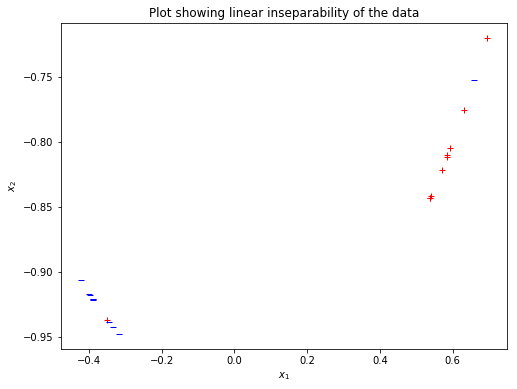

In [19]:
## Plotting
fig_prob1q4, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Plot showing linear inseparability of the data')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
##############################################################################
# TODO: Plot the modified data                                               #
##############################################################################
for i in range(n):
    if(y[i]<0):
        ax.plot(x1[i],x2[i],'b_', label="Negative")
    else:
        ax.plot(x1[i],x2[i],'r+', label="Positive")

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

plt.savefig("problem1_q4", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

In [20]:
from cvxopt import matrix, solvers
# Try running the perceptron and SVM solver on the modified dataset
# (note that you can interrupt kernel in menu bar in iPython notebook)
###############################################################################
# TODO: Run std. perceptron and SVM, state your findings in the report       #
##############################################################################

###############################################################################
# SVM Solution
##############################################################################
P_new = np.eye(p,p) 
q_new = np.zeros(p)
G_new = np.zeros((n,p))
h_new = -1*np.ones(n)
for i in range(n):
    for j in range(p):
        if(j==0):
            G_new[i,j] = (-1*y[i]*x1[i])
        else:
            G_new[i,j] = (-1*y[i]*x2[i])

theta_star_modified = quadprog_solve_qp(P_new, q_new, G=G_new, h=h_new) 
#theta_star_modified = solvers.qp(matrix(P_new), matrix(q_new), matrix(G_new), matrix(h_new)) 


###############################################################################
# Perceptron Solution
##############################################################################
theta_zero = np.zeros(p)
k, theta, gamma = std_perceptron(X, y, theta_zero)
print("Iterations taken to classify current non-separable data:",k)

##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 

ValueError: constraints are inconsistent, no solution

# Problem 2

## Preamble

In [33]:
# Replace with file path of iris1.csv if not in the same folder as this notebook
prob2_fp = 'iris1.csv'

# Import data
prob2_df = pd.read_csv(prob2_fp, header=None, names=['x1','x2','y'])

# Set up problem parameters and vectors
n, p, x1, x2, y = prob2_df.shape[0], prob2_df.shape[1] - 1, prob2_df['x1'], prob2_df['x2'], prob2_df['y']
X = prob2_df[['x1','x2']]

# Preview the first 5 rows
prob2_df.head(5)

,x1,x2,y
0,5.1,3.5,-1
1,4.9,3.0,-1
2,4.7,3.2,-1
3,4.6,3.1,-1
4,5.0,3.6,-1


## Problem 2 Q1

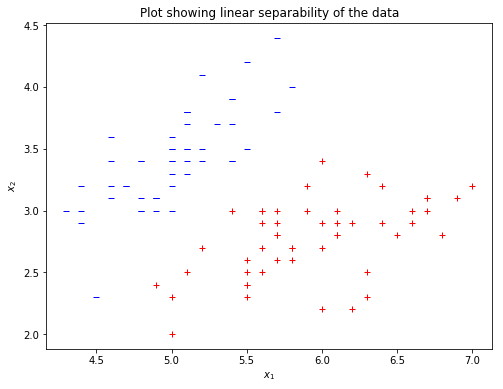

In [34]:
fig_prob2q1, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Plot showing linear separability of the data')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
##############################################################################
# TODO: Plot the labeled data by looking up the y_marker dictionary, refer   # 
# to: https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.plot.html #
##############################################################################

for i in range(n):
    if(y[i]<0):
        ax.plot(x1[i],x2[i],'b_', label="Negative")
    else:
        ax.plot(x1[i],x2[i],'r+', label="Positive")

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

plt.savefig("problem2_q1", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

## Problem 2 Q2

In [36]:
import time
##############################################################################
# TODO: Similar to Problem 1 Q3,                                             # 
# but amend the matrices to accommodate for the offset                       #
##############################################################################
eps = 3e-8
P = np.eye(p+1,p+1)
P[p,p] = eps
q = np.zeros(p+1)
G = np.zeros((n,p+1))
h = -1*np.ones(n)
for i in range(n):
    for j in range(p+1):
        if(j==0):
            G[i,j] = (-1*y[i]*x1[i])
        elif(j==1):
            G[i,j] = (-1*y[i]*x2[i])
        else:
            G[i,j] = (-1*y[i])
start = time.clock()
theta_hardsvm = quadprog_solve_qp(P, q, G=G, h=h)
end = time.clock()
print("Execution time is", end-start)
theta_0 = theta_hardsvm[2]
theta_hardsvm = np.array([theta_hardsvm[0],theta_hardsvm[1]])
#sol = solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h))
print('Problem 2 Q2 \n=================================')
print('theta_0*: %s' % theta_0)
print('theta^*: %s' % theta_hardsvm)
print('Optimal objective value is: %s' % ((pow(np.linalg.norm(theta_hardsvm),2))/2))

##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 

Execution time is 0.0002649999999988495
Problem 2 Q2 
theta_0*: -17.3157894737
theta^*: [ 6.31578947 -5.26315789]
Optimal objective value is: 33.7950138504


## Problem 2 Q3

In [19]:
## First detect the support vectors
## Collect their indices into the vector SV
## Note that the indices here are in {0,1,...,99}. In your report, give the indices in {1,2,...,100}
SV = []
for i in range(n):    
    ##############################################################################
    # TODO: Detect support vectors and append their indices into SV              #
    ##############################################################################
    value = (theta_hardsvm[0]*x1[i]+theta_hardsvm[1]*x2[i])+theta_0
    value = round(value,1)
    if(value == 1.0 or value == -1.0):
        SV.append(i)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

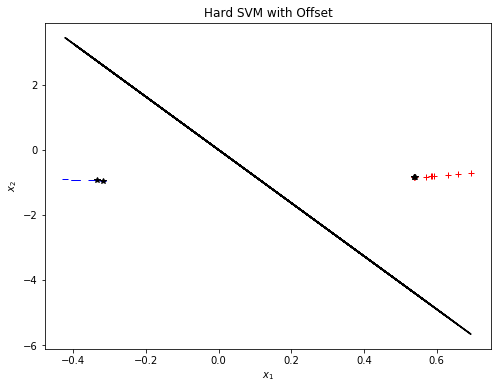

In [20]:
fig_prob2q3, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Hard SVM with Offset')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
##############################################################################
# TODO: Plot the original data                                               #
##############################################################################

for i in range(n):
    if(y[i]<0):
        ax.plot(x1[i],x2[i],'b_', label="Negative")
    else:
        ax.plot(x1[i],x2[i],'r+', label="Positive")

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################




##############################################################################
# TODO: Plot the decision boundary                                           #
##############################################################################

f = lambda x1 : a*x1 +b
a = -theta_hardsvm[0]/theta_hardsvm[1]
b = -theta_0/theta_hardsvm[1]
# draw the line in blac'k'
ax.plot(x1,f(x1),'k', label="Separator")

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################





##############################################################################
# TODO: Indicate the support vectors                                         #
##############################################################################

for i in range(len(SV)):
    ax.plot(x1[SV[i]],x2[SV[i]],'k*', label="Support Vector")
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

plt.savefig("problem2_q3", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

## Problem 2 Q4

In [13]:
##############################################################################
# TODO: Write the problem in matrix notation and solve with optimization     #
# software (e.g. quadprog)                                                   #
##############################################################################

"""
Note: You might need to perturb the 
objective matrix along the diagonal by positve eps,
to ensure that it is positive definite
"""
eps = 3e-8
P = np.zeros((n,p))
q = -np.ones(n)
G = -1*np.eye(n)
h = np.zeros(n)
b = 0
A = np.reshape(np.array([y]),(1,100))

for i in range(n):
    for j in range(p):
        if(j==0):
            P[i,j] = (y[i]*x1[i])
        else:
            P[i,j] = (y[i]*x2[i])
            
P = np.matmul(P,np.transpose(P)) + eps*np.eye(n,n)

start = time.clock()
alpha_star = quadprog_solve_qp(P=P, q=q, G=G, h=h, A=A, b=b) 
end = time.clock()
print("Execution time is", end-start)

objective = -0.5*np.matmul(np.matmul(np.transpose(alpha_star),P),alpha_star)+np.sum(alpha_star)
print("Objective value is:",objective)
indices=[]
for i in range(n):
    if(alpha_star[i]>10**-6):
        indices.append(i)
        print("Alpha from quadprog is:",alpha_star[i], " at index:", i)

#alpha_alt = sol['z']
# for i in range(n):
#     if(alpha_alt[i]>10**-6):
#             print("Alpha from CVXOPT is:",alpha_alt[i], " at index:", i)


        
##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 

ValueError: cannot reshape array of size 20 into shape (1,100)

## Problem 2 Q5

In [41]:
import random
##############################################################################
# TODO: Do your calculations here                                            #
##############################################################################

theta_kkt = np.zeros((n,p))
for i in range(n):
    for j in range(p):
        if(j==0):
            theta_kkt[i,j] = (y[i]*x1[i])
        else:
            theta_kkt[i,j] = (y[i]*x2[i])
            
theta_kkt = np.matmul(np.transpose(alpha_star),theta_kkt)

print("First sum which gives theta's value is:",theta_kkt)

index = random.choice(indices)
theta_0_kkt = y[index]-(theta_kkt[0]*x1[index]+theta_kkt[1]*x2[index])
print("Index is", index, "and the second sum which gives theta_0's value is:",theta_0_kkt)
##############################################################################
#                               END OF YOUR CODE                             #
############################################################################## 

First sum which gives theta's value is: [ 6.31578606 -5.26315523]
Index is 84 and the second sum which gives theta_0's value is: -17.3157790286


# Problem 3

## Preamble

In [9]:
# Replace with file path of iris1.csv if not in the same folder as this notebook
prob3_fp = 'iris2.csv'

# Import data
prob3_df = pd.read_csv(prob3_fp, header=None, names=['x1','x2','x3','x4','y'])

# Set up problem parameters and vectors
n, p, X, y = prob3_df.shape[0], prob3_df.shape[1] - 1, prob3_df[['x1','x2','x3','x4']], prob3_df['y']
x1,x2,x3,x4 = prob3_df['x1'],prob3_df['x2'],prob3_df['x3'],prob3_df['x4']

normalized_X = np.zeros((n,p+1))

for i in range(n):
    norm = 1
    normalized_X[i,0] = x1[i]/norm
    normalized_X[i,1] = x2[i]/norm
    normalized_X[i,2] = x3[i]/norm
    normalized_X[i,3] = x4[i]/norm
    normalized_X[i,4] = 1

# Preview the first 5 rows
prob3_df.head(5)

,x1,x2,x3,x4,y
0,7.0,3.2,4.7,1.4,-1
1,6.4,3.2,4.5,1.5,-1
2,6.9,3.1,4.9,1.5,-1
3,5.5,2.3,4.0,1.3,-1
4,6.5,2.8,4.6,1.5,-1


In [27]:
def train_SVM(C,X,y):
    eps = 3e-8
    n = len(X)
    p = 4
    P = np.zeros((n+p+1,n+p+1))

    for i in range(p):
        P[i,i] = 1-eps
        P = P + eps*np.eye(n+p+1,n+p+1)

    C = C
    q = np.zeros(n+p+1)

    for i in range(n):
        q[i+p+1] = C

    G = np.zeros((n+n,n+p+1))
    h = np.zeros(n+n)

    for i in range(n):
        h[i] = 1

    for i in range(n):
        for j in range(p+1):
            G[i,j] = y[i]*X[i,j]

    for i in range(n):
        G[i,p+i+1] = 1

    for i in range(n):
        G[i+n,i+p+1] = 1


    G = -G
    h = -h

    theta = quadprog_solve_qp(P, q, G,h)     
    return theta

## Problem 3 Q1 - Soft SVM

In [28]:
"""
Note: You might need to perturb the 
objective matrix along the diagonal by positve eps,
to ensure that it is positive definite
"""

C = 100
theta_softSVM_original = train_SVM(C,normalized_X,y)

epsilon = np.zeros(n)
for i in range(n):
    epsilon[i] = theta_softSVM_original[i+p+1]

theta_0 = theta_softSVM_original[4]
theta_softSVM_mult = np.array([theta_softSVM_original[0],theta_softSVM_original[1],theta_softSVM_original[2],theta_softSVM_original[3],theta_softSVM_original[4]])
theta_softSVM = np.array([theta_softSVM_original[0],theta_softSVM_original[1],theta_softSVM_original[2],theta_softSVM_original[3]])

objective_value = 0.5*(pow(np.linalg.norm(theta_softSVM),2)) + C*np.sum(epsilon)

print('Problem 3 Q1 \n=================================')
print('theta_0*: %s' % theta_0)
print('theta^*: %s' % theta_softSVM)
print('Optimal value is:',objective_value)

misclassified = []

for i in range(n):
    if(y[i]*(np.matmul(np.transpose(theta_softSVM_mult),normalized_X[i]))<0):
        misclassified.append(i)

print("Misclassified points are",len(misclassified),"at:",str(misclassified))

Problem 3 Q1 
theta_0*: -20.4130434783
theta^*: [ -1.84782609  -3.26086957   4.67391304  10.86956522]
Optimal value is: 654.194234405
Misclassified points are 3 at: [20, 33, 83]


## Problem 3 Q2 - Cross-validation

In [32]:
def splitX(X,index):
    X_train =  np.zeros((90,5))
    X_test = np.zeros((10,5))
    to_split =  index*10
    till = to_split+10
    k1=0
    k2=0
    for i in range(100):
        if(i>=to_split and i<till):
            X_test[k2] = X[i]
            k2+=1
        else:
            X_train[k1] = X[i]
            k1+=1
    return X_train,X_test
def splitY(Y,index):
    Y_train =  np.zeros((90,1))
    Y_test = np.zeros((10,1))
    to_split =  index*10
    till = to_split+10
    k1=0
    k2=0
    for i in range(100):
        if(i>=to_split and i<till):
            Y_test[k2] = Y[i]
            k2+=1
        else:
            Y_train[k1] = Y[i]
            k1+=1
    return Y_train,Y_test
               
def train_SVM_error(C,X_split_train,X_split_test,Y_split_train,Y_split_test):
    eps = 3e-8
    n = len(X_split_train)
    p = 4
    P = np.zeros((n+p+1,n+p+1))

    for i in range(p):
        P[i,i] = 1-eps
        P = P + eps*np.eye(n+p+1,n+p+1)

    C = C
    q = np.zeros(n+p+1)

    for i in range(n):
        q[i+p+1] = C

    G = np.zeros((n+n,n+p+1))
    h = np.zeros(n+n)

    for i in range(n):
        h[i] = 1

    for i in range(n):
        for j in range(p+1):
            G[i,j] = Y_split_train[i]*X_split_train[i,j]

    for i in range(n):
        G[i,p+i+1] = 1

    for i in range(n):
        G[i+n,i+p+1] = 1


    G = -G
    h = -h

    theta_softSVM_original = quadprog_solve_qp(P, q, G,h)     
    theta_softSVM_mult = np.array([theta_softSVM_original[0],theta_softSVM_original[1],theta_softSVM_original[2],theta_softSVM_original[3],theta_softSVM_original[4]])
    count = 0

    for i in range(len(Y_split_test)):
        if(Y_split_test[i]*(np.matmul(np.transpose(theta_softSVM_mult),X_split_test[i]))<0):
            count+=1
    
    return count;
    
def ten_fold_cross_validation(C,X,y):
    
    error = 0
    
    for i in range(10):
        X_split_train,X_split_test = splitX(X,i)
        Y_split_train,Y_split_test = splitY(y,i)
        error+=train_SVM_error(C,X_split_train,X_split_test,Y_split_train,Y_split_test)
    
    return error/10;

In [33]:
C = [1,100,10000]
av_test_error_by_C = []
for c in C:
    test_errors = []    
    test_errors.append(ten_fold_cross_validation(c,normalized_X,y))   
    av_test_error = np.mean(test_errors)
    print('C = %s, Av. test error = %s' % (c, av_test_error))
    av_test_error_by_C.append(av_test_error)
    
print('Optimal C = %s' % C[np.argmin(av_test_error_by_C)])

C = 1, Av. test error = 0.4
C = 100, Av. test error = 0.6
C = 10000, Av. test error = 0.7
Optimal C = 1
